### Machine Learning Homework III

### 3. Multilayer Perceptron (bh2821)

* This document is open sourced under Apeche License Version 2.0
* Author: Nathmath Huang (bh2821)
* Date  : May 9, 2025

`Prior to Anything`:

....* Even though I used torch, I just used its capability of computing on CUDA but `NEVER used its Autograd functionality`.

....* In my implementation, the base class `nn_Parameter` is completely compatible for `numpy` and `torch` backend,

....* so you can see I have manually programmed the gradient system and even a mimic scalable Autograd framework.

`P. Libraries`

In [1]:
import torch
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple, Any, Optional, Union, Literal

In [2]:
from copy import deepcopy

import lzma
import random
from collections import Counter
import matplotlib.pyplot as plt


In [3]:
# I have cuda
torch.cuda.is_available()

True

In [53]:
# Whether using `numpy` as the backend or `torch`
backend = "torch"; _backend = torch
device = "cuda"    

# Feel free to change those parameters since I have debugged and ensured all of them are useful.
# Though, their result may NOT be completely the same.

`P. Matrix Wrapper Library (self-implemented)`

In [5]:
# This object class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Object:
    """
    Base Type for all advanced n-dimensional data types.
    """
   
    __attr__ = "MML.Object"  
    
    def __init__(self):
        pass
   
    def __repr__(self):
        return f"Object (Abstract Data Type)."


In [6]:
# This matrix class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Matrix(Object):
    """
    A production-level Matrix class that provides a unified interface for common matrix operations used in machine learning.
    The underlying data is stored as either a numpy.ndarray or a torch.Tensor depending on the chosen backend.
    This class supports element-wise arithmetic, matrix multiplication, transpose, determinant, inverse, trace, and SVD.
    Internal optimizations avoid repeated string comparisons by setting boolean flags during initialization.
    """
    __attr__ = "MML.Matrix"    
    
    def e(self):
        """
        Returns natural exponent value as a single-value Matrix.
        
        Returns:
            -------
            Matrix with 0 shape. exp value.
        """
        if self._is_numpy:
            return Matrix(np.e, backend = self._backend, dtype = self.dtype, device = self.device)
        else:
            return Matrix(torch.e, backend = self._backend, dtype = self.dtype, device = self.device)
    
    def pi(self):
        """
        Returns pi value as a single-value Matrix.
        
        Returns:
            -------
            Matrix with 0 shape. pi value.
        """
        if self._is_numpy:
            return Matrix(np.pi, backend = self._backend, dtype = self.dtype, device = self.device)
        else:
            return Matrix(torch.pi, backend = self._backend, dtype = self.dtype, device = self.device)
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Matrix instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a matrix.
            backend (str): The backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is provided.
        """
        super().__init__()
        
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate type.
        # By Nathmath Huang
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)
    
    def __repr__(self):
        """
        Returns a string representation of the Matrix showing the backend, shape, and data.
        """
        return f"Matrix(backend={self._backend}, shape={self.shape}, data=\n{self.data})"
    
    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Matrix; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Matrix(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Matrix instance, its underlying data is used.
        """
        if isinstance(value, Matrix):
            value = value.data
        self.data[key] = value
   
    def submatrix(self, key):
      """
      Retrieves a sub-array of the matrix using the given key while ensuring the result remains two-dimensional.
      For example, using a[:, 1] will return a Matrix of shape (m, 1) rather than (m,).
      
      Args:
          key: Indexing key (can be an int, slice, or tuple of such) for sub-array extraction.
      
      Returns:
          Matrix: A new Matrix instance representing the sub-array with two dimensions.
      """
      result = self.data[key]
      # For numpy backend: if result is 1D but the original matrix is 2D, adjust the shape.
      if self._is_numpy and isinstance(result, np.ndarray):
          if result.ndim == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          # Selecting a column -> reshape to (m, 1)
                          result = result[:, np.newaxis]
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          # Selecting a row -> reshape to (1, n)
                          result = result[np.newaxis, :]
                      else:
                          result = np.atleast_2d(result)
                  else:
                      result = np.atleast_2d(result)
              else:
                  # key is a single index (e.g., a[1]) -> treat as row selection.
                  result = result[np.newaxis, :]
      # For torch backend: similar adjustments using unsqueeze.
      elif self._is_torch and torch is not None and isinstance(result, torch.Tensor):
          if result.dim() == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          result = result.unsqueeze(1)  # Make column vector.
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          result = result.unsqueeze(0)  # Make row vector.
                      else:
                          result = result.unsqueeze(0)
                  else:
                      result = result.unsqueeze(0)
              else:
                  result = result.unsqueeze(0)
      return Matrix(result, backend=self._backend) 
   
    @property
    def shape(self):
        """
        Returns the shape of the matrix.
        """
        return self.data.shape
    
    @property
    def dtype(self):
        """
        Returns the data type of the matrix elements.
        """
        return self.data.dtype
    
    @property
    def device(self):
        """
        Returns the data device of the matrix elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type

    def reshape(self, shape):
        """
        Converts the matrix into a new shape.
        
        Returns:
            Matrix: A new Matrix object with the specified shape.
        """
        return Matrix(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Matrix(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Matrix(new_data, backend="torch")

    def to(self, backend, *, dtype=None, device=None):
        """
        Converts the matrix to the specified backend and optionally sets the device for torch tensors.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device for torch tensors (e.g., "cpu" or "cuda").
                                    Ignored if converting to numpy.
        
        Returns:
            Matrix: A new Matrix object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        if target == self._backend:
            # Already in the target backend: for torch, adjust device if specified.
            if self._is_torch:
                new_data = self.data.to(device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend=self._backend, device=device, dtype=dtype)
        if target == "numpy":
            # Converting from torch to numpy: always bring to CPU.
            if self._is_torch:
                return Matrix(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                new_data = torch.tensor(self.data, device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
        raise ValueError("Unsupported backend conversion.")

    def to_rational(self):
        """
        Converts all values stored in the matrix to rational numbers (fractions.Fraction).
        For the numpy backend, returns a new Matrix with a numpy array of Fraction objects (dtype=object).
        For the torch backend, due to limitations of torch tensors with non-numeric types,
        the conversion is performed via numpy and the underlying data becomes a numpy array of Fraction objects,
        while the backend attribute is preserved as 'torch'.
        """
        if self._is_numpy:
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(self.data)
            return Matrix(new_data, backend="numpy")
        else:
            # Convert torch tensor to numpy, then to Fraction.
            np_data = self.data.cpu().numpy()
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(np_data)
            # Although backend remains 'torch', data is now a numpy array.
            return Matrix(new_data, backend="torch")

    def to_complex(self):
        """
        Converts all values stored in the matrix to complex numbers.
        For the numpy backend, returns a new Matrix with a numpy array of complex numbers.
        For the torch backend, returns a new Matrix with data converted to a torch complex tensor.
        """
        if self._is_numpy:
            new_data = self.data.astype(complex)
            return Matrix(new_data, backend="numpy")
        else:
            if not torch.is_complex(self.data):
                new_data = self.data.to(torch.complex64)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend="torch")
        
    def _apply_op(self, other, op):
        """
        Internal helper to apply an element-wise binary operation.
        
        Args:
            other (Matrix or scalar): The other operand.
            op (callable): A function that applies the desired operation element-wise.
            
        Returns:
            Matrix: A new Matrix instance with the operation applied.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        result = op(self.data, other_val)
        return Matrix(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current matrix with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Matrix: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Matrix(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Matrix(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        
        Args:
            to_append: A scalar value or an array-like object (or Matrix) to append.
            axis (int): Axis along which to append. For 2D matrices, use axis=0 (append row)
                        or axis=1 (append column).
                        
        Returns:
            Matrix: A new Matrix instance with the appended data.
        """
        orig_shape = self.data.shape
    
        # If to_append is an instance of self, extract its underlying data.
        if isinstance(to_append, type(self)):
            append_data = to_append.data
        else:
            # If to_append is a scalar, create an array of appropriate shape.
            if np.isscalar(to_append):
                if axis == 0:
                    new_shape = (1, orig_shape[1])
                elif axis == 1:
                    new_shape = (orig_shape[0], 1)
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
                if self._is_numpy:
                    append_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    append_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device.type)
            # Not a scalar
            else:
                # If the input is a matrix.
                if isinstance(to_append, Matrix):
                    if self._is_numpy:
                        append_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Otherwise, assume to_append is array-like.
                else:
                    if self._is_numpy:
                        append_data = np.array(to_append.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Validate dimensions (assuming 2D matrices)
                if len(append_data.shape) != len(orig_shape):
                    raise ValueError("Dimension mismatch: appended data must match dimensions of the matrix.")
                if axis == 0:
                    if append_data.shape[1:] != orig_shape[1:]:
                        raise ValueError("Shape mismatch for axis 0: appended array must have the same number of columns.")
                elif axis == 1:
                    if append_data.shape[0] != orig_shape[0]:
                        raise ValueError("Shape mismatch for axis 1: appended array must have the same number of rows.")
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
        
        # Concatenate along the specified axis using the appropriate backend.
        if self._is_numpy:
            new_data = np.concatenate((self.data, append_data), axis=axis)
        else:
            new_data = torch.cat((self.data, append_data), dim=axis)
        
        return Matrix(new_data, backend=self._backend)

    def __add__(self, other):
        """
        Element-wise addition.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data + other_val, backend=self._backend)
    
    def __radd__(self, other):
        """
        Right-hand element-wise addition.
        """
        return self.__add__(other)
    
    def __sub__(self, other):
        """
        Element-wise subtraction.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data - other_val, backend=self._backend)
    
    def __rsub__(self, other):
        """
        Right-hand element-wise subtraction.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(other_val - self.data, backend=self._backend)
    
    def __mul__(self, other):
        """
        Element-wise multiplication.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data * other_val, backend=self._backend)
    
    def __rmul__(self, other):
        """
        Right-hand element-wise multiplication.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(other_val * self.data, backend=self._backend)
    
    def __truediv__(self, other):
        """
        Element-wise true division.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data / other_val, backend=self._backend)
    
    def __rtruediv__(self, other):
        """
        Right-hand element-wise true division.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(other_val / self.data, backend=self._backend)
    
    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Args:
            other (Matrix or array-like): The matrix to multiply with.
            
        Returns:
            Matrix: The result of the matrix multiplication.
        """
        other_val = other.data if isinstance(other, Object) else other
        result = self.data @ other_val
        return Matrix(result, backend=self._backend)
    
    def __eq__(self, other):
        """ Equals operator. """
        if isinstance(other, Object):
            if np.prod(self.data.shape) == 1 and np.prod(other.data.shape) == 1:
                # Scalar to scalar, output a scalar
                return bool(self.flatten().data == other.flatten().data)
            else:
                return Matrix(self.data == other.data, backend=self._backend)
                
        elif np.prod(self.data.shape) == 1 and hasattr(other, "__len__") == False:
            # Scalar to scalar, output a scalar
            return bool(self.data == other)
        else:
            return Matrix(self.data == other, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__pow__(other)
    
    def __neg__(self):
        """
        Returns the negation of the matrix.
        """
        return Matrix(-self.data, backend=self._backend) 
    
    def __len__(self):
        """
        Returns the length of the matrix.
        """
        return len(self.data)
    
    def unique(self):
        """
        Returns the unique values of the elements that are non-zero.
        
        Returns:
            Matrix: The unique value matrix.
        """
        if self._is_numpy:
            result = np.unique(self.data)
        else:
            result = torch.unique(self.data)
        return Matrix(result, backend=self._backend)
    
    def nonzero(self):
        """
        Returns the indices of the elements that are non-zero.
        
        Returns:
            Matrix: The indices matrix.
        """
        if self._is_numpy:
            result = self.data.nonzero()
        else:
            result = self.data.nonzero()
        return Matrix(result, backend=self._backend)
    
    def any(self, axis = None):
        """
        Computes the element-wise logical OR along a specified axis.
        
        Args: 
            axis (int or None): Axis along which to apply the `any` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Matrix: A new matrix containing the result of the logical OR operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.any(self.data, axis=axis)
        else:
            result = self.data.any(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def all(self, axis = None):
        """
        Computes the element-wise logical AND along a specified axis.
    
        Args: 
            axis (int or None): Axis along which to apply the `all` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Matrix: A new matrix containing the result of the logical AND operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.all(self.data, axis=axis)
        else:
            result = self.data.all(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def round(self, digits = 0):
        """
        Rounds the data to a specified number of decimal places.
    
        Args:
            digits (int): The number of decimal places to round the data. Default is 0.
        
        Returns:
            Matrix: A new matrix containing the rounded values of the original data.
        """
        if self._is_numpy:
            result = np.round(self.data, decimals = digits)
        else:
            result = torch.round(self.data, decimals = digits)
        return Matrix(result, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the matrix along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed mean values.
    
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def median(self, axis = None):
        """
        Computes the median along a given axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the median. Default is None, which computes over all dimensions.
        
        Returns:
            Matrix: A new matrix containing the computed medians.
    
        """
        if self._is_numpy:
            result = np.median(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.median(self.data)
            else:
                result, _ = torch.median(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed standard deviation values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed variance values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed minimum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result, indices = torch.min(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed maximum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result, indices = torch.max(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def clip(self, a_min=None, a_max=None):
        """
        Clips the values of the matrix to a specified range.
    
        Args: 
            a_min (float or None): Minimum value for clipping. If None, no minimum is applied.
            a_max (float or None): Maximum value for clipping. If None, no maximum is applied.
    
        Returns:
            Matrix: A new instance containing the clipped values of the original data within the specified range.
        
        """
        if self._is_numpy:
            result = np.clip(self.data, a_min=a_min, a_max=a_max)
        else:
            result = torch.clip(self.data, min=a_min, max=a_max)
        return Matrix(result, backend=self._backend)
    
    def sum(self, axis = None, keepdims = False):
        """
        Computes the sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
            keepdims (bool): If keeps the dimension or not.
            
        Returns:
            Matrix: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis, keepdims=keepdims)
        else:
            result = torch.sum(self.data, dim=axis, keepdim=keepdims)
        return Matrix(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def prod(self, axis = None, keepdims = False):
        """
        Computes the product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
            keepdims (bool): If keeps the dimension or not.
            
        Returns:
            Matrix: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis, keepdims=keepdims)
        else:
            result = torch.prod(self.data, dim=axis, keepdim=keepdims)
        return Matrix(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Matrix: New matrix with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Matrix(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Matrix(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Matrix(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Matrix(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Matrix(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Matrix(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Matrix(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Matrix: New matrix with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Matrix(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Matrix: New matrix with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Matrix(result, backend=self._backend)
    
    def gamma(self):
        """
        Computes the element-wise Gamma function.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the Gamma function values for each element in the original data.
        
        """
        if self._is_numpy:
            result = sp.special.gamma(self.data)
        else:
            def torch_gamma(x):
                pos = torch.exp(torch.lgamma(x))
                neg = torch.pi / (torch.sin(torch.pi * x) * torch.exp(torch.lgamma(1 - x)))
                return torch.where(x > 0, pos, neg)
            result = torch_gamma(self.data)
        return Matrix(result, backend=self._backend) 
    
    def loggamma(self):
        """
        Computes the element-wise natural logarithm of the Gamma function.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the natural logarithm of the Gamma function values for each element in the original data.
        
        """
        if self._is_numpy:
            result = sp.special.gammaln(self.data)
        else:
            result = torch.special.gammaln(self.data)
        return Matrix(result, backend=self._backend) 
    
    def sigmoid(self):
        """
        Applies the standard sigmoid function element-wise on the input Matrix.
        
        f(x) = L / (1 + exp(-1*x))
        
        Returns:
            Matrix: A new Matrix with the sigmoid function applied element-wise.
        """
        if self._is_numpy:
            result = 1.0 / (1.0 + np.exp(-1.0 * self.data ))
        else:
            result = torch.sigmoid(self.data)
        return Matrix(result, backend=self._backend)
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Matrix.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Matrix: A new Matrix with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Matrix(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Matrix.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Matrix: A new Matrix with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Matrix(result, backend=self._backend)
    
    def cholesky(self, upper = False):
        """
        Computes the Cholesky decomposition of a symmetric positive-definite matrix.
        L @ U = self.data
        returns L if upper = False else U
        
        Args:
            upper (bool): If True, compute the upper triangular factor. Default is False.
        
        Returns:
            Matrix: A new matrix containing the lower triangular factor of the original data if `upper` is False,
                    or its transpose if `upper` is True.
        
        """
        if self._is_numpy:
            result = np.linalg.cholesky(self.data)
            if upper == True:
                result = result.T
        else:
            result = torch.cholesky(self.data, upper = upper)
        return Matrix(result, backend=self._backend)
    
    def softmax(self, axis = 1, keepdims:bool | None = True):
        """
        Applies the softmax function along a specified axis.
    
        Args:
            axis (int): Axis along which to apply the softmax. Default is 1.
            keepdims (bool or None): Whether to keep the reduced dimensions as axes with size one. 
                                    If `True`, the shape of the result will be the same as input; otherwise, it will not have these dimensions.
    
        Returns:
            Matrix: A new matrix containing the softmax values along the specified axis.
        
        """
        if self._is_numpy:
            if keepdims is not None and axis is not None:
                e_x = np.exp(self.data - np.max(self.data, axis=axis, keepdims=keepdims))
                result = e_x / e_x.sum(axis=axis, keepdims=keepdims)
            else:
                e_x = np.exp(self.data - np.max(self.data, axis=axis))
                result = e_x / e_x.sum(axis=axis)
        else:
            result = torch.nn.functional.softmax(self.data, dim=axis)
        return Matrix(result, backend=self._backend)

    def argmax(self, axis = 1):
        """
         Computes the indices of the maximum values along a specified axis.
         Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
         Args:
             axis (int | None): Axis along which to compute the argmax. Default is 1.
         
         Returns:
             Matrix: A new matrix containing the indices of the maximum values along the specified axis.
         
        """
        if self._is_numpy:
            result = np.argmax(self.data, axis=axis)
        else:
            result = torch.argmax(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def argmin(self, axis = 1):
        """
        Computes the indices of the minimum values along a specified axis.
        Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
    
        Args:
            axis (int | None): Axis along which to compute the argmin. Default is 1.
        
        Returns:
            Matrix: A new matrix containing the indices of the minimum values along the specified axis.
        
        """
        if self._is_numpy:
            result = np.argmin(self.data, axis=axis)
        else:
            result = torch.argmin(self.data, dim=axis)
        return Matrix(result, backend=self._backend)    
    
    def flatten(self, major = "row"):
        """
        Returns the flattened matrix.
        
        Returns:
            Matrix: The flattened matrix.
        """
        if major == "col":
            x = self.transpose()
            return Matrix(x.data.flatten(), backend=self._backend)
        elif major == "row":
            return Matrix(self.data.flatten(), backend=self._backend)
        else:
            raise ValueError("major must be either 'row' or 'column'!")
            
    def reverse(self, axis = 0):
        """
        Reverse the flattened matrix.
        
        Returns:
            Matrix: The reversed matrix.
        """
        if self._is_numpy:
            return Matrix(np.flip(self.data, axis=axis), backend=self._backend)
        else:
            return Matrix(torch.flip(self.data, axis=axis), backend=self._backend)
            
    def vstack(self, *wargs):
        """
        Stack data in sequence vertically (row wise).
        
        Returns:
            Matrix: The vstacked matrix.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.vstack(data_list)
        else:
            result = torch.vstack(data_list)
        return Matrix(result, backend=self._backend)
    
    def hstack(self, *wargs):
        """
        Stack data in sequence horizontally (col wise).
        
        Returns:
            Matrix: The hstacked matrix.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.hstack(data_list)
        else:
            result = torch.hstack(data_list)
        return Matrix(result, backend=self._backend)
    
    def sign(self):
        """
        Computes the element-wise sign of the data. Returns with the same type.
    
        Args: 
            None
    
        Returns:
            Matrix: A new matrix containing the sign values (1 for positive, -1 for negative, 0 for zero) of each element in the original data.
        
        """
        if self._is_numpy:
            result = np.sign(self.data)
        else:
            result = torch.sign(self.data)
        return Matrix(result, backend=self._backend)
    
    def repeat(self, repeats, axis=None):
        """
        Repeats the matrix elements along a specified axis.
    
        Args:
            repeats (int or tuple[int]): The number of times to repeat each element.
            axis (int): Axis along which to repeat the elements. If `None`, repeats over all dimensions.
    
        Returns:
            Matrix: A new matrix with repeated elements.
        """
        if self._is_numpy:
            result = self.data.repeat(repeats, axis=axis)
        else:
            if axis is None:
                result = torch.repeat_interleave(self.data, repeats)
            else:
                result = torch.repeat_interleave(self.data, repeats, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def bincount(self, *, weights = None, inttype: type = int):
        """
        Counts the number of occurrences of each value in `data` and optionally returns a weighted count.
    
        Args:
            weights (array_like | Matrix): An array-like object containing weights corresponding to each element in `data`. Default is None.
            inttype (type): A type that the data is going to be casted to.
        
        Returns:
            Matrix: A new matrix with the bin counts or weighted bin counts.
    
        """
        if self._is_numpy:
            result = np.bincount(self.astype(inttype).data, weights = weights)
        else:
            result = torch.bincount(self.astype(inttype).data, weights = weights)
        return Matrix(result, backend=self._backend)
    
    def transpose(self, *axes):
        """
        Returns the transpose of the matrix.
        
        Returns:
            Matrix: The transposed matrix.
        """
        if self._is_numpy:
            result = self.data.transpose(axes) if axes else self.data.T
        else:
            result = self.data.permute(*axes) if axes else self.data.permute(*reversed(range(self.data.dim())))
        if len(self.shape) > 1:
            return Matrix(result, backend=self._backend)
        else:
            # From a row vector to a column vector
            return Matrix(result.reshape([self.shape[0], 1]), backend=self._backend)
        
    def quantile(self, q: float, axis = None, keepdims = False):
        """
        Computes the specified quantiles along a given axis.
    
        Args:
            q (float): The quantile to compute. Should be between 0 and 1.
            axis (Optional[int]): Axis along which to compute the quantile. Default is None, which computes over all dimensions.
            keepdims (bool): Whether to keep the reduced axes in the result as singleton dimensions. Default is False.
    
        Returns:
            Matrix: A new matrix containing the computed quantiles.
    
        """
        if self._is_numpy:
            result = np.quantile(self.data, q, axis = axis, keepdims = keepdims)
        else:
            if axis is None:
                result = torch.quantile(self.data, q, keepdims = keepdims)
            else:
                result = torch.quantile(self.data, q, dim = axis, keepdims = keepdims)
        return Matrix(result, backend=self._backend)
        
    def sort(self, axis: int | None = None):
        """
        Sorts the matrix elements along (the first column of) a specified axis.
        If you intend to sort on only one array, use `sort_along` instead,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
        
        Args:
            axis (int or None): Axis to sort along. If `None`, sorts the entire matrix.
        
        Returns:
            Matrix: A new matrix with sorted elements.
        
        """
        if self._is_numpy:
            result = np.sort(self.data, axis=axis)
        else:
            if axis is None:
                result, idx = self.data.sort()
            else:
                result, idx = self.data.sort(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def sort_along(self, axis: tuple = (None, 0)):
        """
        Sort the N-dimensional data along the 1d values on `axis`.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
       
        Detail:
        Sort the input array x. The axis parameter is a tuple of t
        he same length as x.ndim, where each position can be None or an integer. 
        It is required that exactly one position d in axis_vec is not None,
        and the reference position of this dimension d is fixed = axis_vec[d], 
        but when taking this reference, the index 0 is selected for each dimension 
        in the global uniform way (i.e., only x[(0,)*d + (fixed,)] is used as the 
        reference). 
        The 1D sorting permutation is calculated (using argsort, in ascending order), 
        and then the global permutation is applied to dimension d+1 
        (the subsequent dimension) of x, acting on all data without sorting each
        preceding block separately.
        
        Parameters
        ----------
            axis : tuple
                The indicator indicating sort which data.

        Returns
        -------
            Matrix, sorted copy.

        """
        if len(self.data.shape) != len(axis):
            raise ValueError("The length of axis must be equal to the number of dimensions of the input array.")
        non_none = [(d, val) for d, val in enumerate(axis) if val is not None]
        if len(non_none) != 1:
            raise ValueError("There must be exactly one non-None element in axis")
        d, fixed = non_none[0]
        if d > len(self.data.shape) - 1:
            raise ValueError("The non-None dimension cannot be greater than dimension.")
        if fixed < 0 or fixed >= self.data.shape[d]:
            raise IndexError(f"Fixed index {fixed} is out of range for dimension {d} (0 to {self.data.shape[d]-1})")
        
        # Last dim sort
        if d == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along(axis=(axis[1], axis[0])).transpose()
        elif d == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            axis_new = list(np.repeat(None, len(self.data.shape))); axis_new[-2] = fixed
            return self.transpose(*tr_axe).sort_along(axis=axis_new).transpose(*tr_axe)
        
        # Extract global reference: fixed on dimension d, but all dimensions before d are indexed as 0.
        # Construct index tuple: fixed to 0 for dimensions < d, fixed to the dth dimension, and use slice(None) to eliminate the remaining axes.
        idx = (0,) * d + (fixed,)
        
        if self._is_numpy:
            # Extract the reference key, which is expected to be 1D and have a length equal to self.data.shape[d+1]
            key = np.asarray(self.data[idx])
            if key.ndim != 1 or key.shape[0] != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            order = np.argsort(key)
           
            # Construct a global index array for np.take_along_axis: needs to have the same shape as x,
            # but order along sorting axis d+1, other dimensions are copied via broadcasting.
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.reshape(order_shape)
            order_global = np.broadcast_to(order_global, self.data.shape)
            sorted_ = np.take_along_axis(self.data, order_global, axis=d+1)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data[idx]
            # key should be 1D, and its length should be equal to self.data.shape[d+1]
            if key.dim() != 1 or key.size(0) != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            # Calculate the sort order (ascending)
            order = torch.argsort(key, dim=0)
            
            # Construct a global index tensor with the same shape as self.data, but with order on the sorting axis d+1
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.view(*order_shape).expand(self.data.shape)
            
            # Use torch.gather to rearrange self.data according to the global index tensor on dim=d+1
            sorted_ = torch.gather(self.data, dim=d+1, index=order_global)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)
        
    def sort_along_each_column(self, axis: int = 1, on_col: int = 0):
        """
        Sort the N-dimensional data along values on column `on_col` of the axis `axis`.
        Note, it will sort EACH `on_col` of the exterior axises.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up.
       
        Detail:
        Instead of sorting itself in d dimensions, use the reference sequence obtained by taking index=i on the d axis of x, and apply the same rearrangement to the d+1 axis (next axis) of x.

        For example, for a 2D array, when d=0, i=1,
        take the reference sequence = x[1, :], calculate its argsort to get the sorted arrangement, and then rearrange the columns of each row of the entire array according to this arrangement;
        For a 3D array, when d=1, i=0,
        for each subarray with fixed axis=0, take the reference sequence = subarray[0, :] (that is, the row of axis=1 index 0),
        calculate argsort (sort the elements in the reference sequence), and then rearrange all rows in the subarray (all slices of axis=1) on axis=2 according to this arrangement.

        Parameters
        ----------
            axis : int
                The axis of the column is on. The default is 1.
            on_col : int
                The index of the column is on. The default is 0.

        Returns
        -------
            Matrix, sorted copy.

        """
        if len(self.data.shape) < 2:
            raise ValueError("The input data must at least have 2 dimensions. Use `sort` if it is a 1d array.")
        if axis < 0 or axis > len(self.data.shape) - 1:
            raise ValueError("The parameter d must be positive and smaller than ndim.")
        if axis == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along_each_column(axis=0, on_col=on_col).transpose()
        elif axis == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            return self.transpose(*tr_axe).sort_along_each_column(axis=axis-1, on_col=on_col).transpose(*tr_axe)
            
        sorted_axis = axis + 1

        if self._is_numpy:
            key = np.take(self.data, indices=on_col, axis=axis)
            order = np.argsort(key, axis=axis)
            order_expanded = np.expand_dims(order, axis=axis)
            sorted_ = np.take_along_axis(self.data, order_expanded, axis=sorted_axis)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data.select(dim=axis, index=on_col)
            order = torch.argsort(key, dim=axis)
            order_expanded = order.unsqueeze(dim=axis)
            expand_shape = list(self.data.shape)
            index = order_expanded.expand(*expand_shape)
            sorted_ = torch.gather(self.data, dim=sorted_axis, index=index)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)        
    
    def _eigen_kernel(self):
        """
        Calculates eigenvalues and eigenvectors using internal libraries (numpy or torch).
        
        Returns:
            Matrix: eigen_values, eigen_vectors: The computed eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        if self._is_numpy:
            eigen_values, eigen_vectors = np.linalg.eig(self.data)
        else:
            # Using torch.linalg.eig (available in newer versions of PyTorch)
            eigen_values, eigen_vectors = torch.linalg.eig(self.data)
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _jacobi_eigen(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition using the Jacobi rotation method for symmetric matrices.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order.
        """
        A = self.data.astype(float).copy()
        n = A.shape[0]
        V = np.eye(n)
        for iteration in range(max_iterations):
            p, q = 0, 1
            max_val = 0
            for i in range(n):
                for j in range(i+1, n):
                    if abs(A[i, j]) > max_val:
                        max_val = abs(A[i, j])
                        p, q = i, j
            if max_val < tol:
                break
            if abs(A[p, p] - A[q, q]) < tol:
                theta = np.pi / 4
            else:
                theta = 0.5 * np.arctan2(2 * A[p, q], A[q, q] - A[p, p])
            c = np.cos(theta)
            s = np.sin(theta)
            app, aqq, apq = A[p, p], A[q, q], A[p, q]
            A[p, p] = c**2 * app - 2 * s * c * apq + s**2 * aqq
            A[q, q] = s**2 * app + 2 * s * c * apq + c**2 * aqq
            A[p, q] = 0.0
            A[q, p] = 0.0
            for i in range(n):
                if i != p and i != q:
                    aip, aiq = A[i, p], A[i, q]
                    A[i, p] = c * aip - s * aiq
                    A[p, i] = A[i, p]
                    A[i, q] = s * aip + c * aiq
                    A[q, i] = A[i, q]
            for i in range(n):
                vip, viq = V[i, p], V[i, q]
                V[i, p] = c * vip - s * viq
                V[i, q] = s * vip + c * viq
        eigen_values = np.diag(A)
        idx = np.argsort(eigen_values)[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = V[:, idx]
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _qr_eigen_nonsymmetric(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition for non-symmetric matrices using a basic QR algorithm
        for eigenvalues and SVD-based extraction for eigenvectors.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order by modulus.
        """
        # Work in complex to capture possible complex eigenvalues.
        A_orig = np.array(self.data, dtype=complex)
        n = A_orig.shape[0]
        A = A_orig.copy()
        for _ in range(max_iterations):
            Q, R = np.linalg.qr(A)
            A = R @ Q
            off_diag = A - np.diag(np.diag(A))
            if np.linalg.norm(off_diag) < tol:
                break
        eigen_values = np.diag(A)
        # Compute eigenvectors by solving (A_orig - lambda I)v = 0 via SVD.
        eigen_vectors = np.empty((n, n), dtype=complex)
        for j, lam in enumerate(eigen_values):
            B = A_orig - lam * np.eye(n, dtype=complex)
            U, S, Vh = np.linalg.svd(B)
            v = Vh.conj().T[:, -1]
            v = v / np.linalg.norm(v)
            eigen_vectors[:, j] = v
        # Sort eigenpairs by descending modulus of eigenvalues.
        idx = np.argsort(np.abs(eigen_values))[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:, idx]
        return Matrix(eigen_values, backend = self._backend), Matrix(eigen_vectors, backend = self._backend)

    def eigen(self, method="kernel", symmetric=None, tol=1e-10, max_iterations=1000):
        """
        Unified eigen decomposition method.
        
        Args:
            method (str): "kernel" to use internal libraries; "selfimpl" to use the self-implemented solver.
            symmetric (bool, optional): If known symmetric; if None, determined automatically.
            tol (float): Tolerance for convergence (used in self-implementation).
            max_iterations (int): Maximum iterations (used in self-implementation).
        
        Returns:
            eigen_values, eigen_vectors: eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        # Determine symmetry if not explicitly provided.
        if symmetric is None:
            if self._is_numpy:
                symmetric = np.allclose(self.data, self.data.T, atol=tol)
            else:
                symmetric = torch.allclose(self.data, self.data.T)
                
        if method == "kernel":
            return self._eigen_kernel()
        
        elif method == "selfimpl":
            if self._is_numpy:
                if symmetric:
                    return self._jacobi_eigen(tol, max_iterations)
                else:
                    return self._qr_eigen_nonsymmetric(tol, max_iterations)
            else:
                # Use kernel instead
                return self._eigen_kernel()
        else:
            raise ValueError("Unknown eigen method. Use 'kernel' or 'selfimpl'.")

    def _check_square(self):
        """
        Internal helper to ensure the matrix is square (required for determinant, inverse, and trace).
        
        Raises:
            ValueError: If the matrix is not square.
        """
        if len(self.shape) != 2 or self.shape[0] != self.shape[1]:
            raise ValueError("This operation requires a square matrix.")
    
    def determinant(self):
        """
        Computes the determinant of a square matrix.
        
        Returns:
            Scalar: The determinant value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            return torch.det(self.data)
    
    def inverse(self):
        """
        Computes the inverse of a square matrix.
        
        Returns:
            Matrix: The inverse matrix.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            inv_data = np.linalg.inv(self.data)
        else:
            inv_data = torch.inverse(self.data)
        return Matrix(inv_data, backend=self._backend)
    
    def trace(self):
        """
        Computes the trace of a square matrix (sum of diagonal elements).
        
        Returns:
            Scalar: The trace value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
    
    def diag(self):
        """
        Computes the diagonal vector of a square matrix.
        Or create a diagonal matrix if 1D matrix.
        
        Returns:
            Matrix: The diagonal vector.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        if self._is_numpy:
            return Matrix(np.diag(self.data), backend=self._backend)
        else:
            return Matrix(torch.diag(self.data), backend=self._backend)
    
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Matrix(np.dot(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.matmul(self.data, other.data), backend="torch")
    
    def inner(self, other):
        """
        Computes the inner product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the inner product.
        """
        if self._is_numpy:
            return Matrix(np.inner(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the outer product.
        """
        if self._is_numpy:
            return Matrix(np.outer(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.outer(self.data, other.data), backend="torch")
    
    def svd(self, full_matrices=True):
        """
        Computes the Singular Value Decomposition (SVD) of the matrix.
        
        Args:
            full_matrices (bool): If True, compute the full SVD; otherwise, compute the reduced SVD.
            
        Returns:
            Tuple[Matrix, Matrix, Matrix]: A tuple containing U, S, and V^T as Matrix objects.
        """
        if self._is_numpy:
            U, S, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Matrix(U, backend="numpy"), Matrix(S, backend="numpy"), Matrix(Vh, backend="numpy")
        else:
            if hasattr(torch.linalg, 'svd'):
                U, S, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, S, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Matrix(U, backend="torch"), Matrix(S, backend="torch"), Matrix(Vh, backend="torch")
          
    def to_zeros(self):
        """
        Converts the Matrix data into a same shape Matrix with 0s.
        
        Args: 
            None
        
        Returns:
            Matrix: a same shape Matrix with 0s.
        
        """
        x = self.copy()
        x[...] = 0
        return x
    
    def to_ones(self):
        """
        Converts the Matrix data into a same shape Matrix with 1s.
        
        Args: 
            None
        
        Returns:
            Matrix: a same shape Matrix with 1s.
        
        """
        x = self.copy()
        x[...] = 1
        return x
    
    def to_ks(self, k: float | int = 0):
        """
        Converts the Matrix data into a same shape Matrix with ks.
        
        Args: 
            None
        
        Returns:
            Matrix: a same shape Matrix with 0s.
        
        """
        x = self.copy()
        x[...] = k
        return x        

    def to_rands(self):
        """
        Converts the Matrix data into a same shape Matrix with uniform random numbers.
        
        Args: 
            None
        
        Returns:
            Matrix: a same shape Matrix with uniform random numbers.
        
        """
        return self.rand(self.shape, backend=self._backend, dtype=self.dtype, device=self.device)

    def to_list(self):
        """
        Converts the matrix data into a Python list.
        
        Args: 
            None
        
        Returns:
            list: A Python list containing the same elements as `self.data`.
        
        """
        if self._is_numpy:
            return self.data.tolist()
        else:
            return self.data.cpu().tolist()
        
    def to_numpy_array(self):
        """
        Converts the matrix data into a NumPy array.
        
        Returns: 
            np.ndarray: The underlying NumPy array of the matrix.
        
        """
        if self._is_numpy:
            return self.data
        else:
            return self.data.detach().cpu().numpy()
        
    def to_torch_tensor(self, *, dtype=None, device=None):
        """
        Converts the matrix data into a PyTorch tensor.
        
        Args: 
            dtype (torch.dtype or None): The desired data type for the resulting tensor. If not provided,
                                         uses the current data type of `self.data`.
            device (torch.device or None): The target device to which the tensor should be moved.
                                           If not provided, it will use the default device.
        
        Returns:
            torch.Tensor: A PyTorch tensor containing the same data as `self.data`.
        
        """
        if self._is_numpy:
            return torch.tensor(self.data, dtype=dtype, device=device)
        else:
            return self.data
        
    @staticmethod
    def equal(x, other, *, equal_nan=False):
        """
        Compare if two Matrix objects have the same shape and elements.
        
        Args:
            x (Matrix): The one matrix to compare.
            other (Matrix): The other matrix to compare.
        
        Returns:
           ``True`` if two matrices have the same size and elements, 
           ``False`` otherwise.
        """
        if x._is_numpy == True and other._is_numpy == True:
            return np.array_equal(x, other, equal_nan=equal_nan)
        elif  x._is_numpy == False and other._is_numpy == False:
            return torch.equal(x, other)
        else:
            raise ValueError("Input `x` and `other` for comparison must have to have the same backend!")
    
    @staticmethod
    def gather_along(data, axis, index):
        """
        Gather values on an axis with specified index.
        
        Parameters:
            axis: int, the axis number to gather values on.
            index: list | array | Matrix, the indices for each row/column/.. to gather values on.
        
        Returns:
            Matrix: gathered elements.
        """
        if data._is_numpy:
            result = np.take_along_axis(data.data, indices=index, axis=axis)
        else:
            result = torch.gather(data.data, dim=axis, index=index.data)
        return Matrix(result, backend=data._backend, dtype=data.dtype, device=data.device)
    
    @staticmethod
    def where(condition, backend="numpy", dtype=None, device=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Matrix: chosen elements.
        """
        if backend == "numpy":
            result = np.where(condition)
        else:
            result = torch.where(condition)         
            if isinstance(result, tuple):
                result = result[0]
        return Matrix(result, backend=backend, dtype=dtype, device=device)
    
    @staticmethod
    def where_as(condition, then, other, backend="numpy", dtype=None, device=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Matrix: if true then applied then to true elements; other to fales elements.
        """
        if backend == "numpy":
            result = np.where(condition, then, other)
        else:
            result = torch.where(condition, then, other)         
            if isinstance(result, tuple):
                result = result[0]
        return Matrix(result, backend=backend, dtype=dtype, device=device)
    
    @staticmethod
    def zeros(shape, backend="numpy", dtype=None, device=None):
        """
        Creates a matrix filled with zeros.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            device: Data device, "cpu" or "cuda".
            
        Returns:
            Matrix: A new matrix of zeros.
        """
        if backend == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif backend == "torch":
            data = torch.zeros(shape, dtype=dtype, device=device) if dtype else torch.zeros(shape, device=device)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=backend)
    
    @staticmethod
    def ones(shape, backend="numpy", dtype=None, device=None):
        """
        Creates a matrix filled with ones.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            device: Data device, "cpu" or "cuda".
            
        Returns:
            Matrix: A new matrix of ones.
        """
        if backend == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif backend == "torch":
            data = torch.ones(shape, dtype=dtype, device=device) if dtype else torch.ones(shape, device=device)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=backend)
    
    @staticmethod
    def zeros_like(x, backend="numpy", dtype=None, device=None):
        """
        Creates a matrix of zeros with the same shape and data type as another matrix.
        
        Args:
            x (Matrix): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
            device: Data device, "cpu" or "cuda".
        
        Returns:
            Matrix: A new matrix containing zeros with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        if backend == "numpy":
            data = np.zeros_like(x.data, dtype=dtype)
        elif backend == "torch":
            data = torch.zeros_like(x.data, dtype=dtype, device=device) if dtype else torch.zeros_like(x.data, device=device)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=backend)
    
    @staticmethod
    def ones_like(x, backend="numpy", dtype=None, device=None):
        """
        Creates a matrix of ones with the same shape and data type as another matrix.
        
        Args:
            x (Matrix): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
            device: Data device, "cpu" or "cuda".
        
        Returns:
            Matrix: A new matrix containing ones with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        if backend == "numpy":
            data = np.ones_like(x.data, dtype=dtype)
        elif backend == "torch":
            data = torch.ones_like(x.data, dtype=dtype, device=device) if dtype else torch.ones_like(x.data, device=device)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=backend)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates an identity matrix of size n x n.
        
        Args:
            n (int): The number of rows and columns.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: An identity matrix.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def rand(shape, backend="numpy", dtype=None, device=None):
        """
        Creates a matrix with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            device: Data device, "cpu" or "cuda".
            
        Returns:
            Matrix: A new matrix with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(*shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype, device=device) if dtype else torch.rand(shape, device=device)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)

    @staticmethod
    def least_square(X, Y, backend="numpy", dtype=None):
        """
        Solves the linear system bX = Y using the normal equation approach.
        
        Args:
            X (Matrix): The matrix of features or independent variables.
            Y (Matrix): The matrix of observations or dependent variables.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type for the result.
            
        Returns:
            Matrix: The least-squares solution b satisfying bX = Y
        """    
        # Check if the matrix Y is with one column or not
        if len(Y.shape) == 1:
            Y = Y.reshape([Y.shape[0], 1])
        if Y.shape[1] != 1:
            raise ValueError("The input matrix Y must be of 1 column!")
        
        # Compute the least-squares solution (X^T@X)^-1@X^T@Y
        X_transpose = X.transpose()
        b = (X_transpose @ X).inverse() @ X_transpose @ Y
        if dtype:
            b = b.astype(dtype)
            
        return b



`P. Tensor Wrapper Library (self-implemented)`

In [7]:
# This tensor class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Tensor(Object):
    """
    A production-level Tensor class providing a unified interface for common machine learning operations.
    This class supports either a numpy.ndarray or a torch.Tensor as its underlying backend. To optimize performance,
    the backend string is processed once at initialization, and boolean flags (_is_numpy and _is_torch) are used to 
    avoid repeated string comparisons.
    
    The implemented operations include element-wise arithmetic, matrix multiplication, reshaping, reductions (sum, mean, 
    max, min), and element-wise exponential and logarithmic functions.
    
    Attributes:
        data (np.ndarray or torch.Tensor): Underlying storage for tensor data.
        _backend (str): Lowercase string for the backend ("numpy" or "torch").
        _is_numpy (bool): True if using numpy as the backend.
        _is_torch (bool): True if using torch as the backend.
    """
    
    __attr__ = "MML.Tensor"    
    
    def e(self):
        """
        Returns natural exponent value as a single-value Matrix.
        
        Returns:
            -------
            Tensor with 0 shape. exp value.
        """
        if self._is_numpy:
            return Tensor(np.e, backend = self._backend, dtype = self.dtype, device = self.device)
        else:
            return Tensor(torch.e, backend = self._backend, dtype = self.dtype, device = self.device)
    
    def pi(self):
        """
        Returns pi value as a single-value Matrix.
        
        Returns:
            -------
            Tensor with 0 shape. pi value.
        """
        if self._is_numpy:
            return Tensor(np.pi, backend = self._backend, dtype = self.dtype, device = self.device)
        else:
            return Tensor(torch.pi, backend = self._backend, dtype = self.dtype, device = self.device)
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Tensor instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a tensor.
            backend (str): Backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is specified.
        """
        super().__init__()
        
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate tensor type.
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)

    def __repr__(self):
        """
        Returns a string representation showing backend, shape, and data.
        """
        return f"Tensor(backend={self._backend}, shape={self.shape}, data=\n{self.data})"

    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Tensor; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Tensor(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Tensor instance, its underlying data is used.
        """
        if isinstance(value, Tensor):
            value = value.data
        self.data[key] = value

    @property
    def shape(self):
        """
        Retrieves the shape of the tensor.
        """
        return self.data.shape

    @property
    def dtype(self):
        """
        Retrieves the data type of the tensor elements.
        """
        return self.data.dtype
        
    @property
    def device(self):
        """
        Returns the data device of the tensor elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type
        
    @property
    def requires_grad(self):
        """
        Retrieve whether it requires gradients or not
        """
        if self._is_numpy:
            raise NotImplementedError("Autograd is not implemented in numpy backend.")
        else:
            return self.data.requires_grad
        
    def zero_grad(self):
        """
        Clear the Pytorch Gradient if any.
        """
        if self._is_numpy == False:
            if self.data.grad is not None:
                self.data.grad.zero_()
        return self
    
    def reshape(self, shape):
        """
        Converts the tensor into a new shape.
        
        Returns:
            Tensor: A new Tensor object with the specified shape.
        """
        return Tensor(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Tensor(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Tensor(new_data, backend="torch")
    
    def to(self, backend, *, dtype = None, device=None):
        """
        Converts the tensor to the specified backend and moves it to the specified device.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device ("cpu" or "cuda"). This parameter is only applicable when the target or source is torch.
            
        Returns:
            Tensor: A new Tensor object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        # If the target backend is the same as the current one.
        if target == self._backend:
            if self._is_torch:
                # If already torch tensor, just move it to the desired device.
                return Tensor(self.data.to(device, dtype = dtype), backend="torch")
            return Tensor(self.data, backend=self._backend, device=device, dtype=dtype)
        
        # Convert to numpy if requested.
        if target == "numpy":
            if self._is_torch:
                # Move to CPU first (numpy only works on CPU) then convert to numpy.
                return Tensor(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        
        # Convert to torch if requested.
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                # Create a torch tensor from numpy array.
                tensor = torch.tensor(self.data, dtype = dtype, device = device)
            else:
                tensor = self.data
            return Tensor(tensor, backend="torch")
        
        raise ValueError("Unsupported backend conversion.")

    def _apply_op(self, other, op):
        """
        Helper method to apply an element-wise binary operation.
        
        Args:
            other (Tensor or scalar): Other operand.
            op (callable): Function applying the desired operation element-wise.
            
        Returns:
            Tensor: New Tensor resulting from the operation.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = op(self.data, other_val)
        return Tensor(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current tensor with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Tensor: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Tensor(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Tensor(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def clone(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current tensor with the specified backend and data type without detach.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Tensor: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Tensor(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Tensor(self.data.clone(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.clone(), backend=backend, dtype=dtype, device=device)
            
    def clone_detach(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current tensor with the specified backend and data type with detach.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Tensor: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Tensor(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Tensor(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        The tensor is a general n-dimensional tensor, so the appended data must have the same 
        shape as the original tensor on all axes except the specified axis.
    
        Args:
            to_append: A scalar or an array-like object (or Tensor instance) to append.
            axis (int): Axis along which to append. Negative values are supported.
    
        Returns:
            Tensor: A new Tensor instance with the appended data.
        """
        # Get number of dimensions and normalize the axis.
        n_dim = len(self.data.shape)
        if axis < 0:
            axis = axis % n_dim
        if axis >= n_dim:
            raise ValueError(f"Axis {axis} out of bounds for array with {n_dim} dimensions.")
    
        orig_shape = self.data.shape
    
        # If to_append is a Tensor instance, extract its data.
        if isinstance(to_append, type(self)):
            appended_data = to_append.data
        else:
            # If to_append is a scalar, create an array/tensor with shape matching the original
            # on every axis except the specified axis (which will be 1).
            if np.isscalar(to_append):
                new_shape = tuple(1 if i == axis else orig_shape[i] for i in range(n_dim))
                if self._is_numpy:
                    appended_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    appended_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device)
            elif isinstance(to_append, Tensor):
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device)
            else:
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device)
        
        # If appended_data has one less dimension, expand it along the specified axis.
        if len(appended_data.shape) == n_dim - 1:
            if self._is_numpy:
                appended_data = np.expand_dims(appended_data, axis=axis)
            else:
                appended_data = torch.unsqueeze(appended_data, dim=axis)
        elif len(appended_data.shape) != n_dim:
            raise ValueError("Appended data must have either the same number of dimensions as the original Tensor or one less.")
        
        # Validate shape compatibility: for all dimensions except the specified axis, sizes must match.
        for i in range(n_dim):
            if i != axis and appended_data.shape[i] != orig_shape[i]:
                raise ValueError(f"Shape mismatch at dimension {i}: expected {orig_shape[i]}, got {appended_data.shape[i]}.")
        
        # Concatenate along the specified axis.
        if self._is_numpy:
            new_data = np.concatenate((self.data, appended_data), axis=axis)
        else:
            new_data = torch.cat((self.data, appended_data), dim=axis)
        
            # Return a new Matrix instance with the updated data.
        return Tensor(new_data, backend=self._backend)
    
    def __eq__(self, other):
        """ Equals operator. """
        if isinstance(other, Object):
            if np.prod(self.data.shape) == 1 and np.prod(other.data.shape) == 1:
                # Scalar to scalar, output a scalar
                return bool(self.flatten().data == other.flatten().data)
            else:
                return Tensor(self.data == other.data, backend=self._backend)
                
        elif np.prod(self.data.shape) == 1 and hasattr(other, "__len__") == False:
            # Scalar to scalar, output a scalar
            return bool(self.data == other)
        else:
            return Tensor(self.data == other, backend=self._backend)

    def __add__(self, other):
        """Element-wise addition."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data + other_val, backend=self._backend)

    def __radd__(self, other):
        """Right-hand element-wise addition."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val + self.data, backend=self._backend)

    def __sub__(self, other):
        """Element-wise subtraction."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data - other_val, backend=self._backend)

    def __rsub__(self, other):
        """Right-hand element-wise subtraction."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val - self.data, backend=self._backend)

    def __mul__(self, other):
        """Element-wise multiplication."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data * other_val, backend=self._backend)

    def __rmul__(self, other):
        """Right-hand element-wise multiplication."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val * self.data, backend=self._backend)

    def __truediv__(self, other):
        """Element-wise true division."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data / other_val, backend=self._backend)

    def __rtruediv__(self, other):
        """Right-hand element-wise true division."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val / self.data, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__pow__(other)

    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Uses the backend's built-in matmul operator.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = self.data @ other_val
        return Tensor(result, backend=self._backend)

    def __neg__(self):
        """Negates the tensor element-wise."""
        return Tensor(-self.data, backend=self._backend)
    
    def __len__(self):
        """
        Returns the length of the tensor.
        """
        return len(self.data)
    
    def requires_grad_(self, requires_grad: bool = False):
        """
        Require gradients to be computed or not. Only support torch.tensor.
        
        Returns:
            Tensor: A revised self tensor with gradients opt-in or opt-out.
        """
        if self._is_numpy:
            raise NotImplementedError("Autograd is not implemented by numpy backend")
        else:
            self.data = self.data.requires_grad_(requires_grad)
        return self
    
    def unique(self):
        """
        Returns the unique values of the elements that are non-zero.
        
        Returns:
            Tensor: The unique value tensor.
        """
        if self._is_numpy:
            result = np.unique(self.data)
        else:
            result = torch.unique(self.data)
        return Tensor(result, backend=self._backend)
    
    def nonzero(self):
        """
        Returns the indices of the elements that are non-zero.
        
        Returns:
            Tensor: The indices tensor.
        """
        if self._is_numpy:
            result = self.data.nonzero()
        else:
            result = self.data.nonzero()
        return Tensor(result, backend=self._backend)
    
    def any(self, axis = None):
        """
        Computes the element-wise logical OR along a specified axis.
        
        Args: 
            axis (int or None): Axis along which to apply the `any` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Tensor: A new Tensor containing the result of the logical OR operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.any(self.data, axis=axis)
        else:
            result = self.data.any(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def all(self, axis = None):
        """
        Computes the element-wise logical AND along a specified axis.
    
        Args: 
            axis (int or None): Axis along which to apply the `all` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Tensor: A new Tensor containing the result of the logical AND operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.all(self.data, axis=axis)
        else:
            result = self.data.all(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def round(self, digits = 0):
        """
        Rounds the data to a specified number of decimal places.
    
        Args:
            digits (int): The number of decimal places to round the data. Default is 0.
        
        Returns:
            Tensor: A new Tensor containing the rounded values of the original data.
        """
        if self._is_numpy:
            result = np.round(self.data, decimals = digits)
        else:
            result = torch.round(self.data, decimals = digits)
        return Tensor(result, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed mean values.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def median(self, axis = None):
        """
        Computes the median along a given axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the median. Default is None, which computes over all dimensions.
        
        Returns:
            Tensor: A new Tensor containing the computed medians.
    
        """
        if self._is_numpy:
            result = np.median(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.median(self.data)
            else:
                result, _ = torch.median(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed standard deviation values.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed variance values.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed minimum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result, indices = torch.min(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes the maximum over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed maximum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result, indices = torch.max(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def clip(self, a_min=None, a_max=None):
        """
        Clips the values of the matrix to a specified range.
    
        Args: 
            a_min (float or None): Minimum value for clipping. If None, no minimum is applied.
            a_max (float or None): Maximum value for clipping. If None, no maximum is applied.
    
        Returns:
            Tensor: A new instance containing the clipped values of the original data within the specified range.
        
        """
        if self._is_numpy:
            result = np.clip(self.data, a_min=a_min, a_max=a_max)
        else:
            result = torch.clip(self.data, min=a_min, max=a_max)
        return Tensor(result, backend=self._backend)

    def sum(self, axis = None, keepdims = False):
        """
        Computes the sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
            keepdims (bool): If keeps the dimension or not.
        
        Returns:
            Tensor: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis, keepdims=keepdims)
        else:
            result = torch.sum(self.data, dim=axis, keepdim=keepdims)
        return Tensor(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def prod(self, axis = None, keepdims = False):
        """
        Computes the product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
            keepdims (bool): If keeps the dimension or not.
    
        Returns:
            Tensor: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis, keepdims=keepdims)
        else:
            result = torch.prod(self.data, dim=axis, keepdim=keepdims)
        return Tensor(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def gamma(self):
        """
        Computes the element-wise Gamma function.
        
        Args: 
            None
        
        Returns:
            Tensor: A new Tensor containing the Gamma function values for each element in the original data.
        
        """
        if self._is_numpy:
            result = sp.special.gamma(self.data)
        else:
            def torch_gamma(x):
                pos = torch.exp(torch.lgamma(x))
                neg = torch.pi / (torch.sin(torch.pi * x) * torch.exp(torch.lgamma(1 - x)))
                return torch.where(x > 0, pos, neg)
            result = torch_gamma(self.data)
        return Tensor(result, backend=self._backend) 
    
    def loggamma(self):
        """
        Computes the element-wise natural logarithm of the Gamma function.
        
        Args: 
            None
        
        Returns:
            Tensor: A new Tensor containing the natural logarithm of the Gamma function values for each element in the original data.
        
        """
        if self._is_numpy:
            result = sp.special.gammaln(self.data)
        else:
            result = torch.special.gammaln(self.data)
        return Tensor(result, backend=self._backend) 
    
    def sigmoid(self):
        """
        Applies the standard sigmoid function element-wise on the input Matrix.
        
        f(x) = L / (1 + exp(-1*x))
        
        Returns:
            Tensor: A new Tensor with the sigmoid function applied element-wise.
        """
        if self._is_numpy:
            result = 1.0 / (1.0 + np.exp(-1.0 * self.data ))
        else:
            result = torch.sigmoid(self.data)
        return Tensor(result, backend=self._backend)
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Tensor.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Tensor: A new Tensor with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Tensor(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Tensor.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Tensor: A new Tensor with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Tensor(result, backend=self._backend)
    
    def cholesky(self, upper = False):
        """
        Computes the Cholesky decomposition of a symmetric positive-definite matrix.
        L @ U = self.data
        returns L if upper = False else U
        
        Args:
            upper (bool): If True, compute the upper triangular factor. Default is False.
        
        Returns:
            Tensor: A new Tensor containing the lower triangular factor of the original data if `upper` is False,
                    or its transpose if `upper` is True.
        
        """
        if self._is_numpy:
            result = np.linalg.cholesky(self.data)
            if upper == True:
                result = result.T
        else:
            result = torch.cholesky(self.data, upper = upper)
        return Tensor(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Tensor: New tensor with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Tensor(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Tensor(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Tensor(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Tensor(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Tensor(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Tensor(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Tensor(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Tensor: New tensor with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Tensor(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Tensor: New tensor with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Tensor(result, backend=self._backend)
    
    def softmax(self, axis = 1, keepdims:bool | None = True):
        """
        Applies the softmax function along a specified axis.
        Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
        Args:
            axis (int): Axis along which to apply the softmax. Default is 1.
            keepdims (bool or None): Whether to keep the reduced dimensions as axes with size one. 
                                    If `True`, the shape of the result will be the same as input; otherwise, it will not have these dimensions.
    
        Returns:
            Tensor: A new Tensor containing the softmax values along the specified axis.
        
        """
        if self._is_numpy:
            if keepdims is not None and axis is not None:
                e_x = np.exp(self.data - np.max(self.data, axis=axis, keepdims=keepdims))
                result = e_x / e_x.sum(axis=axis, keepdims=keepdims)
            else:
                e_x = np.exp(self.data - np.max(self.data, axis=axis))
                result = e_x / e_x.sum(axis=axis)
        else:
            result = torch.nn.functional.softmax(self.data, dim=axis)
        return Tensor(result, backend=self._backend)

    def argmax(self, axis = 1):
        """
         Computes the indices of the maximum values along a specified axis.
         Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
         Args:
             axis (int | None): Axis along which to compute the argmax. Default is 1.
         
         Returns:
             Tensor: A new Tensor containing the indices of the maximum values along the specified axis.
         
        """
        if self._is_numpy:
            result = np.argmax(self.data, axis=axis)
        else:
            result = torch.argmax(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def argmin(self, axis = 1):
        """
        Computes the indices of the minimum values along a specified axis.
    
        Args:
            axis (int | None): Axis along which to compute the argmin. Default is 1.
        
        Returns:
           Tensor: A new Tensor containing the indices of the minimum values along the specified axis.
        
        """
        if self._is_numpy:
            result = np.argmin(self.data, axis=axis)
        else:
            result = torch.argmin(self.data, dim=axis)
        return Tensor(result, backend=self._backend)    
    
    def flatten(self):
        """
        Returns the flattened tensor.
        
        Returns:
            Matrix: The flattened tensor.
        """
        return Tensor(self.data.flatten(), backend=self._backend)
    
    def diag(self):
        """
        Computes the diagonal vector of a square matrix.
        Or create a diagonal matrix if 1D matrix.
        
        Returns:
            Tensor: The diagonal vector.
            
        Raises:
            ValueError: If the Tensor is not square.
        """
        if self._is_numpy:
            return Tensor(np.diag(self.data), backend=self._backend)
        else:
            return Tensor(torch.diag(self.data), backend=self._backend)
    
    def reverse(self, axis = 0):
        """
        Reverse the flattened tensor.
        
        Returns:
            Tensor: The reversed tensor.
        """
        if self._is_numpy:
            return Tensor(np.flip(self.data, axis=axis), backend=self._backend)
        else:
            return Tensor(torch.flip(self.data, axis=axis), backend=self._backend)

    def vstack(self, *wargs):
        """
        Stack data in sequence vertically (row wise).
        
        Returns:
            Tensor: The vstacked tensor.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.vstack(data_list)
        else:
            result = torch.vstack(data_list)
        return Tensor(result, backend=self._backend)
    
    def hstack(self, *wargs):
        """
        Stack data in sequence horizontally (col wise).
        
        Returns:
            Tensor: The hstacked tensor.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.hstack(data_list)
        else:
            result = torch.hstack(data_list)
        return Tensor(result, backend=self._backend)

    def sign(self):
        """
        Computes the element-wise sign of the data. Returns with the same type.
    
        Args: 
            None
    
        Returns:
            Tensor: A new Tensor containing the sign values (1 for positive, -1 for negative, 0 for zero) of each element in the original data.
        
        """
        if self._is_numpy:
            result = np.sign(self.data)
        else:
            result = torch.sign(self.data)
        return Tensor(result, backend=self._backend)

    def repeat(self, repeats, axis=None):
        """
        Repeats the Tensor elements along a specified axis.
    
        Args:
            repeats (int or tuple[int]): The number of times to repeat each element.
            axis (int): Axis along which to repeat the elements. If `None`, repeats over all dimensions.
    
        Returns:
            Tensor: A new Tensor with repeated elements.
        """
        if self._is_numpy:
            result = self.data.repeat(repeats, axis=axis)
        else:
            if axis is None:
                result = torch.repeat_interleave(self.data, repeats)
            else:
                result = torch.repeat_interleave(self.data, repeats, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def bincount(self, *, weights = None, inttype: type = int):
        """
        Counts the number of occurrences of each value in `data` and optionally returns a weighted count.
        Values will be forcefully casted to `inttype`
    
        Args:
            weights (array_like | Tensor): An array-like object containing weights corresponding to each element in `data`. Default is None.
            inttype (type): A type that the data is going to be casted to.
        
        Returns:
            Tensor: A new Tensor with the bin counts or weighted bin counts.
    
        """
        if self._is_numpy:
            result = np.bincount(self.astype(inttype).data, weights = weights)
        else:
            result = torch.bincount(self.astype(inttype).data, weights = weights)
        return Tensor(result, backend=self._backend)
    
    def transpose(self, *axes):
        """
        Transposes the tensor dimensions. If axes are provided, permutes accordingly; otherwise, reverses dimensions.
        
        Args:
            *axes: Optional permutation of dimensions.
            
        Returns:
            Tensor: New transposed tensor.
        """
        if self._is_numpy:
            result = self.data.transpose(axes) if axes else self.data.T
        else:
            result = self.data.permute(*axes) if axes else self.data.permute(*reversed(range(self.data.dim())))
        if len(self.shape) > 1:
            return Tensor(result, backend=self._backend)
        else:
            # From a row vector to a column vector
            return Tensor(result.reshape([self.shape[0], 1]), backend=self._backend)
    
    def quantile(self, q: float, axis = None, keepdims = False):
        """
        Computes the specified quantiles along a given axis.
    
        Args:
            q (float): The quantile to compute. Should be between 0 and 1.
            axis (Optional[int]): Axis along which to compute the quantile. Default is None, which computes over all dimensions.
            keepdims (bool): Whether to keep the reduced axes in the result as singleton dimensions. Default is False.
    
        Returns:
            Tensor: A new Tensor containing the computed quantiles.
    
        """
        if self._is_numpy:
            result = np.quantile(self.data, q, axis = axis, keepdims = keepdims)
        else:
            if axis is None:
                result = torch.quantile(self.data, q, keepdims = keepdims)
            else:
                result = torch.quantile(self.data, q, dim = axis, keepdims = keepdims)
        return Tensor(result, backend=self._backend)
    
    def sort(self, axis: int | None = None):
        """
        Sorts the tensor elements along (the first column of) a specified axis.
        If you intend to sort on only one array, use `sort_along` instead,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
        
        Args:
            axis (int or None): Axis to sort along. If `None`, sorts the entire matrix.
        
        Returns:
            Tensor: A new Tensor with sorted elements.
        
        """
        if self._is_numpy:
            result = np.sort(self.data, axis=axis)
        else:
            if axis is None:
                result, idx = self.data.sort()
            else:
                result, idx = self.data.sort(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def sort_along(self, axis: tuple = (None, 0)):
        """
        Sort the N-dimensional data along the 1d values on `axis`.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
       
        Detail:
        Sort the input array x. The axis parameter is a tuple of t
        he same length as x.ndim, where each position can be None or an integer. 
        It is required that exactly one position d in axis_vec is not None,
        and the reference position of this dimension d is fixed = axis_vec[d], 
        but when taking this reference, the index 0 is selected for each dimension 
        in the global uniform way (i.e., only x[(0,)*d + (fixed,)] is used as the 
        reference). 
        The 1D sorting permutation is calculated (using argsort, in ascending order), 
        and then the global permutation is applied to dimension d+1 
        (the subsequent dimension) of x, acting on all data without sorting each
        preceding block separately.
        
        Parameters
        ----------
            axis : tuple
                The indicator indicating sort which data.

        Returns
        -------
            Tensor, sorted copy.

        """
        if len(self.data.shape) != len(axis):
            raise ValueError("The length of axis must be equal to the number of dimensions of the input array.")
        non_none = [(d, val) for d, val in enumerate(axis) if val is not None]
        if len(non_none) != 1:
            raise ValueError("There must be exactly one non-None element in axis")
        d, fixed = non_none[0]
        if d > len(self.data.shape) - 1:
            raise ValueError("The non-None dimension cannot be greater than dimension.")
        if fixed < 0 or fixed >= self.data.shape[d]:
            raise IndexError(f"Fixed index {fixed} is out of range for dimension {d} (0 to {self.data.shape[d]-1})")
        
        # Last dim sort
        if d == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along(axis=(axis[1], axis[0])).transpose()
        elif d == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            axis_new = list(np.repeat(None, len(self.data.shape))); axis_new[-2] = fixed
            return self.transpose(*tr_axe).sort_along(axis=axis_new).transpose(*tr_axe)
        
        # Extract global reference: fixed on dimension d, but all dimensions before d are indexed as 0.
        # Construct index tuple: fixed to 0 for dimensions < d, fixed to the dth dimension, and use slice(None) to eliminate the remaining axes.
        idx = (0,) * d + (fixed,)
        
        if self._is_numpy:
            # Extract the reference key, which is expected to be 1D and have a length equal to self.data.shape[d+1]
            key = np.asarray(self.data[idx])
            if key.ndim != 1 or key.shape[0] != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            order = np.argsort(key)
           
            # Construct a global index array for np.take_along_axis: needs to have the same shape as x,
            # but order along sorting axis d+1, other dimensions are copied via broadcasting.
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.reshape(order_shape)
            order_global = np.broadcast_to(order_global, self.data.shape)
            sorted_ = np.take_along_axis(self.data, order_global, axis=d+1)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data[idx]
            # key should be 1D, and its length should be equal to self.data.shape[d+1]
            if key.dim() != 1 or key.size(0) != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            # Calculate the sort order (ascending)
            order = torch.argsort(key, dim=0)
            
            # Construct a global index tensor with the same shape as self.data, but with order on the sorting axis d+1
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.view(*order_shape).expand(self.data.shape)
            
            # Use torch.gather to rearrange self.data according to the global index tensor on dim=d+1
            sorted_ = torch.gather(self.data, dim=d+1, index=order_global)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)
        
    def sort_along_each_column(self, axis: int = 1, on_col: int = 0):
        """
        Sort the N-dimensional data along values on column `on_col` of the axis `axis`.
        Note, it will sort EACH `on_col` of the exterior axises.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up.
       
        Detail:
        Instead of sorting itself in d dimensions, use the reference sequence obtained by taking index=i on the d axis of x, and apply the same rearrangement to the d+1 axis (next axis) of x.

        For example, for a 2D array, when d=0, i=1,
        take the reference sequence = x[1, :], calculate its argsort to get the sorted arrangement, and then rearrange the columns of each row of the entire array according to this arrangement;
        For a 3D array, when d=1, i=0,
        for each subarray with fixed axis=0, take the reference sequence = subarray[0, :] (that is, the row of axis=1 index 0),
        calculate argsort (sort the elements in the reference sequence), and then rearrange all rows in the subarray (all slices of axis=1) on axis=2 according to this arrangement.

        Parameters
        ----------
            axis : int
                The axis of the column is on. The default is 1.
            on_col : int
                The index of the column is on. The default is 0.

        Returns
        -------
            Tensor, sorted copy.

        """
        if len(self.data.shape) < 2:
            raise ValueError("The input data must at least have 2 dimensions. Use `sort` if it is a 1d array.")
        if axis < 0 or axis > len(self.data.shape) - 1:
            raise ValueError("The parameter d must be positive and smaller than ndim.")
        if axis == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along_each_column(axis=0, on_col=on_col).transpose()
        elif axis == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            return self.transpose(*tr_axe).sort_along_each_column(axis=axis-1, on_col=on_col).transpose(*tr_axe)
            
        sorted_axis = axis + 1

        if self._is_numpy:
            key = np.take(self.data, indices=on_col, axis=axis)
            order = np.argsort(key, axis=axis)
            order_expanded = np.expand_dims(order, axis=axis)
            sorted_ = np.take_along_axis(self.data, order_expanded, axis=sorted_axis)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data.select(dim=axis, index=on_col)
            order = torch.argsort(key, dim=axis)
            order_expanded = order.unsqueeze(dim=axis)
            expand_shape = list(self.data.shape)
            index = order_expanded.expand(*expand_shape)
            sorted_ = torch.gather(self.data, dim=sorted_axis, index=index)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)        
    
    def determinant(self):
        """
        Computes the determinant if the tensor is a matrix.
        
        Returns:
            Tensor: New tensor of determinant.
        """
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'det'):
                return torch.linalg.det(self.data)
            else:
                return torch.det(self.data)
            
    def inverse(self):
        """
        Computes the inverse of a tensor.
        
        Returns:
            Tensor: New tensor with its inversed stored.
        """
        if self._is_numpy:
            result = np.linalg.inv(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'inv'):
                result = torch.linalg.inv(self.data)
            else:
                result = torch.inverse(self.data)
        return Tensor(result, backend=self._backend)

    def trace(self):
        """
        Computes the trace of a tensor.
        
        Returns:
            Tensor: New tensor with trace stored.
        """
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
        
        
        
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Tensor(np.dot(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.matmul(self.data, other.data), backend="torch")
        
    def inner(self, other):
        """
        Computes the inner product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the inner product.
        """
        if self._is_numpy:
            return Tensor(np.inner(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the outer product.
        """
        if self._is_numpy:
            return Tensor(np.outer(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.outer(self.data, other.data), backend="torch")

    def svd(self, full_matrices=True):
        """
        Computes the singular value decomposition for a general tensor.
        
        Returns:
            Tensors: New s,v,d tensors in a tuple.
        """
        if self._is_numpy:
            U, s, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Tensor(U, backend="numpy"), Tensor(s, backend="numpy"), Tensor(Vh, backend="numpy")
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'svd'):
                U, s, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, s, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Tensor(U, backend="torch"), Tensor(s, backend="torch"), Tensor(Vh, backend="torch")
 
    def to_zeros(self):
        """
        Converts the Tensor data into a same shape Tensor with 0s.
        
        Args: 
            None
        
        Returns:
            Tensor: a same shape Tensor with 0s.
        
        """
        x = self.copy()
        x[...] = 0
        return x
    
    def to_ones(self):
        """
        Converts the Tensor data into a same shape Tensor with 1s.
        
        Args: 
            None
        
        Returns:
            Tensor: a same shape Tensor with 0s.
        
        """
        x = self.copy()
        x[...] = 1
        return x
    
    def to_ks(self, k: float | int = 0):
        """
        Converts the Tensor data into a same shape Tensor with ks.
        
        Args: 
            None
        
        Returns:
            Tensor: a same shape Tensor with 1s.
        
        """
        x = self.copy()
        x[...] = k
        return x
    
    def to_rands(self):
        """
        Converts the Tensor data into a same shape Tensor with uniform random numbers.
        
        Args: 
            None
        
        Returns:
            Tensor: a same shape Tensor with uniform random numbers.
        
        """
        return self.rand(self.shape, backend=self._backend, dtype=self.dtype, device=self.device)

    def to_list(self):
        """
        Converts the Tensor data into a Python list.
        
        Args: 
            None
        
        Returns:
            list: A Python list containing the same elements as `self.data`.
        
        """
        if self._is_numpy:
            return self.data.tolist()
        else:
            return self.data.cpu().tolist()
        
    def to_numpy_array(self):
        """
        Converts the Tensor data into a NumPy array.
        
        Returns: 
            np.ndarray: The underlying NumPy array of the matrix.
        
        """
        if self._is_numpy:
            return self.data
        else:
            return self.data.detach().cpu().numpy()
        
    def to_torch_tensor(self, *, dtype=None, device=None):
        """
        Converts the Tensor data into a PyTorch tensor.
        
        Args: 
            dtype (torch.dtype or None): The desired data type for the resulting tensor. If not provided,
                                         uses the current data type of `self.data`.
            device (torch.device or None): The target device to which the tensor should be moved.
                                           If not provided, it will use the default device.
        
        Returns:
            torch.Tensor: A PyTorch tensor containing the same data as `self.data`.
        
        """
        if self._is_numpy:
            return torch.tensor(self.data, dtype=dtype, device=device)
        else:
            return self.data
        
    @staticmethod
    def equal(x, other, *, equal_nan=False):
        """
        Compare if two Tensor objects have the same shape and elements.
        
        Args:
            x (Tensor): The one tensor to compare.
            other (Tensor): The other tensor to compare.
        
        Returns:
           ``True`` if two tensors have the same size and elements, 
           ``False`` otherwise.
        """
        if x._is_numpy == True and other._is_numpy == True:
            return np.array_equal(x, other, equal_nan=equal_nan)
        elif  x._is_numpy == False and other._is_numpy == False:
            return torch.equal(x, other)
        else:
            raise ValueError("Input `x` and `other` for comparison must have to have the same backend!")
    
    @staticmethod
    def gather_along(data, axis, index):
        """
        Gather values on an axis with specified index.
        
        Parameters:
            axis: int, the axis number to gather values on.
            index: list | array | Matrix, the indices for each row/column/.. to gather values on.
        
        Returns:
            Tensor: gathered elements.
        """
        if data._is_numpy:
            result = np.take_along_axis(data.data, indices=index, axis=axis)
        else:
            result = torch.gather(data.data, dim=axis, index=index.data)
        return Tensor(result, backend=data._backend, dtype=data.dtype, device=data.device)
    
    @staticmethod
    def where(condition, backend="numpy", dtype=None, device=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Tensor: chosen elements.
        """
        if backend == "numpy":
            result = np.where(condition)
        else:
            result, = torch.where(condition)
            if isinstance(result, tuple):
                result = result[0]
        return Tensor(result, backend=backend, dtype=dtype, device=device)
    
    @staticmethod
    def where_as(condition, then, other, backend="numpy", dtype=None, device=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Tensor: if true then applied then to true elements; other to fales elements.
        """
        if backend == "numpy":
            result = np.where(condition, then, other)
        else:
            result = torch.where(condition, then, other)         
            if isinstance(result, tuple):
                result = result[0]
        return Tensor(result, backend=backend, dtype=dtype, device=device)
        
    @staticmethod
    def zeros(shape, backend="numpy", dtype=None, device=None):
        """
        Creates a tensor filled with zeros.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            device: Data device, "cpu" or "cuda".
            
        Returns:
            Tensor: New tensor of zeros.
        """
        if backend == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif backend == "torch":
            data = torch.zeros(shape, dtype=dtype, device=device) if dtype else torch.zeros(shape, device=device)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=backend)

    @staticmethod
    def ones(shape, backend="numpy", dtype=None, device=None):
        """
        Creates a tensor filled with ones.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            device: Data device, "cpu" or "cuda".
            
        Returns:
            Tensor: New tensor of ones.
        """
        if backend == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif backend == "torch":
            data = torch.ones(shape, dtype=dtype, device=device) if dtype else torch.ones(shape, device=device)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=backend)
    
    @staticmethod
    def zeros_like(x, backend="numpy", dtype=None, device=None):
        """
        Creates a matrix of zeros with the same shape and data type as another matrix.
        
        Args:
            x (Tensor): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
            device: Data device, "cpu" or "cuda".
        
        Returns:
            Tensor: A new Tensor containing zeros with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        if backend == "numpy":
            data = np.zeros_like(x.data, dtype=dtype)
        elif backend == "torch":
            data = torch.zeros_like(x.data, dtype=dtype, device=device) if dtype else torch.zeros_like(x.data, device=device)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=backend)
    
    @staticmethod
    def ones_like(x, backend="numpy", dtype=None, device=None):
        """
        Creates a matrix of ones with the same shape and data type as another matrix.
        
        Args:
            x (Tensor): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
            device: Data device, "cpu" or "cuda".
        
        Returns:
            Tensor: A new Tensor containing ones with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        if backend == "numpy":
            data = np.ones_like(x.data, dtype=dtype)
        elif backend == "torch":
            data = torch.ones_like(x.data, dtype=dtype, device=device) if dtype else torch.ones_like(x.data, device=device)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=backend)
    
    @staticmethod
    def rand(shape, backend="numpy", dtype=None, device=None):
        """
        Creates a tensor with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            device: Data device, "cpu" or "cuda".
            
        Returns:
            Tensor: New tensor with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(*shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype, device=device) if dtype else torch.rand(shape, device=device)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates a tensor with identity property.
        
        Args:
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New identity tensor.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    def reshape_(self, *shape):
        """
        In-place reshape of the tensor.
        
        Args:
            *shape: New shape dimensions.
            
        Returns:
            self: The reshaped tensor.
        """
        self.data = self.data.reshape(*shape)
        return self


`P. Metrics for Binary and Multi-Class Classification Implementation (self-implemented)`

In [115]:
# These metrics classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Metrics Base Class
class BaseMetrics:
    
    __attr__ = "MML.BaseMetrics"

    def __init__(self):
        pass
    
    def compute(self):
        """
        Compute the specified metric for the predictions given true data.
        """
        raise NotImplementedError("Compute is NOT implemented in the base class.")
        
    def deriv_1(self):
        """
        Compute the sample-wise 1st order derivatives of metric for the predictions given true data.
        """
        raise NotImplementedError("Deriv_1 is NOT implemented in the base class.")
        
    def deriv_2(self):
        """
        Compute the sample-wise 2nd order derivatives of metric for the predictions given true data.
        """
        raise NotImplementedError("Deriv_2 is NOT implemented in the base class.")
    
    def __repr__(self):
        return "BaseMetrics(Abstract Class)."


# Metrics for regression
class RegressionMetrics(BaseMetrics):
    """
    A class to compute common regression metrics between predicted results and target values.
    
    Supported metrics:
        - MSE (Mean Squared Error)
        - RMSE (Root Mean Squared Error) 
        - MAE (Mean Absolute Error)
        - MAPE (Mean Absolute Percentage Error)
        - Huber Loss
        - Quantile Loss
        - WMSE (Weighted Mean Squared Error)
        - WRMSE (Weighted Root Mean Squared Error)
        - R^2 (R Square)
        - Adjusted R^2 (Adjusted R Square)
        
    Special metrics:
        - Negative R^2 (R Square)
        - Negative Adjusted R^2 (Adjusted R Square)
        
    The computations are performed using the underlying tensor operations, maintaining
    compatibility with both numpy and torch backends.
    
    Attributes:
        result: Predicted results tensor
        target: Target values tensor
        metric_type: String specifying which metric to compute ('mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted r2')
    """
    
    __attr__ = "MML.RegressionMetrics"
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str, k: int | None = None, **kwargs):
        """
        Initializes the RegressionMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('mse', 'rmse', 'mae', 'mape', 'huber_loss', 'quantile_loss', 
                              'wmse', 'wrmse', 'r2', 'adjusted r2', 'nr2', 'nadjusted r2')
            k (int): Number of predictors (parameters) in the model, only used in Adjusted R2.
        """
        super().__init__()
        
        # Different instances or different backends.
        if isinstance(result,  Object) == False or isinstance(target, Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")
        
        # Member variables.
        self.k = k
        self.result = result
        self.target = target
        self.typeclass = type(result)
        self.metric_type = metric_type.lower()
        
        if not self.result.shape == self.target.shape:
            raise ValueError("Result and target tensors must have the same shape.")
            
    def compute(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the specified regression metric between result and target.
        
        Args:
            **kwargs: Other arguments supported by metrics.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._compute_mse(**kwargs)
        elif self.metric_type == 'rmse':
            return self._compute_rmse(**kwargs)
        elif self.metric_type == 'mae':
            return self._compute_mae(**kwargs)
        elif self.metric_type == 'mape':
            return self._compute_mape(**kwargs)
        elif self.metric_type == 'huber_loss':
            return self._compute_huber_loss(**kwargs)
        elif self.metric_type == 'quantile_loss':
            return self._compute_quantile_loss(**kwargs)
        elif self.metric_type == 'wmse':
            return self._compute_wmse(**kwargs)
        elif self.metric_type == 'wrmse':
            return self._compute_wrmse(**kwargs)
        elif self.metric_type == 'r2':
            return self._compute_r2(**kwargs)
        elif self.metric_type == 'adjusted r2':
            return self._compute_adjusted_r2(**kwargs)
        # Special Metrics
        elif self.metric_type == 'nr2':
            return - self._compute_r2(**kwargs)
        elif self.metric_type == 'nadjusted r2':
            return - self._compute_adjusted_r2(**kwargs)
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_1(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the sample-wise 1st order derivative of the specified regression metric between result and target.
        
        Args:
            **kwargs: Other arguments supported by metrics.
        
        Returns:
            Tensor | Matrix: The computed gradient vector as a matrix or a tensor
        """
        if self.metric_type == 'mse':
            return self._deriv_1_mse(**kwargs)
        elif self.metric_type == 'rmse':
            return self._deriv_1_rmse(**kwargs)
        elif self.metric_type == 'mae':
            return self._deriv_1_mae(**kwargs)
        elif self.metric_type == 'mape':
            return self._deriv_1_mape(**kwargs)
        elif self.metric_type == 'huber_loss':
            return self._deriv_1_huber_loss(**kwargs)
        elif self.metric_type == 'quantile_loss':
            return self._deriv_1_quantile_loss(**kwargs)
        elif self.metric_type == 'wmse':
            return self._deriv_1_wmse(**kwargs)
        elif self.metric_type == 'wrmse':
            return self._deriv_1_wrmse(**kwargs)
        elif self.metric_type == 'r2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'adjusted r2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # Special Metrics
        elif self.metric_type == 'nr2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'nadjusted r2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise  ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_2(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the sample-wise 2nd order derivative of the specified regression metric between result and target.
        
        Args:
            **kwargs: Other arguments supported by metrics.
        
        Returns:
            Tensor | Matrix: The computed hessian matrix (without cross terms) as a matrix or a tensor
        """
        if self.metric_type == 'mse':
            return self._deriv_2_mse(**kwargs)
        elif self.metric_type == 'rmse':
            return self._deriv_2_rmse(**kwargs)
        elif self.metric_type == 'mae':
            return self._deriv_2_mae(**kwargs)
        elif self.metric_type == 'mape':
            return self._deriv_2_mape(**kwargs)
        elif self.metric_type == 'huber_loss':
            return self._deriv_2_huber_loss(**kwargs)
        elif self.metric_type == 'quantile_loss':
            return self._deriv_2_quantile_loss(**kwargs)
        elif self.metric_type == 'wmse':
            return self._deriv_2_wmse(**kwargs)
        elif self.metric_type == 'wrmse':
            return self._deriv_2_wrmse(**kwargs)
        elif self.metric_type == 'r2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'adjusted r2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # Special Metrics
        elif self.metric_type == 'nr2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'nadjusted r2':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise  ValueError(f"Unsupported metric type: {self.metric_type}")
        
    def _compute_mse(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: MSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** 2
        if axis is None:
            mean_squared_error = squared_error.sum(axis = axis) / np.array(squared_error.shape).prod()
        else:
            mean_squared_error = squared_error.sum(axis = axis) / squared_error.shape[axis]
        return mean_squared_error
    
    def _deriv_1_mse(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Derivative of MSE tensor or matrix with respect to result.
        """
        error = self.result - self.target
        grad = 2 * error / error.shape[0]
        if axis is None:
            grad = 2 * error / np.array(error.shape).prod()
        else:
            grad = 2 * error / error.shape[axis]
        return grad
    
    def _deriv_2_mse(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative (Hessian diagonal) of the Mean Squared Error between result and target.
    
        Args:
            only_diag: bool, if True, only calculate the diagonal vector and return,
                             else, return the full hessian matrix.
    
        Returns:
            Tensor | Matrix: Constant Hessian of MSE (2/N) with the same shape as result.
        """
        ones = self.result.copy(); ones[...] = 1;
        if axis is None:
            return ones * (2.0 / np.array(self.result.shape).prod())
        else:
            return ones * (2.0 / self.result.shape[axis])
    
    def _compute_rmse(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the Root Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
                
        Returns:
            Tensor | Matrix: RMSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** 2
        if axis is None:
            mean_squared_error = squared_error.sum(axis = axis) / np.array(squared_error.shape).prod()
        else:
            mean_squared_error = squared_error.sum(axis = axis) / squared_error.shape[axis]
        rmse = mean_squared_error ** 0.5
        return rmse
    
    def _deriv_1_rmse(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Root Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Derivative of RMSE tensor or matrix with respect to result.
        """
        error = self.result - self.target
        squared_error = error ** 2
        if axis is None:
            mean_squared_error = squared_error.sum(axis = axis) / np.array(squared_error.shape).prod()
            rmse = mean_squared_error ** 0.5
            grad = error / (np.array(squared_error.shape).prod() * rmse)
        else:
            mean_squared_error = squared_error.sum(axis = axis) / squared_error.shape[axis]
            rmse = mean_squared_error ** 0.5
            grad = error / (error.shape[axis] * rmse)

        return grad
    
    def _deriv_2_rmse(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative of the Root Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Second-order derivative (Hessian diagonal) of RMSE with respect to result.
        """
        error = self.result - self.target
        squared_error = error ** 2
        if axis is None:
            sum_squared = squared_error.sum(axis = axis)
            mean_squared_error = sum_squared / np.array(squared_error.shape).prod()
            rmse = mean_squared_error ** 0.5
            hessian = (sum_squared - squared_error) / ((np.array(squared_error.shape).prod() ** 2) * (rmse ** 3))
        else:
            sum_squared = squared_error.sum(axis = axis)
            mean_squared_error = sum_squared / squared_error.shape[axis]
            rmse = mean_squared_error ** 0.5
            hessian = (sum_squared - squared_error) / ((error.shape[axis] ** 2) * (rmse ** 3))
        
        return hessian
    
    def _compute_mae(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: MAE tensor or matrix
        """
        error = (self.result - self.target)
        absolute_error = error.abs()
        if axis is None:
            mean_absolute_error = absolute_error.sum(axis = axis) / np.array(absolute_error.shape).prod()
        else:
            mean_absolute_error = absolute_error.sum(axis = axis) / absolute_error.shape[axis]
        return mean_absolute_error

    def _deriv_1_mae(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Mean Absolute Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Derivative of MAE tensor or matrix with respect to result.
        """
        error = self.result - self.target
        grad = error.sign() / error.shape[0]
        if axis is None:
            grad = error.sign() / np.array(error.shape).prod()
        else:
            grad = error.sign() / error.shape[axis]
        return grad
    
    def _deriv_2_mae(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative of per-output MAE between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
                
        Returns:
            Tensor | Matrix: Hessian diagonal of MAE (zero), shape (N, D).
        """
        zeros = self.result.copy(); zeros[...] = 0;
        return zeros
    
    def _compute_mape(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Percentage Error between result and target.
        
        Note: Division by zero occurs if target contains zeros. This is handled
        gracefully by the underlying tensor operations, but users should ensure 
        target values are non-zero when using MAPE.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: MAPE tensor or matrix
        """
        error = (self.result - self.target) / self.target
        absolute_percentage_error = error.abs()
        if axis is None:
            mean_absolute_percentage_error = absolute_percentage_error.sum(axis = axis) / np.array(absolute_percentage_error.shape).prod()
        else:
            mean_absolute_percentage_error = absolute_percentage_error.sum(axis = axis) / absolute_percentage_error.shape[axis]
        return mean_absolute_percentage_error

    def _deriv_1_mape(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Mean Absolute Percentage Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Derivative of MAPE tensor or matrix with respect to result.
        """
        # Derivative: sign(ratio) * (1/target) / N
        ratio = (self.result - self.target) / self.target
        if axis is None:
            grad = ratio.sign() / (self.target * np.array(ratio.shape).prod())
        else:
            grad = ratio.sign() / (self.target * ratio.shape[axis])
        return grad
    
    def _deriv_2_mape(self, axis: int | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative of per-output MAPE between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
                
        Returns:
            Tensor | Matrix: Hessian diagonal of MAPE (zero), shape (N, D).
        """
        zeros = self.result.copy(); zeros[...] = 0;
        return zeros
    
    def _compute_huber_loss(self, axis: int | None = None, delta: float = 1.0, **kwargs) -> Tensor | Matrix:
        """
        Computes the Huber Loss between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Huber Loss tensor or matrix
        """
        error = self.result - self.target
        abs_error = error.abs()
        # The mask is in an INTERNAL format (np/torch)
        small_mask = abs_error.data <= delta
        
        # The squared region: 0.5 * e^2
        sq_loss = 0.5 * (error ** 2)
        # The linear region: delta * (|e| - 0.5 * delta)
        lin_loss = delta * (abs_error - 0.5 * delta)
        
        # Huber loss is a combinition of mse and mae
        if self.result._is_numpy:
            huber = np.where(small_mask, sq_loss.data, lin_loss.data)
        else:
            huber = torch.where(small_mask, sq_loss.data, lin_loss.data)
        
        if axis is None:
            return type(self.result)(huber, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device).sum(axis = axis) / np.array(error.shape).prod()
        else:
            return type(self.result)(huber, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device).sum(axis = axis) / error.shape[axis]
    
    def _deriv_1_huber_loss(self, axis: int | None = None, delta: float = 1.0, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Huber Loss between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            delta: float, the Huber threshold parameter.
        
        Returns:
            Tensor | Matrix: Derivative of Huber Loss tensor or matrix with respect to result.
        """
        error = self.result - self.target
        abs_error = error.abs()
        # The mask is in an INTERNAL format (np/torch)
        small_mask = abs_error.data <= delta
        
        if self.result._is_numpy:
            grad_elt = np.where(small_mask, error.data, delta * error.sign().data)
        else:
            grad_elt = torch.where(small_mask, error.data, delta * error.sign().data)
        
        if axis is None:
            return type(self.result)(grad_elt, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / np.array(error.shape).prod()
        else:
            return type(self.result)(grad_elt, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / error.shape[axis]

    def _deriv_2_huber_loss(self, axis: int | None = None, delta: float = 1.0, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative (Hessian diagonal) of the Huber Loss between result and target.

        Args:
            axis: None or int, if you intend to get per-output metrics/derivs, set axis = 0. Else None.
            delta: float, the Huber threshold parameter.
            
        Returns:
            Tensor | Matrix: Second-order derivative of Huber Loss wrt result, shape like result.
        """
        error = self.result - self.target
        abs_error = error.abs()
        # The mask is in an INTERNAL format (np/torch)
        small_mask = abs_error.data <= delta

        if self.result._is_numpy:
            hess_elt = small_mask.astype(float)
        else:
            # torch.where on a boolean mask: 1.0 where small, else 0.0
            one = error.ones(error.shape, backend=self.result._backend).to(backend=self.result._backend, dtype=self.result.dtype, device=self.result.device)
            zero = error.zeros(error.shape, backend=self.result._backend).to(backend=self.result._backend, dtype=self.result.dtype, device=self.result.device)
            hess_elt = torch.where(small_mask, one.data, zero.data)

        if axis is None:
            return type(self.result)(hess_elt, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / np.array(error.shape).prod()
        else:
            return type(self.result)(hess_elt, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / error.shape[axis]

    def _compute_quantile_loss(self, axis: int | None = None, q: float = 0.5, **kwargs) -> Tensor | Matrix:
        """
        Computes the Quantile Loss between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Quantile Loss tensor or matrix
        """
        error = self.result - self.target
        if self.result._is_numpy:
            loss = np.where(error.data >= 0, q * error.data, (q - 1) * error.data)
        else:
            loss = torch.where(error.data >= 0, q * error.data, (q - 1) * error.data)
        
        if axis is None:
            return type(self.result)(loss, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device).sum(axis = axis) / np.array(error.shape).prod()
        else:
            return type(self.result)(loss, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device).sum(axis = axis) / error.shape[axis]

    def _deriv_1_quantile_loss(self, axis: int | None = None, q: float = 0.5, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Quantile Loss between result and target.
        
        Args:
            axis: None or int, if you intend to get per-output metrics/derivs, set axis = 0. Else None.
            q: float in (0,1), the quantile level.
            
        Returns:
            Tensor | Matrix: Derivative of Quantile Loss tensor or matrix with respect to result.
        """
        error = self.result - self.target
        if self.result._is_numpy:
            grad_elt = np.where(error.data >= 0, q, q - 1)
        else:
            grad_elt = torch.where(error.data >= 0, q, q - 1)

        if axis is None:
            return type(self.result)(grad_elt, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / np.array(error.shape).prod()
        else:
            return type(self.result)(grad_elt, backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / error.shape[axis]

    def _deriv_2_quantile_loss(self, axis: int | None = None, q: float = 0.5, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative (Hessian diagonal) of the Quantile Loss between result and target.

        Args:
            axis: None or int, if you intend to get per-output metrics/derivs, set axis = 0. Else None.
            q: float in (0,1), the quantile level.
            
        Returns:
            Tensor | Matrix: Second-order derivative of Quantile Loss wrt result, shape like result (all zeros).
        """
        error = self.result - self.target
        
        if axis is None:
            return error.zeros_like(error).to(backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / np.array(error.shape).prod()
        else:
            return error.zeros_like(error).to(backend=self.result._backend, dtype=self.result.dtype, device=self.result.device) / error.shape[axis]

    def _compute_wmse(self, axis: int | None = None, weights: Matrix | Tensor | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the Weighted Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            weights: Matrix or Tensor or None, if None, fail to normal mse.
        
        Returns:
            Tensor | Matrix: MSE tensor or matrix
        """
        if weights is None:
            return self._compute_mse(axis = axis, **kwargs)
        
        error = (self.result - self.target)
        squared_error = error ** 2
        if axis is None:
            mean_squared_error = (weights * squared_error).sum(axis = axis) / np.array(squared_error.shape).prod()
        else:
            mean_squared_error = (weights * squared_error).sum(axis = axis) / squared_error.shape[axis]
        return mean_squared_error
    
    def _deriv_1_wmse(self, axis: int | None = None, weights: Matrix | Tensor | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Weighted Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            weights: Matrix or Tensor or None, if None, fail to normal mse.
        
        Returns:
            Tensor | Matrix: Derivative of MSE tensor or matrix with respect to result.
        """
        if weights is None:
            return self._deriv_1_mse(axis = axis, **kwargs)
        
        error = self.result - self.target
        grad = 2 * error / error.shape[0]
        if axis is None:
            grad = 2 * weights * error / np.array(error.shape).prod()
        else:
            grad = 2 * weights * error / error.shape[axis]
        return grad
    
    def _deriv_2_wmse(self, axis: int | None = None, weights: Matrix | Tensor | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative (Hessian diagonal) of the Weighted Mean Squared Error between result and target.
    
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            weights: Matrix or Tensor or None, if None, fail to normal mse.
            
        Returns:
            Tensor | Matrix: Constant Hessian of MSE (2/N) with the same shape as result.
        """
        if weights is None:
            return self._deriv_2_mse(axis = axis, **kwargs)
        
        ones = self.result.copy(); ones[...] = 1;
        if axis is None:
            return ones * (2.0 * weights / np.array(self.result.shape).prod())
        else:
            return ones * (2.0 * weights / self.result.shape[axis])
    
    def _compute_wrmse(self, axis: int | None = None, weights: Matrix | Tensor | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the Weighted Root Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            weights: Matrix or Tensor or None, if None, fail to normal rmse.
            
        Returns:
            Tensor | Matrix: RMSE tensor or matrix
        """
        if weights is None:
            return self._compute_rmse(axis = axis, **kwargs)
        
        error = (self.result - self.target)
        squared_error = weights * error ** 2
        if axis is None:
            mean_squared_error = squared_error.sum(axis = axis) / np.array(squared_error.shape).prod()
        else:
            mean_squared_error = squared_error.sum(axis = axis) / squared_error.shape[axis]
        rmse = mean_squared_error ** 0.5
        return rmse
    
    def _deriv_1_wrmse(self, axis: int | None = None, weights: Matrix | Tensor | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the Weighted Root Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            weights: Matrix or Tensor or None, if None, fail to normal rmse.
            
        Returns:
            Tensor | Matrix: Derivative of RMSE tensor or matrix with respect to result.
        """
        if weights is None:
            return self._deriv_1_rmse(axis = axis, **kwargs)
        
        error = self.result - self.target
        squared_error = weights * error ** 2
        if axis is None:
            mean_squared_error = squared_error.sum(axis = axis) / np.array(squared_error.shape).prod()
            rmse = mean_squared_error ** 0.5
            grad = weights * error / (np.array(squared_error.shape).prod() * rmse)
        else:
            mean_squared_error = squared_error.sum(axis = axis) / squared_error.shape[axis]
            rmse = mean_squared_error ** 0.5
            grad = weights * error / (error.shape[axis] * rmse)

        return grad
    
    def _deriv_2_wrmse(self, axis: int | None = None, weights: Matrix | Tensor | None = None, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative of the Weighted Root Mean Squared Error between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
            weights: Matrix or Tensor or None, if None, fail to normal rmse.
            
        Returns:
            Tensor | Matrix: Second-order derivative (Hessian diagonal) of RMSE with respect to result.
        """
        if weights is None:
            return self._deriv_2_rmse(axis = axis, **kwargs)
        
        error = self.result - self.target
        squared_error = weights * error ** 2
        if axis is None:
            sum_squared = squared_error.sum(axis = axis)
            mean_squared_error = sum_squared / np.array(squared_error.shape).prod()
            rmse = mean_squared_error ** 0.5
            N = np.array(squared_error.shape).prod()
            hessian = weights / (N * rmse) - (weights **2 * error ** 2) / ((N ** 2) * (rmse ** 3))
        else:
            sum_squared = squared_error.sum(axis = axis)
            mean_squared_error = sum_squared / squared_error.shape[axis]
            rmse = mean_squared_error ** 0.5
            N = error.shape[axis] 
            hessian = weights / (N * rmse) - (weights **2 * error ** 2) / ((N ** 2) * (rmse ** 3))
        
        return hessian
    
    def _compute_r2(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the coefficient of determination R^2 between result and target.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: R^2 value.
        """
        # Compute the residual sum of squares (SS_res)
        error = self.result - self.target
        ss_res = (error ** 2.0).sum()
        
        # Compute the total sum of squares (SS_tot)
        target_mean = self.target.sum() / self.target.shape[0]
        total_error = self.target - target_mean
        ss_tot = (total_error ** 2.0).sum()
        
        # Calculate R^2 = 1 - (SS_res / SS_tot)
        r2 = 1 - (ss_res / ss_tot)
        return r2
    
    def _compute_adjusted_r2(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the adjusted R^2 value.
        
        Args:
            axis: None or int, if you intend to get the per-output metrics/derivs, set axis = 0. Else None.
        
        Returns:
            Tensor | Matrix: Adjusted R^2 value.
        """
        # If self.k is None, badly initialized.
        if self.k is None or isinstance(self.k, int) == False:
            raise ValueError("You must specify a valid `k` as the number of parameters in the model before calculating Adjusted R^2.")
        
        # Compute R^2 using the previously defined method.
        r2 = self._compute_r2()
        
        # Determine the number of observations (be the size along the first dimension)
        n = self.target.shape[0]
        
        # Calculate adjusted R^2 using: 1 - (1-R^2)*((n-1)/(n-p-1))
        adjusted_r2 = 1 - ((1 - r2) * ((n - 1) /  (n - self.k - 1)))
        return adjusted_r2
    
    def __repr__(self):
        """
        String representation of the RegressionMetrics instance.
        """
        return f"RegressionMetrics(metric_type={self.metric_type}, shape={self.result.shape})"


# Metrics for classfication (base)
class ClassificationMetrics(BaseMetrics):

    __attr__ = "MML.ClassificationMetrics"    

    def __init__(self):
        super().__init__()
    
    def __repr__(self):
        return "ClassificationMetrics(Abstract Class)."


# Metrics for binary classification
class BinaryClassificationMetrics(ClassificationMetrics):
    """
    A class to compute common binary classification metrics between predicted results and target values.
    
    Supported metrics include:
        - accuracy
        - precision
        - recall (sensitivity) [TPR]
        - f1 score
        - specificity [TNR]
        - auc_roc
        - confusion_matrix
        - tpr (True Positive Rate)
        - tnr (True Negative Rate)
        - fpr (False Positive Rate)
        - fnr (False Negative Rate)
        - logloss (continuous)
    
    The computations are performed using the underlying tensor operations. It is assumed that both 
    the result and target are of the same type (Tensor or Matrix) and support similar operations.
    
    Attributes:
        result: Predicted results tensor or matrix (can be continuous scores or binary labels).
        target: Target binary values tensor or matrix.
        metric_type: A string specifying which metric to compute ('accuracy', 'precision', 'recall',
                     'f1', 'specificity', 'auc_roc', 'confusion_matrix').
        threshold: A float value used to convert continuous scores into binary predictions (default 0.5).
    """
    
    __attr__ = "MML.BinaryClassificationMetrics"   
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str = "accuracy", threshold: float = 0.5, **kwargs):
        """
        Initializes the BinaryClassificationMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('accuracy', 'precision', 'recall', 'f1', 'specificity',
                               'auc_roc', 'confusion_matrix', 'tpr', 'tnr', 'fpr', 'fnr', 'logloss')
            threshold (float): a threshold for considering which one to be the positive samples and negative samples.
                               In normal tasks, it is recommended to be 0.5. But adjusting this may change the metrics.
        """
        super().__init__()
        
        # Different instances or different backends.
        if isinstance(result, Object) == False or isinstance(target, Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")
        
        # Data Members.
        self.result = result
        self.target = target
        self.metric_type = metric_type.lower()
        self.threshold = threshold
        
        # Use the type of result as the typeclass.
        self.typeclass = type(result)
        
        if not self.result.shape == self.target.shape:
            raise ValueError("Result and target tensors must have the same shape.")

    def compute(self, **kwargs) -> Matrix | Tensor:
        """
        Computes the specified metric for a given model or data.
    
        Args:
            **kwargs: Other arguments supported by metrics.
            
        Returns:
            Matrix | Tensor: The computed metric value. The result is always returned as a Matrix or Tensor object,
                                      even if the computation yields a scalar.                            
        
        Raises:
            ValueError: If an unsupported metric type is provided.
            
        """
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        if self.metric_type == 'accuracy':
            return self._compute_accuracy(**kwargs)
        elif self.metric_type == 'precision':
            return self._compute_precision(**kwargs)
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            return self._compute_recall(**kwargs)
        elif self.metric_type in ('f1', 'f1 score'):
            return self._compute_f1(**kwargs)
        elif self.metric_type in ('specificity', 'tnr'):
            return self._compute_specificity(**kwargs)
        elif self.metric_type == 'fpr':
            return self._compute_fpr(**kwargs)
        elif self.metric_type == 'fnr':
            return self._compute_fnr(**kwargs)
        elif self.metric_type == 'auc_roc':
            return self._compute_auc_roc(**kwargs)
        elif self.metric_type == 'confusion_matrix':
            return self._compute_confusion_matrix(**kwargs)
        elif self.metric_type in ('logloss', 'log-loss', 'entropy', 'cross-entropy'):
            return self._compute_logloss(**kwargs)
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_1(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the sample-wise 1st order derivative for a given model or data.
        
        Args:
            **kwargs: Other arguments supported by metrics.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        if self.metric_type in ('logloss', 'log-loss', 'entropy', 'cross-entropy'):
            return self._deriv_1_logloss(**kwargs)
        elif self.metric_type == 'accuracy':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'precision':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type in ('f1', 'f1 score'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type in ('specificity', 'tnr'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'fpr':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'fnr':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'auc_roc':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'confusion_matrix':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_2(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the sample-wise 2nd order derivative for a given model or data.
        
        Args:
            **kwargs: Other arguments supported by metrics.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        if self.metric_type in ('logloss', 'log-loss', 'entropy', 'cross-entropy'):
            return self._deriv_2_logloss(**kwargs)
        elif self.metric_type == 'accuracy':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'precision':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type in ('f1', 'f1 score'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type in ('specificity', 'tnr'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'fpr':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'fnr':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'auc_roc':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'confusion_matrix':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
            
    def _binarize(self, y_real_or_pred: Matrix | Tensor) -> Matrix | Tensor:
        """
        Binarizes continuous prediction scores by applying a threshold.
    
        Args:
            y_real_or_pred (Matrix | Tensor): the y values to be binarized.
    
        Returns:
            Matrix | Tensor: A matrix or tensor containing binary predictions (True/False values).
    
        """
        # Return the results in a Matrix or Tensor of Booleans
        return self.typeclass(y_real_or_pred.data >= self.threshold, backend = y_real_or_pred._backend, device = y_real_or_pred.device)
    
    def _compute_confusion_counts(self, **kwargs):
        """
        Computes the counts of true positives (TP), true negatives (TN), 
                     false positives (FP) and false negatives (FN) using binarized predictions.
    
        Args:
            None
    
        Returns:
            tuple: A tuple containing four elements, each representing TP, TN, FP, and FN respectively.
                  Each element is a matrix or tensor of the same type as self.target.
    
        """
        pred = self._binarize(self.result)  # Full of Booleans.
        real = self._binarize(self.target)  # Full of Booleans.

        TP = ((pred.data == True) & (real.data == True)).sum()
        TN = ((pred.data == False) & (real.data == False)).sum()
        FP = ((pred.data == True) & (real.data == False)).sum()
        FN = ((pred.data == False) & (real.data == True)).sum()
        return (self.typeclass(TP, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device), 
                self.typeclass(TN, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device),
                self.typeclass(FP, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device),
                self.typeclass(FN, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
                )

    def _compute_accuracy(self, **kwargs):
        """
        Computes accuracy = (TP + TN) / total.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed accuracy value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, TN, FP, FN = self._compute_confusion_counts()
        total = TP + TN + FP + FN
        return (TP + TN) / total

    def _compute_precision(self, **kwargs):
        """
        Computes precision = TP / (TP + FP).
    
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed precision value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, FP, _ = self._compute_confusion_counts()
        denom = TP + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_recall(self, **kwargs):
        """
        Computes recall (sensitivity) = TP / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed recall value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_f1(self, **kwargs):
        """
        Computes the F1 score as the harmonic mean of precision and recall.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed f1 score value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, TN, FP, FN = self._compute_confusion_counts()
        denom = 2 * TP + FP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return 2 * TP / denom

    def _compute_specificity(self, **kwargs):
        """
        Computes specificity = TN / (TN + FP).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed specificity value.
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = TN + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TN / denom

    def _compute_tpr(self, **kwargs):
        """
        Computes recall (TPR) = TP / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TPR value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_tnr(self, **kwargs):
        """
        Computes specificity (TNR) = TN / (TN + FP).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TNR value.
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = TN + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TN / denom

    def _compute_fpr(self, **kwargs):
        """
        Computes FPR = FP / (FP + TN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TPR value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = FP + TN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return FP / denom

    def _compute_fnr(self, **kwargs):
        """
        Computes FNR = FN / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed FNR value.
        
        """
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return FN / denom

    def _compute_auc_roc(self, **kwargs):
        """
        Computes the area under the ROC curve (AUC-ROC) using the trapezoidal rule.
        This method assumes that self.result contains continuous prediction scores.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed auc_roc area.
        """
        # Always return a Matrix | Tensor as the class input.
        scores = self.result.data
        labels = self.target.data
        
        # Sort indices based on scores in descending order.
        sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
        sorted_labels = [labels[i] for i in sorted_indices]
        P = sum(labels)
        N = len(labels) - P
        if P == 0 or N == 0:
            return self.typeclass(0.0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)

        tpr, fpr = [], []
        tp = 0
        fp = 0
        for label in sorted_labels:
            if label == 1:
                tp += 1
            else:
                fp += 1
            tpr.append(tp / P)
            fpr.append(fp / N)
        
        auc = 0.0
        prev_fpr = 0.0
        prev_tpr = 0.0
        for current_fpr, current_tpr in zip(fpr, tpr):
            auc += (current_fpr - prev_fpr) * (current_tpr + prev_tpr) / 2.0
            prev_fpr = current_fpr
            prev_tpr = current_tpr
        return self.typeclass(auc, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)

    def _compute_logloss(self, **kwargs):
        """
        Computes the binary classification log loss between predicted and actual values.
    
        Args: 
            None
            
        Returns:
            Matrix | Tensor: The computed logloss using this formula:
                logloss = - (y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
        """
        epsilon = 1e-15
        preds = self.result.to(self.result._backend, dtype=float)
        labels = self.target.to(self.result._backend, dtype=float)
        clipped_preds = preds.clip(epsilon, 1 - epsilon)
        losses = -(labels * clipped_preds.log() + (1 - labels) * (1 - clipped_preds).log())
        return losses.mean()

    def _deriv_1_logloss(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the binary classification log loss between predicted and actual values.

        Args: 
            None
            
        Returns:
            Matrix | Tensor: Derivative of logloss with respect to the predictions.
        """
        epsilon = 1e-15
        preds = self.result.to(self.result._backend, dtype=float)
        labels = self.target.to(self.result._backend, dtype=float)
        clipped = preds.clip(epsilon, 1 - epsilon)
        grad = ((1 - labels) / (1 - clipped) - labels / clipped) / clipped.shape[0]
        return grad
    
    def _deriv_2_logloss(self, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative of the binary classification log loss between predicted and actual values.

        Args: 
            None
            
        Returns:
            Matrix | Tensor: Second-order derivative (Hessian diagonal) of logloss with respect to the predictions.
        """
        epsilon = 1e-15
        preds = self.result.to(self.result._backend, dtype=float)
        labels = self.target.to(self.result._backend, dtype=float)
        clipped = preds.clip(epsilon, 1 - epsilon)
        hess = ((1 - labels) / (1 - clipped) ** 2 + labels / clipped ** 2) / clipped.shape[0]
        return hess

    def _compute_confusion_matrix(self, **kwargs):
        """
        Computes the confusion matrix as a 2x2 tensor or matrix with the format:
          [[TP, FP],
           [FN, TN]]
            
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed confusion matrix, with shape 2,2.
        """
        TP, TN, FP, FN = self._compute_confusion_counts()
        return self.typeclass(
            [TP.data, FP.data,
             FN.data, TN.data], 
            backend=self.target._backend, dtype=self.target.dtype, device=self.target.device).reshape([2,2])

    def __repr__(self):
        return f"BinaryClassificationMetrics(metric_type={self.metric_type}, shape={self.result.shape})"


# Metrics for multi-class classification
class MultiClassificationMetrics(ClassificationMetrics):
    """
    A class to compute common multi-class classification metrics between predicted results and target values.
    
    Supported metrics include:
        - accuracy
        - precision        (macro-average computed either in one-vs-rest (OVR) or one-vs-one (OVO) mode)
        - recall           (macro-average computed either in OVR or OVO mode)
        - f1 score         (macro-average computed either in OVR or OVO mode)
        - logloss          (cross-entropy loss, continuous)
        - confusion_matrix (of shape [n_classes, n_classes])
        
    The class is designed to support two scenarios:
        1. Multi-target: where predictions are provided as a 1D vector of labels
           (e.g. 0, 1, 2, 3, ...) and the target is also a vector.
        2. One-hot: where the target (and optionally predictions) are provided as a
           one-hot encoded matrix of shape [n_samples, n_classes].
    
    When computing precision, recall, and f1-score, the user can specify
    whether the aggregation should be based on one-vs-rest (default) or one-vs-one.
    
    Attributes:
        result (Tensor | Matrix): Predicted results. Can be either a 1D vector (labels) 
                                   or a 2D matrix (probabilities / one-hot scores). 
        target (Tensor | Matrix): True labels. Must be in a format compatible with result
                                   (either both 1D or both 2D, or convertible between them).
        metric_type (str): Which metric to compute ("accuracy", "precision", "recall",
                           "f1", "logloss", "confusion_matrix").
        mode (str): For metrics that require binary decomposition ("precision",
                    "recall", "f1"), the aggregation mode: either "ovr" (one-vs-rest) or "ovo" (one-vs-one).
    """
    
    __attr__ = "MML.MultiClassificationMetrics"   
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str = "accuracy", n_classes: int = None, mode: str = "ovr", **kwargs):
        """
        Initializes the MultiClassificationMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('accuracy', 'precision', 'recall', 'f1', 'confusion_matrix', 'logloss')
            n_classes (int): Number of Classes
            mode (str): `ovr` or `ovo`, one versus remaining or one versus one.
        """
        super().__init__()
        
        # Check type compatibility
        if isinstance(result, Object) == False or isinstance(target,  Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")

        # Data Members.        
        self.result = result
        self.target = target
        self.metric_type = metric_type.lower()
        self.mode = mode.lower()
        self.typeclass = type(result)
        
        # Determine classification format and number of classes.
        # If given, then okay, or infer.
        # If one of the inputs is two-dimensional, we assume the second dimension is the number of classes.
        if n_classes is not None:
            self.n_classes = n_classes
        else:
            if len(result.shape) == 2:
                if result.shape[1] == 1:
                    # Check if it is indeed a binary problem
                    if len(result.flatten().bincount().unique()) == 2:
                        self.n_classes = 2
                    else:
                        self.n_classes = len(result.flatten().bincount().unique())
                        # Not safe, but okay.
                else:
                    self.n_classes = result.shape[1]
            elif len(target.shape) == 2:
                if target.shape[1] == 1:
                    # Check if it is indeed a binary problem
                    if len(target.flatten().unique()) == 2:
                        self.n_classes = 2
                    else:
                        self.n_classes = len(target.flatten().unique())
                        # Not safe, but okay.
                else:
                    self.n_classes = target.shape[1]
            else:
                # Error. The result dimension is not 2?!!
                raise ValueError("The input `result` and `target` do not have a 2-dimension shape. Make sure it is a multi-classification problem. Set n_classes or resize the Matrix | Tensor if you only have one row.")
        
    def compute(self, eps: float = 1e-15, floattype: type = float, **kwargs) -> Matrix | Tensor:
        """
        Computes the specified multi-class metric.
        
        Supported metric_type values (case insensitive):
            - 'accuracy'
            - 'precision'
            - 'recall'
            - 'f1'
            - 'logloss'
            - 'confusion_matrix'
        
        For precision, recall and f1, the results are computed according to the specified mode (ovr or ovo).
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
            **kwargs: Other arguments supported by metrics.
    
        Returns:
            Matrix | Tensor: The computed metric value. The result is always returned as a Matrix or Tensor object,
                                      even if the computation yields a scalar.
        
        Raises:
            ValueError: If an unsupported metric type or mode type is provided.
        """
        
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        # Accuracy
        if self.metric_type == 'accuracy':
            return self._compute_accuracy(floattype=floattype, **kwargs)
        # Precision
        elif self.metric_type == 'precision':
            if self.mode == 'ovr':
                return self._compute_precision_ovr(eps=eps, floattype=floattype, **kwargs)
            elif self.mode == 'ovo':
                return self._compute_precision_ovo(eps=eps, floattype=floattype, **kwargs)
            else:
                raise ValueError(f"Unsupported mode for precision: {self.mode}. Use `ovo` or `ovr`.")
        # Recall
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            if self.mode == 'ovr':
                return self._compute_recall_ovr(eps=eps, floattype=floattype, **kwargs)
            elif self.mode == 'ovo':
                return self._compute_recall_ovo(eps=eps, floattype=floattype, **kwargs)
            else:
                raise ValueError(f"Unsupported mode for recall: {self.mode}. Use `ovo` or `ovr`.")
        # F1 Score
        elif self.metric_type in ('f1', 'f1 score'):
            if self.mode == 'ovr':
                return self._compute_f1_ovr(eps=eps, floattype=floattype, **kwargs)
            elif self.mode == 'ovo':
                return self._compute_f1_ovo(eps=eps, floattype=floattype, **kwargs)
            else:
                raise ValueError(f"Unsupported mode for f1: {self.mode}. Use `ovo` or `ovr`.")
        # Cross entropy/logloss
        elif self.metric_type in ('logloss', 'log-loss', 'entropy', 'cross-entropy'):
            return self._compute_logloss(eps=eps, floattype=floattype, **kwargs)
        # Confusion matrix
        elif self.metric_type == 'confusion_matrix':
            return self._compute_confusion_matrix(**kwargs)
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_1(self, eps: float = 1e-15, floattype: type = float, **kwargs) -> Matrix | Tensor:
        """
        Computes the specified multi-class element-wise 1st order derivative.
        
        Supported metric_type values (case insensitive):
            - 'logloss'
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
            **kwargs: Other arguments supported by metrics.
    
        Returns:
            Matrix | Tensor: The computed metric value. The result is always returned as a Matrix or Tensor object,
                                      even if the computation yields a scalar.
        
        Raises:
            ValueError: If an unsupported metric type or mode type is provided.
        """
        
        # Note, only "logloss" supports derivatives.
        # Cross entropy/logloss
        if self.metric_type in ('logloss', 'log-loss', 'entropy', 'cross-entropy'):
            return self._deriv_1_logloss(eps=eps, floattype=floattype, **kwargs)
        # Accuracy
        elif self.metric_type == 'accuracy':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # Precision
        elif self.metric_type == 'precision':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # Recall
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # F1 Score
        elif self.metric_type in ('f1', 'f1 score'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")

        # Confusion matrix
        elif self.metric_type == 'confusion_matrix':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_2(self, eps: float = 1e-15, floattype: type = float, **kwargs) -> Tensor | Matrix:
        """
        Computes the sample-wise 2nd order derivative for a given model or data.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        # Note, only "logloss" supports derivatives.
        # Cross entropy/logloss
        if self.metric_type in ('logloss', 'log-loss', 'entropy', 'cross-entropy'):
            return self._deriv_2_logloss(eps=eps, floattype=floattype, **kwargs)
        # Accuracy
        elif self.metric_type == 'accuracy':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # Precision
        elif self.metric_type == 'precision':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # Recall
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        # F1 Score
        elif self.metric_type in ('f1', 'f1 score'):
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")

        # Confusion matrix
        elif self.metric_type == 'confusion_matrix':
            raise  ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
            
    def _to_labels(self, x: Tensor | Matrix, *, apply_softmax:bool = False) -> Tensor | Matrix:
        """
        Converts predictions or targets into label vectors.
        
        If x has more than one column (i.e. one-hot or probability matrix), it returns
        the index of the maximum value along axis 1. Otherwise, x is assumed already to be a vector.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.
            apply_softmax: bool, whether to apply softmax before calculating argmax or not.
    
        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] > 1:
            # Always keep the dim.
            return x.argmax(axis=1).reshape([-1, 1]) if apply_softmax == False else x.softmax(axis=1).argmax(axis=1).reshape([-1, 1])
        # Narrow table
        else:    
            return x

    def _to_onehot(self, x: Tensor | Matrix, *, binarize = False) -> Tensor | Matrix:
        """
        Converts a label vector into a one-hot encoded matrix of shape [n_samples, n_classes].
        If x is already a matrix with the correct number of columns, it is returned unaltered.
        If x is binary probability input and binarize is False, then will return the probablistic one-hot.
                     
        Args:
            x: Matrix | Tensor: The label-encoded matrix.
    
        Returns:
            Matrix | Tensor: The converted one-hot Tensor or Matrix in (n_samples, n_classes) shape.
        """
        if len(x.shape) == 2 and x.shape[1] == self.n_classes:
            return x
        
        # If binary case, then create a probabilistic one-hot to reduce information loss
        if self.n_classes == 2 and binarize == False:
            onehot_data = type(x).zeros([x.shape[0], 2], backend=x._backend)
            onehot_data[:, 1] = x.flatten()
            onehot_data[:, 0] = 1.0 - onehot_data[:, 1]
            return onehot_data.to(backend=x._backend, device=x.device, dtype=x.dtype)
        
        # Else, do the round
        else:
            # Create one-hot by comparing each element with a range vector.
            range_vec = self.typeclass(np.arange(self.n_classes), backend=x._backend, device=x.device)
            # Reshape x to [n_samples, 1] if necessary
            x_reshaped = x.reshape([x.shape[0], 1])
        
            # Broadcast the comparison: each entry becomes True if equal to the class index.
            onehot_data = x_reshaped.astype(self.result.dtype).round() == range_vec
            # The above one produces a boolean array -> like True, False, True, ...
            #                                                False, True, False, ...
            return onehot_data.to(backend=x._backend, device=x.device, dtype=float)

    def _compute_accuracy(self, *, floattype: type = float, **kwargs):
        """
        Computes accuracy = (# correct predictions) / (# total samples).
                             
        Args:
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: The computed accuracy value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        correct = pred_labels == true_labels
        total = true_labels.shape[0]
        return correct.sum().to(correct._backend, dtype=floattype, device=correct.device) / total
    
    def _compute_confusion_matrix(self, **kwargs):
        """
        Computes the multi-class confusion matrix of shape [n_classes, n_classes],
        where rows correspond to true labels and columns to predicted labels.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed confusion matrix with shape [n_classes, n_classes].
        """
        # Convert both predictions and targets to label vectors
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        
        # Convert them into one-hot matrices of shape [n_samples, n_classes]
        pred_onehot = self._to_onehot(pred_labels)
        true_onehot = self._to_onehot(true_labels)
        
        # Compute the confusion matrix as: (true_onehot)^T dot (pred_onehot)
        conf_matrix = true_onehot.transpose().dot(pred_onehot)
        return conf_matrix

    def _compute_logloss(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes the cross-entropy loss (logloss) for multi-class classification.
        
        Assumes that `result` is a probability matrix of shape [n_samples, n_classes].
        The loss is computed as:
            logloss = - 1/N * sum_over_samples [ sum_over_classes (y_true * log(y_pred)) ]
            
        Args:
            eps: float, clip value to ensure predictions are not going to be log(0)
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: The computed log loss value.
        """
        if len(self.result.shape) != 2:
            raise ValueError("Logloss metric requires probability predictions with shape [n_samples, n_classes].")
        
        # Ensure predictions are floating point and clip values to avoid log(0)
        preds = self.result.to(self.result._backend, dtype=floattype, device=self.result.device).clip(eps, 1 - eps)

        # Compute elementwise: y_true * log(y_pred), then sum over classes (axis=1) then average over samples.
        true_onehot = self._to_onehot(self._to_labels(self.target))
        losses = -(true_onehot * preds.log()).sum(axis=1)
        return losses.mean()
    
    def _deriv_1_logloss(self, *, eps: float = 1e-15, floattype: type = float, **kwargs) -> Tensor | Matrix:
        """
        Computes the first-order derivative of the cross-entropy loss (logloss) for multi-class classification.
        
        Assumes that `result` is a probability matrix of shape [n_samples, n_classes].
        
        Args:
            eps: float, clip value to ensure predictions are not going to be log(0)
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: Derivative of the logloss with respect to the predictions.
        """
        if len(self.result.shape) != 2:
            raise ValueError("Logloss metric requires probability predictions with shape [n_samples, n_classes].")
        
        # Ensure predictions are floating point and clip values to avoid log(0)
        preds = self.result.to(self.result._backend, dtype=floattype, device=self.result.device).clip(eps, 1 - eps)

        # Convert to one-hot labels
        true_onehot = self._to_onehot(self._to_labels(self.target))

        # ∂L/∂p = -y/p 
        grad = -(true_onehot / preds) / preds.shape[0]
        return grad
    
    def _deriv_2_logloss(self, *, eps: float = 1e-15, floattype: type = float, **kwargs) -> Tensor | Matrix:
        """
        Computes the second-order derivative of the cross-entropy loss (logloss) for multi-class classification.
        
        Assumes that `result` is a probability matrix of shape [n_samples, n_classes].
        
        Args:
            eps: float, clip value to ensure predictions are not going to be log(0)
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: Second-order derivative (Hessian diagonal) of the logloss with respect to the predictions.
        """
        if len(self.result.shape) != 2:
            raise ValueError("Logloss metric requires probability predictions with shape [n_samples, n_classes].")
        
        # Ensure predictions are floating point and clip values to avoid log(0)
        preds = self.result.to(self.result._backend, dtype=floattype, device=self.result.device).clip(eps, 1 - eps)

        # Convert to one-hot labels
        true_onehot = self._to_onehot(self._to_labels(self.target))
        
        hess = (true_onehot / preds ** 2) / preds.shape[0]
        return hess

    # OVR (One-Vs-Remaining) implementations for precision, recall and f1

    def _compute_precision_ovr(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes macro-average precision using a one-vs-rest approach.
        
        For each class c:
            precision[c] = TP[c] / (TP[c] + FP[c])
        and the final metric is the mean over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed precision value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels.astype(self.result.dtype))
        true_onehot = self._to_onehot(true_labels.astype(self.target.dtype))
        
        # True positives: elementwise multiplication then sum over samples (axis=0)
        TP = (true_onehot * pred_onehot).sum(axis=0)
       
        # False positives: predicted positive but not truly positive.
        FP = ((self.typeclass.ones_like(true_onehot, backend=true_onehot._backend) - true_onehot) * pred_onehot).sum(axis=0)
        precision_per_class = TP / (TP + FP + floattype(eps))
        return precision_per_class.mean()

    def _compute_recall_ovr(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes macro-average recall (sensitivity) using a one-vs-rest approach.
        
        For each class c:
            recall[c] = TP[c] / (TP[c] + FN[c])
        and the final metric is the mean over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels.astype(self.result.dtype))
        true_onehot = self._to_onehot(true_labels.astype(self.target.dtype))
        
        # True positives: elementwise multiplication then sum over samples (axis=0)
        TP = (true_onehot * pred_onehot).sum(axis=0)
        
        # False negatives: predicted negative but not trully negative.
        FN = (true_onehot * (self.typeclass.ones_like(pred_onehot, backend=pred_onehot._backend) - pred_onehot)).sum(axis=0)
        recall_per_class = TP / (TP + FN + floattype(eps))
        return recall_per_class.mean()

    def _compute_f1_ovr(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes macro-average F1-score in one-vs-rest mode.
        F1 per class is computed as:
            F1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c])
        The final score is the average over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        # Compute per-class precision and recall in OVR mode.
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels.astype(self.result.dtype))
        true_onehot = self._to_onehot(true_labels.astype(self.target.dtype))
        
        TP = (true_onehot * pred_onehot).sum(axis=0)
        FP = ((self.typeclass.ones_like(true_onehot, backend=true_onehot._backend) - true_onehot) * pred_onehot).sum(axis=0)
        FN = (true_onehot * (self.typeclass.ones_like(pred_onehot, backend=pred_onehot._backend) - pred_onehot)).sum(axis=0)
        
        precision_per_class = TP / (TP + FP + floattype(eps))
        recall_per_class = TP / (TP + FN + floattype(eps))
        f1_per_class = (2 * precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + floattype(eps))
        return f1_per_class.mean()

    # OVO (One-Vs-One) implementations for precision, recall and f1
    #
    # These computations use the full confusion matrix. For every pair of different classes
    # (i, j), we define binary precision and recall:
    #   For class i in pair (i,j):
    #       precision_i = M[i,i] / (M[i,i] + M[j,i] + eps)
    #       recall_i = M[i,i] / (M[i,i] + M[i,j] + eps)
    #   Similarly for class j.
    # The final OVO metric is computed as the average over all the binary evaluations.
    
    def _compute_precision_ovo(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes macro-average precision using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed precision value.
        """
        conf_matrix = self._compute_confusion_matrix()  # shape: [n_classes, n_classes]
        
        # Create index matrices using broadcasting.
        idx = self.typeclass(np.arange(self.n_classes), backend=conf_matrix._backend, device=conf_matrix.device)
        I = idx.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        J = idx.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)
        mask = I.data < J.data  # boolean mask selecting one instance per unordered pair
                                # Internal type
        
        # Extract diagonal elements as a vector.
        diag = conf_matrix.diag()  # shape [n_classes]
        
        # Expand diagonals for broadcasting.
        diag_i = diag.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)  # each row: diag[i]
        diag_j = diag.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)  # each column: diag[j]
        
        # For a given pair (i, j):
        # precision for class i:
        p_i_matrix = diag_i / (diag_i + conf_matrix.transpose())  
        
        # We need M[j, i] for p_i. In our matrix, conf_matrix[j,i] is given by
        # conf_matrix.transpose()[i,j]. Thus, we use:
        p_i_matrix = diag_i / (diag_i + conf_matrix.transpose() + floattype(eps))
        
        # And precision for class j:
        p_j_matrix = diag_j / (diag_j + conf_matrix + floattype(eps))
        
        # Now select only entries for pairs where I < J.
        p_i_vals = p_i_matrix[mask]
        p_j_vals = p_j_matrix[mask]
        
        # Concatenate and compute the mean.
        all_precisions = p_i_vals.append(p_j_vals, axis=0)
        return all_precisions.mean()

    def _compute_recall_ovo(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes macro-average recall using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        conf_matrix = self._compute_confusion_matrix()  # shape: [n_classes, n_classes]
        
        # Create index matrices using broadcasting.
        idx = self.typeclass(np.arange(self.n_classes), backend=conf_matrix._backend, device=conf_matrix.device)
        I = idx.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        J = idx.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)
        mask = I.data < J.data  # boolean mask selecting one instance per unordered pair
                                # Internal type
        
        # Extract diagonal elements as a vector.
        diag = conf_matrix.diag()
        diag_i = diag.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        diag_j = diag.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)

        # For recall in a pair (i, j):
        # recall for class i:
        r_i_matrix = diag_i / (diag_i + conf_matrix +  floattype(eps))
        # and recall for class j:
        r_j_matrix = diag_j / (diag_j + conf_matrix.transpose() + floattype(eps))
        
        # Now select only entries for pairs where I < J.
        r_i_vals = r_i_matrix[mask]
        r_j_vals = r_j_matrix[mask]
        
        # Concatenate and compute the mean.
        all_recalls = r_i_vals.append(r_j_vals, axis=0)
        return all_recalls.mean()

    def _compute_f1_ovo(self, *, eps: float = 1e-15, floattype: type = float, **kwargs):
        """
        Computes macro-average f1-score using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed f1-score.
        """
        
        # First compute the binary precisions and recalls from OVO.
        precision_ovo = self._compute_precision_ovo(eps=eps, floattype=floattype)
        recall_ovo = self._compute_recall_ovo(eps=eps, floattype=floattype)
        f1_ovo = (2 * precision_ovo * recall_ovo) / (precision_ovo + recall_ovo + floattype(eps))
        return f1_ovo

    def __repr__(self):
        return (f"MultiClassificationMetrics(metric_type={self.metric_type}, mode={self.mode}, "
                f"n_classes={self.n_classes}, result_shape={self.result.shape})")


`P. BaseML Classes for all algorithms (self-implemented)`

In [9]:
# These base classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Machine Learning Algorithm Base Class
class MLBase:
    """
    Base class that provides common traits for machine learning tasks,
    including data splitting methods.
    """
    
    __attr__ = "MML.MLBase"
    
    def _random_state_next(self, attr: str = "random_state") -> int | None:
        """
        Advances the random state for a given attribute and returns it.
        If assigned as None, then return None without doing anything.
        
        Args:
            attr (str): The name of the attribute to retrieve and advance. Default is 'random_state'.
        
        Returns:
            int | None: The next value of the random state or None if no such state exists.
        
        Raises:
            AttributeError: If the specified attribute does not exist in the object.
        
        """
        # Retrieve the random state atrribute
        if getattr(self, attr) is None:
            return None  # Nonetype cannot be advanced
        else:
            random_state = getattr(self, attr)
        
        # If existing random_state_count, retrieve the count, else create it
        try:
            if getattr(self, attr + "_count") is None:
                setattr(self, attr + "_count", 0)
        except AttributeError as e:
            setattr(self, attr + "_count", 0)
        
        # If existing random_state_offset, retrieve the offset, else create it
        try:
            if getattr(self, attr + "_offset") is None:
                setattr(self, attr + "_offset", 57119)
        except AttributeError as e:
            setattr(self, attr + "_offset", 57119)
        random_state_offset = getattr(self, attr + "_offset")
        
        # Next the random state and return it
        random_state += random_state_offset
        setattr(self, attr + "_count", getattr(self, attr + "_count") + 1)
        
        return random_state
    
    @staticmethod
    def train_test_split(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
        
        Returns:
            tuple[Matrix | Tensor, Matrix | Tensor]: A tuple containing four elements: 
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        test_count = int(round(n_samples * test_size))
        train_idx = indices[test_count:]
        test_idx = indices[:test_count]
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_for_timeseries(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2):
        """
        Splits time series data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix of the time series.
            y (Matrix | Tensor): The target vector or dependent variable of the time series.
            test_size (float): Proportion of the dataset to include in the test split. Default is 0.2.
        
        Returns:
            tuple[Matrix, Matrix]: A tuple containing two matrices: 
                                   - X_train: Training feature matrix
                                   - X_test: Testing feature matrix
                                   - y_train: Training target vector
                                   - y_test: Testing target vector
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        n_samples = X.shape[0]
        test_count = int(round(n_samples * test_size))
        # For time series the split is sequential: training data comes first.
        train_idx = slice(0, n_samples - test_count)
        test_idx = slice(n_samples - test_count, n_samples)
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_binarydata_siid(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets ensuring that the percentage of 
        positives and negatives in the target vector y are similar in both sets, as if they
        are similar to iid distributed in the train and the test set.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The binary target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
            
        Returns:
            tuple: A tuple containing four elements:
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
            ValueError: If y does not contain binary labels (0 and 1).
        """
        # Ensure both X and y are of the same type.
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        
        if random_state is not None:
            np.random.seed(random_state)
        
        # Verify y is binary.
        unique_labels = y.unique().to("numpy")
        if len(unique_labels.data) != 2:
            raise ValueError(f"Target vector y must be binary (contain 2 kinds of labels) while it contains {len(unique_labels)} kinds.")
        
        # Get indices for each class.
        idx0 = np.where(y.flatten().to("numpy").data == unique_labels.data[0])[0]
        idx1 = np.where(y.flatten().to("numpy").data == unique_labels.data[1])[0]
        
        # Shuffle indices for each class.
        idx0 = np.random.permutation(idx0)
        idx1 = np.random.permutation(idx1)
        
        # Determine the number of test samples per class.
        n_test_0 = int(round(len(idx0) * test_size))
        n_test_1 = int(round(len(idx1) * test_size))
        
        # Split indices for each class.
        test_idx = np.concatenate((idx0[:n_test_0], idx1[:n_test_1]))
        train_idx = np.concatenate((idx0[n_test_0:], idx1[n_test_1:]))
        
        # Shuffle the final indices.
        train_idx = np.random.permutation(train_idx)
        test_idx = np.random.permutation(test_idx)
        
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def k_fold(X: Matrix | Tensor, y: Matrix | Tensor, n_splits=5, random_state=None) -> List:
        """
        Splits the data into `n_splits` folds for cross-validation.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            n_splits (int): Number of splits to make. Default is 5.
            random_state (Optional[int]): Seed value for reproducible randomness. Default is None.
        
        Returns:
            List: A list where each element contains a tuple with the training and test indices for `X` and `y`.
                  List[ (X[train_idx], X[test_idx], y[train_idx], y[test_idx]) ]
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
        
        """        
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        fold_size = n_samples // n_splits
        folds = []
        for i in range(n_splits):
            start = i * fold_size
            # Make sure the last fold takes all remaining samples
            end = (i + 1) * fold_size if i < n_splits - 1 else n_samples
            test_idx = indices[start:end]
            train_idx = np.concatenate((indices[:start], indices[end:]))
            folds.append((X[train_idx], X[test_idx], y[train_idx], y[test_idx]))
        return folds

    @staticmethod
    def save(instance, filepath:str):
        """
        Save the model object into a file to your disk.
        
        Args:
            instance: a MLBase derived object
            filepath: str, the destination file path to save.
        """
        save({"__attr__" : instance.__attr__, "data": instance}, filepath, kompress=lzma, protocol=5)
        
    def load(self, filepath:str):
        """
        Load the model object from a file from your disk.
        Return the loaded model instead of evaluating to self.
        
        Args:
            filepath: str, the destination file path to load.
        """
        rawobj = load(filepath, kompress=lzma)
        if isinstance(rawobj, dict) == False:
            raise ValueError(f"The file input is NOT a valid {self.__attr__} model.")
        if rawobj.get("__attr__", "") != self.__attr__:
            raise ValueError(f"The file input is NOT a valid {self.__attr__} model.")
        return rawobj["data"]
    
    def __repr__(self):
        return "MLBase(Machine Learning Abstract Base Class)."


# Base Class for Regression Models
class Regression(MLBase):
    """
    Base regression model that provides common traits for regression tasks.
    """
    
    __attr__ = "MML.Regression"
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a regression model to the given data.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If the specific regression model does not implement a fit method.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Regression model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts target values for the given feature matrix `X`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
        
        Raises:
            NotImplementedError: If the specific regression model does not implement a predict method.
        
        """
        raise NotImplementedError("Regression model must implement predict method.")

    def __repr__(self):
        return "Regression(Regression Abstract Base Class)."


# Base Class for Classification Models
class Classification(MLBase):
    """
    Base classification model that provides common traits for classification tasks.
    """
    
    __attr__ = "MML.Classification"
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a classification model to the provided feature matrix `X` and target vector `y`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If a derived class has not implemented the `fit` method for classification models.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Classification model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts the target values for a given set of features.
        
        Args:
            X (Matrix | Tensor): The feature matrix or tensor to make predictions on.
        
        Returns:
            Matrix: A matrix containing the predicted target values.
        
        Raises:
            NotImplementedError: This method should be implemented by subclasses as it is abstract in the current model class.
        
        """
        raise NotImplementedError("Classification model must implement predict method.")

    @staticmethod
    def _to_binary_prob(x: Tensor | Matrix) -> Tensor | Matrix:
        """
        Converts one-hot predictions or targets into binary probability.
        
        If x has more than one column (two, must be), it returns
        probabilities of entries to be 1.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.

        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] == 2:
            # Always keep the dim.
            return x[:,1].reshape([-1, 1])
        # Already only one column
        elif len(x.shape) > 1 and x.shape[1] == 1:
            return x
        # Unknown cases
        else:
            raise ValueError("When converting to binary_probability from one-hot probabilities, the input dimension must be (n_samples, 2) or aleady been (n_samples, 1)")

    @staticmethod
    def _to_labels(x: Tensor | Matrix, *, apply_softmax:bool = False) -> Tensor | Matrix:
        """
        Converts predictions or targets into label vectors.
        
        If x has more than one column (i.e. one-hot or probability matrix), it returns
        the index of the maximum value along axis 1. Otherwise, x is assumed already to be a vector.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.
            apply_softmax: bool, whether to apply softmax before calculating argmax or not.
    
        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] > 1:
            # Always keep the dim.
            return x.argmax(axis=1).reshape([-1, 1]) if apply_softmax == False else x.softmax(axis=1).argmax(axis=1).reshape([-1, 1])
        # Narrow table
        else:    
            return x

    @staticmethod
    def _to_onehot(x: Tensor | Matrix, n_classes: int, *, binarize = False) -> Tensor | Matrix:
        """
        Converts a label vector into a one-hot encoded matrix of shape [n_samples, n_classes].
        If x is already a matrix with the correct number of columns, it is returned unaltered.
        If x is binary probability input and binarize is False, then will return the probablistic one-hot.
                     
        Args:
            x: Matrix | Tensor: The label-encoded matrix.
    
        Returns:
            Matrix | Tensor: The converted one-hot Tensor or Matrix in (n_samples, n_classes) shape.
        """
        if len(x.shape) == 2 and x.shape[1] == n_classes:
            return x
        
        # If binary case, then create a probabilistic one-hot to reduce information loss
        if n_classes == 2 and binarize == False:
            onehot_data = type(x).zeros([x.shape[0], 2], backend=x._backend)
            onehot_data[:, 1] = x.flatten()
            onehot_data[:, 0] = 1.0 - onehot_data[:, 1]
            return onehot_data.to(backend=x._backend, device=x.device, dtype=x.dtype)
        
        # Else, do the round
        else:
            # Create one-hot by comparing each element with a range vector.
            range_vec = type(x)(np.arange(n_classes), backend=x._backend, device=x.device)
            # Reshape x to [n_samples, 1] if necessary
            x_reshaped = x.reshape([x.shape[0], 1])
            
            # Broadcast the comparison: each entry becomes True if equal to the class index.
            onehot_data = x_reshaped.astype(float).round() == range_vec
            # The above one produces a boolean array -> like True, False, True, ...
            #                                                False, True, False, ...
            return onehot_data.to(backend=x._backend, device=x.device, dtype=float)

    def __repr__(self):
        return "Classification(Regression Abstract Base Class)."



`P. Data Scaler (self-implemented)`

In [10]:
# This scaling class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Implementation of Data Scaler
class Scaling:
    """
    Scale class that fits on a Matrix and can perform either centralization (subtracting the mean)
    or min-max scaling (scaling features to the [0, 1] range), with the ability to reverse the operation.
    """
    
    __attr__ = "MML.Scaling"
    
    def __init__(self, method="centralize", *, robust_p = 0.25):
        '''
        Args:
            `method` can be:
                "centralize": only subtract the mean
                "normalize": subtract the mean and standardize the variance to 1
                "minmax": keep the data with in the range of [0, 1]
                "robust": compute median and interquartile range to reduce the effect of outliers.
            `robust_p` the lower percentile [0,1] of the percentile estimate. 0.25 means 25% and 75%
        '''
        self.method = method
        self.params = {}
        
        # Method specific parameters
        self.robust_p = robust_p if robust_p < 0.5 else 1 - robust_p

    def fit(self, X: Matrix | Tensor, axis = 0):
        """
        Fits the scaling parameters to the data.
    
        Args:
            X (Matrix | Tensor): The input matrix or tensor for fitting.
            axis (int): Axis along which to compute the mean and standard deviation. Default is 0.
    
        Returns:
            self: The fitted instance of the class, allowing method chaining.
    
        Raises:
            ValueError: If an unsupported scaling method is provided.
    
        """
        type_X = type(X)
        if self.method == "centralize":
            # Just demean the data to 0 mean
            if X._is_numpy:
                mean_val = np.mean(X.data, axis=axis)
            else:
                mean_val = torch.mean(X.data, dim=axis)
            self.params['mean'] = type_X(mean_val, backend=X._backend, device=X.device, dtype=X.dtype)
        
        elif self.method == "normalize":
            # Normalize the data with 0 mean and std of 1
            if X._is_numpy:
                mean_val = np.mean(X.data, axis=axis)
                stdev_val = np.std(X.data, axis=axis)
            else:
                mean_val = torch.mean(X.data, dim=axis)
                stdev_val = torch.std(X.data, dim=axis)
            self.params['mean'] = type_X(mean_val, backend=X._backend, device=X.device, dtype=X.dtype)
            self.params['std'] = type_X(stdev_val, backend=X._backend, device=X.device, dtype=X.dtype)
        
        elif self.method == "minmax":
            # Minmax to make data in a range of [0,1]
            if X._is_numpy:
                min_val = np.min(X.data, axis=axis)
                max_val = np.max(X.data, axis=axis)
            else:
                min_val = torch.min(X.data, dim=axis).values
                max_val = torch.max(X.data, dim=axis).values
            self.params['min'] = type_X(min_val, backend=X._backend, device=X.device, dtype=X.dtype)
            self.params['max'] = type_X(max_val, backend=X._backend, device=X.device, dtype=X.dtype)
        
        elif self.method == "robust":
            # Compute median and interquartile range to reduce the effect of outliers.
            if X._is_numpy:
                median_val = np.median(X.data, axis=axis)
                q1 = np.percentile(X.data, int(self.robust_p * 100), axis=axis)
                q3 = np.percentile(X.data, 100 - int(self.robust_p * 100), axis=axis)
                iqr_val = q3 - q1
            else:
                median_val = torch.median(X.data, dim=axis).values
                q1 = torch.quantile(X.data, self.robust_p, dim=axis)
                q3 = torch.quantile(X.data, 1 - self.robust_p, dim=axis)
                iqr_val = q3 - q1
            self.params['p'] = self.robust_p
            self.params['median'] = type_X(median_val, backend=X._backend, device=X.device, dtype=X.dtype)
            self.params['iqr'] = type_X(iqr_val, backend=X._backend, device=X.device, dtype=X.dtype)
        else:
            raise ValueError("Unsupported scaling method. Choose 'centralize', 'normalize', 'minmax', or 'robust'.")
        return self

    def transform(self, X: Matrix | Tensor):
        """
        Transforms the input matrix using the fitted parameters.
        
        Args:
            X (Matrix | Tensor): The input matrix for transformation.
        
        Returns:
            Matrix | Tensor: The transformed matrix or tensor.
        
        Raises:
            InterruptedError: If no scaling parameters have been fitted yet.
            ValueError: If an unsupported scaling method is provided.
        
        """
        if len(self.params) == 0:
            raise InterruptedError("You should call `fit` before doing any transformation")
        if self.method == "centralize":
            return (X - self.params['mean'])
        elif self.method == "normalize":
            return (X - self.params['mean']) / self.params['std']
        elif self.method == "minmax":
            range_matrix = self.params['max'] - self.params['min']
            return (X - self.params['min']) / range_matrix
        elif self.method == "robust":
            return (X - self.params['median']) / self.params['iqr']
        else:
            raise ValueError("Unsupported scaling method. Choose 'centralize', 'normalize', 'minmax', or 'robust'.")

    def inverse_transform(self, X: Matrix | Tensor):
        """
        Inverses the transformation applied during fitting.
        
        Args:
            X (Matrix | Tensor): The transformed matrix for inversion.
        
        Returns:
            Matrix | Tensor: The original matrix or tensor before scaling.
        
        Raises:
            InterruptedError: If no scaling parameters have been fitted yet.
            ValueError: If an unsupported scaling method is provided. 
        
        """
        if len(self.params) == 0:
            raise InterruptedError("You should call `fit` before doing any transformation")
        if self.method == "centralize":
            # Inverse centralization: add the mean back.
            return X + self.params['mean']
        if self.method == "normalize":
            # Inverse centralization: multiply the std and add the mean back.
            return X * self.params['std'] + self.params['mean']
        elif self.method == "minmax":
            # Inverse minmax scaling: X*(max - min) + min
            range_matrix = self.params['max'] - self.params['min']
            return X * range_matrix + self.params['min']
        elif self.method == "robust":
            # Inverse robust scaling: X*(iqr) + median
            return X * self.params['iqr'] + self.params['median']
        else:
            raise ValueError("Unsupported scaling method. Choose 'centralize', 'normalize', 'minmax', or 'robust'.")


`P. Threadpool and Mutex Wrapper (self-implemented, for future purpose, what if one day GIL is deprecated)`

In [11]:
# These threading interface is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

import concurrent.futures
import uuid
import threading
from typing import Any

# A threadpool worker class
class ThreadPool:
    """
    A simple thread pool for executing functions in separate threads.
    Each submitted task returns a unique id, and you can wait until a task finishes or stop all tasks.
    """
    def __init__(self, max_workers=4):
        """
        Initialize the thread pool.
        
        Parameters:
            max_workers (int): Maximum number of worker threads (default: system default).
        """
        self.executor = concurrent.futures.ThreadPoolExecutor(max_workers=max_workers)
        self.tasks = {}  # Mapping from task id to Future
        self.lock = threading.Lock()

    # Execute something with an assigned task number returned
    def execute(self, func, *args, **kwargs) -> Any:
        """
        Submit a function to be executed in a separate thread.
        
        Parameters:
            func (callable): The function to execute.
            *args: Positional arguments for the function.
            **kwargs: Keyword arguments for the function.
            
        Returns:
            str: A unique task id representing the submitted task.
        """
        task_id = str(uuid.uuid4())
        future = self.executor.submit(func, *args, **kwargs)
        with self.lock:
            self.tasks[task_id] = future
        return task_id

    # Coresively stop all tasks
    def stopall(self):
        """
        Attempt to cancel all tasks that haven't started.
        Note that tasks already running may not be cancelled.
        Clears the internal task registry.
        """
        with self.lock:
            for task_id, future in list(self.tasks.items()):
                future.cancel()
            self.tasks.clear()
            
    # Wait for a certain task
    def waituntil(self, task_id: Any):
        """
        Block until the task corresponding to the given id has finished.
        
        Parameters:
            task_id (str): The unique id of the task.
        
        Returns:
            The result of the task, if it completed successfully.
        
        Raises:
            ValueError: If the task id is not found.
        """
        with self.lock:
            future = self.tasks.get(task_id)
        if future is None:
            raise ValueError(f"Task with id {task_id} not found.")
        return future.result()  # Blocks until the task completes
    
    # Normally shut down
    def shutdown(self, wait=True):
        """
        Shutdown the thread pool.
        
        Parameters:
            wait (bool): If True, block until all running tasks are finished.
        """
        self.executor.shutdown(wait=wait)

# A Pythonic/STL mutex comptible wrapper
class Mutex:
    """
    A thin wrapper around :class:`threading.Lock` that mimics the interface
    of C++ `std::mutex` while feeling Pythonic.

    It supports the three canonical methods—``lock``, ``try_lock``, and
    ``unlock``—plus context‑manager helpers so you can use the ``with``‑statement
    for automatic acquisition / release.

    Example
    -------
    >>> m = Mutex()
    >>> m.lock()          # block until the mutex is free
    >>> m.unlock()        # release it again
    >>> m.try_lock()      # returns True or False
    >>> with m:           # RAII style
    ...     critical()
    """

    def __init__(self) -> None:
        """
        Create an unlocked mutex.
        """
        self._lock: threading.Lock = threading.Lock()

    # C++ std::mutex::lock()
    def lock(self) -> None:
        """
        Block the calling thread until the mutex is acquired.
        """
        self._lock.acquire()

    # C++ std::mutex::try_lock()
    def try_lock(self) -> bool:
        """
        Attempt to acquire the mutex without blocking.

        Returns
        -------
        bool
            ``True`` if the lock was acquired, ``False`` otherwise.
        """
        return self._lock.acquire(blocking=False)

    # C++ std::mutex::unlock()
    def unlock(self) -> None:
        """
        Release the mutex.

        Notes
        -----
        Only the thread that currently owns the lock may call this.
        """
        self._lock.release()

    def __enter__(self) -> "Mutex":
        """
        Enter a ``with``‑block by locking the mutex.
        """
        self.lock()
        return self

    def __exit__(self, exc_type: Any, exc: Any, tb: Any) -> None:
        """
        Exit a ``with``‑block by unlocking the mutex—even if an exception
        was raised inside the block.
        """
        self.unlock()


`P. Save and Load Interface for Saving a Model (self-implemented, using pickle and lzma)`

In [12]:
# These save/load interface is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

import pickle
from typing import Any

# Kompress can be:
#  gzip
#  lzma

def save(obj: Any, filename: str, *, kompress: Any = None, protocol: int | None = None, **kwargs):
    """
    Save a Python object to a file using pickle.
    Directly save without wrapping.
    """
    # Uncompress
    if kompress is None:
        with open(filename, 'wb') as f:
            pickle.dump(obj, f, protocol = protocol)
    # Compress
    else:
        with kompress.open(filename, 'wb', **kwargs) as f:
            pickle.dump(obj, f, protocol = protocol)

def load(filename: str, *, kompress: Any = None) -> Any:
    """
    Load a Python object from a pickle file.
    Generally loading. Try to unwrap if possible
    
    Exception:
        Throw a ValueError when in the dumping mode and failed to
        pass the hash test.
    """
    # Uncompress
    if kompress is None:
        with open(filename, 'rb') as f:
            obj = pickle.load(f)
    else:
        with kompress.open(filename, 'rb') as f:
            obj = pickle.load(f)
    
    # No need to unwrap
    if isinstance(obj, dict) == False:
        return obj
    elif isinstance(obj, dict) == True and obj.get("~attr~", None) is None:
        return obj
    
    # Need to unwrap
    if isinstance(obj, dict) == True and obj.get("~attr~", None) == "~dump~":
        if obj.get("~hash~", None) is None:
            raise ValueError("Corrupted dumpped file. Hash attribute has Nonetype.")
        elif isinstance(obj.get("~hash~", None), str) == False:
            raise ValueError("Corrupted dumpped file. Hash attribute has Non-string type.")
        if obj.get("data", None) is None:
            raise ValueError("Corrupted dumpped file. Data attribute is Nonetype.")
        if obj.get("~hash~", None) != str(hash(obj.get("data"))):
            raise ValueError("Corrupted dumpped file. Data hash mismatched.")
        return obj["data"] 
    
    else:
        return obj


`P. Basic Neural Network Components (self-implemented)`

In [13]:
# These basic Neural Network Components are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Deep Neural Network Abstract Module Base Class
class nn_Base(Regression, Classification):
    
    __attr__ = "MML.nn_Base"    
    
    def __init__(self):
        super().__init__()
        
    def zero_grad(self):
        """
        Set all gradients of all parameters to zero.
        It will clear the gradients accumulated and restore when a new batch starts.
        """
        raise NotImplementedError("zero_grad() is not implemented in nn_Base")

    def train(self):
        """
        Set module to training mode.
        It will affect dropouts and enable gradients calculation.
        """
        raise NotImplementedError("train() is not implemented in nn_Base")

    def eval(self):
        """
        Set module to evaluation mode.
        It will disable dropouts and disable gradients calculation.
        """
        raise NotImplementedError("eval() is not implemented in nn_Base")

    def parameters(self):
        """
        Return an iterator of all Parameters in this module (includes children)
        """
        raise NotImplementedError("parameters() is not implemented in nn_Base")
        
    def forward(self):
        """
        Perform a forward propagation to calculate the loss.
        """
        raise NotImplementedError("forward() is not implemented in nn_Base")
        
    def backward(self):
        """
        Perform a backward propagation to compute gradients for updating weights.
        """
        raise NotImplementedError("backward() is not implemented in nn_Base")
        
    def __repr__(self):
        return "nn_Base(Deep Neural Network Abstract Module Base Class)."


# A Deep Neural Network Trainable Parameter Class
class nn_Parameter(MLBase):
    """
    A trainable parameter base data structure with gradient storage.
    Contains data and manually implemented gradients, while you can use pytorch autograd techniques.
    Optionally, you may set `autograd` = True to enable torch Autograd functionality instead of manual grads computation.
    """
    
    __attr__ = "MML.nn_Parameter"    
    
    def __init__(self, 
                 data: Tensor, 
                 requires_grad: bool = True, 
                 *, 
                 device: str | None = None, 
                 dtype: str | None = None, 
                 autograd: bool = False, 
                 **kwargs): 
        """
        Create a wrapped Neural Network Parameter Container, including gradients.
        
        Parameters:
            --------
            data: Tensor, The initial value for the parameter as a Tensor object.
            requires_grad: bool, A flag indicating whether gradients should be tracked for this parameter. Defaults to True.
            Optional:
                device: str | None, The device where the tensor should reside (e.g., "cpu", "cuda"). If None, uses the default device. Defaults to None.
                dtype: str | None, The data type of the tensor (e.g., "float32", "float64", or type like torch.float32). If None, uses the data type of the input `data`. Defaults to None.
                autograd: bool, A flag indicating whether to use PyTorch's autograd functionality for gradient computation.  If True, manual gradient tracking is disabled. Defaults to None.
        
        Raises:
            --------
            ValueError: If the input `data` is not a Tensor object.
    
        Attributes:
            --------
            self.autograd: bool, Indicates whether PyTorch's autograd is enabled.
            self.requires_grad: bool, A flag indicating whether gradients are tracked for this parameter.
            self.data: Tensor, The parameter data as a Tensor object, cloned and potentially moved to the specified device/dtype.
            self.grad: Tensor | None, The manually accumulated gradient (reserved for future evaluation); set to None initially.
        """
        
        # MLBase is for save/load purposes.
        super().__init__()
        
        # Record if it uses pytorch's autograd
        self.autograd = autograd
        
        # Record if it uses gradients (either autograd or manually calculated)
        self.requires_grad = requires_grad
        
        # Initialize the parameter with a tensor (ensure float dtype and device placement)
        if not isinstance(data, Tensor):
            raise ValueError("Input data MUST be a MML.Tensor! Please convert by calling Tensor(data, backend='torch')")
        # Parameter Data - a Tensor Object
        self.data = data if dtype is None and device is None else data.to(backend=data._backend, dtype=dtype, device=device)
        # Gradient manually accumulated during backprop
        # If uses autograd, then self.data.grad will record it
        self.grad = self.data.to_zeros() if requires_grad == True and autograd == False else None 
        
        # If uses pytorch autograd, then enable if requires grad
        if autograd == True and requires_grad == True:
            self.data.requires_grad_(True)
       
    def zero_grad(self):
        """
        Reset the gradient to zero.
        
        Returns:
            -------
            self
        """
        if self.requires_grad == True:
            # Use pytorch's autograd, then directly set to 0
            if self.autograd == True:
                self.data.data.grad.zero_()
            # Use manually calculated grads, then manually set to 0
            else:
                if self.grad is not None:
                    self.grad[...] = 0
                else:
                    self.grad = self.data.to_zeros()
        return self

    def requires_grad_(self, requires_grad: bool = True):
        """
        Set the attributes of `requires_grid` and enable/disable autograd if used.
        
        Returns:
            -------
            self
        """
        
        # If status conflicts, then create/disable grad
        if self.requires_grad != requires_grad:
            
            # Set the attribute of requiring grads or not
            self.requires_grad = requires_grad
            
            # If uses pytorch autograd, then enable if requires grad
            if self.autograd == True:
                self.data.requires_grad_(requires_grad)
            else:
                if requires_grad == True:
                    self.zero_grad()
                else:
                    self.grad = None

    def to(self, device: str | None = None):
        """
        Move the parameters and gradients to the specified device.
        
        Parameters:
            --------
            device: str | None, The device where the tensor should reside (e.g., "cpu", "cuda"). If None, do nothing.
        """
        if device is not None:
            self.data = self.data.to(backend = self.data._backend, device = device)
            if self.grad is not None:
                self.grad = self.grad.to(backend = self.grad._backend, device = device)
        return self

    def copy(self):
        """
        Create a deepcopy of the parameters and gradiets.
        """
        return deepcopy(self)

    def __repr__(self):
        return "nn_Parameter(Deep Neural Network Trainable Parameter Class)." + "\nData: " + self.data.__repr__() + "\nGrad: " + (self.grad.__repr__() if self.grad is not None else "")


# A Deep Neural Network Interface Module Base Class
class nn_BaseModule(nn_Base):
    """
    A even base class for Neural Network Modules.
    """
    
    __attr__ = "MML.nn_BaseModule"    
    
    def __setattr__(self, name: str, value: Any):
        """
        Override setattr to register Parameters and Modules.
        
        Registers parameters (nn_Parameter) and modules (nn_Module) under the `._parameters` and `._modules` dictionaries 
        when appropriate. Delegates attribute assignment to the base class's `__setattr__` method for standard attributes.
        
        Args:
            name: str, The name of the attribute being set.
            value: Any, The value to assign to the attribute.
            
        Returns:
            None
        """
        # Register a parameter if is nn_Parameter
        if isinstance(value, nn_Parameter):
            self._parameters[name] = value
            
        # Register a submodule if nn_Module
        elif isinstance(value, nn_BaseModule):
            self._modules[name] = value
            
        # Copy if it is a Object based variable
        elif isinstance(value, Object):
            object.__setattr__(self, name, value)
        
        # In all cases, set the attribute normally as an attribute
        object.__setattr__(self, name, value)
    
    def __call__(self, *inputs):
        """
        Delegates to the forward method to perform the forward pass of the module.
        
        This method allows a Module instance to be called like a function, passing inputs to the forward() method.
        It delegates attribute assignment and functionality to the base class's `__setattr__` and `forward()` methods.
        
        Args:
            *inputs: list, Variable number of input tensors or values to pass to the forward method.
        
        Returns:
            Tensor: The output tensor resulting from the forward pass.
        
        Raises:
            NotImplementedError: If the forward() method is not implemented in the subclass.
        """
        # Allows Module instance to be called like a function to perform forward pass
        return self.forward(*inputs)
    
    def __init__(self, module_name: str = "Default_Module_Container"):
        """
        Initializes a base neural network module with basic structural components.

        This constructor sets up essential properties for a module, including its name,
        training mode flag, and containers for parameters and submodules. It follows a
        convention similar to PyTorch modules, where modules are organized hierarchically
        with parameter tracking and submodule management.

        Parameters:
            --------
            module_name: str, The name of the module instance. Defaults to "Default_Module_Container".

        Attributes:
            self.name: The name of the module instance, set dynamically via __setattr__.
            self.training: A flag indicating whether the module is in training mode. Defaults to True.
            self._parameter: A dictionary container for all parameters of this module.
            self._modules: A dictionary container for all submodule instances nested within this module.
        """
        
        # A default module at least contains:
        # 1. self.name, str, the name of this module instance
        # 2. self.training, bool, whether the module is in training or evaluation mode
        # 3. self.accumulate, bool, whether the module is accumulating gradients
        # 4. self._parameters, container, all parameters of THIS module
        # 5. self._modules, container, all instances of SUB modules
        
        # Module name, indicating the name of the module, a string
        self.__setattr__("name", module_name)
        
        # Training flag, indicating the model is training or not
        self.__setattr__("training", False)
        
        # Accumulating flag, indicating the model is accumulating gradients or not
        self.__setattr__("accumulate", False)
        # You can only set this to True by calling accumulate_grad before doing forward
        # to accumulate gradients when training.
        
        # Initialize internal containers for parameters
        self.__setattr__("_parameters", {})
        self.__setattr__("_modules", {})

    def forward(self, *inputs):
        """
        Override this method in subclasses to define forward pass.
        A forward pass is the way that the neural network passes the inputs
        through parameters and generates the output.
        
        Raises:
            NotImplementedError: You should implement your own forward pass. Calling the base will raise this error.
        """
        raise NotImplementedError("forward() is not implemented in the base module. You should define the architecture of your neural network manually.")

    def parameters(self):
        """
        Returns an iterator (or list) of all Parameters in this module, including those from child modules.

        This method recursively collects all `Parameter` instances from the current module and its submodules,
        following a pattern similar to PyTorch's `parameters()` method. It aggregates parameters from both direct
        parameters (`self._parameters`) and nested modules (`self._modules`).

        Returns:
            list: An iterator of all `Parameter` objects in this module and its submodules.
        """
        params = []
        
        # Own parameters
        for param in self._parameters.values():
            params.append(param)
            
        # Parameters of submodules
        for module in self._modules.values():
            params.extend(module.parameters())
        return params

    def zero_grad(self):
        """
        Resets the gradients of all parameters in this module and its submodules to zero.

        This method iterates through all `Parameter` objects in the module (including those from child modules)
        and calls `zero_grad()` on each, effectively clearing the gradient buffers. It follows the same pattern
        as PyTorch's `zero_grad()` method for efficiency and consistency with standard neural network training workflows.

        Returns:
            None
        """
        for param in self.parameters():
            param.zero_grad()

    def accumulate_grad(self):
        """
        Set module to gradient accumulate mode. 

        This method sets the `accumulate` flag to True, ensures gradients are accumulated in backward passing instead of being set to 0.
        You should first call `train` to turn the module into training model. Otherwise it will raise a RuntimeError.

        Returns:
            None
            
        Raises:
            RuntimeError: if calling accumulate_grad in non-training mode.
        """
        # If called in non-training mode, raise RuntimeError
        if self.training == False:
            raise RuntimeError(f"Calling accumulate_grad() on Module {self.name} to accumulate gradients, but without turning training mode on. Please call .train() first.")
        
        # Set the status to accumulating
        self.accumulate = True
        
        # For other modules, set to accumulate mode
        for module in self._modules.values():
            module.accumulate_grad()
        
    def train(self):
        """
        Set module to training mode (affects dropout, and enables gradients).

        This method sets the `training` flag to True, ensures all direct parameters require gradients, and recursively applies 
        the training mode to all submodules. It is typically used at the beginning of a training loop to activate behaviors 
        specific to training, such as dropout or batch normalization.

        Returns:
            None
        """
        # Set the status to training
        self.training = True
        
        # For this module, set all parameters to requires_grad = True
        for param in self._parameters.values():
            param.requires_grad_(True)
        
        # For other modules, set to train modes
        for module in self._modules.values():
            module.train()

    def eval(self):
        """
        Set module to evaluation mode (disable dropout and gradients).
        
        This method sets the `training` flag to False, which disables behaviors specific to training (e.g., dropout). 
        It also explicitly sets all direct parameters to require gradients (`requires_grad=True`) and recursively applies 
        evaluation mode to all submodules.

        Returns:
            None
        """
        # Set the status to evalutating
        self.training = False
        
        # For this module, set all parameters to requires_grad = False
        for param in self._parameters.values():
            param.requires_grad_(False)
        
        # For other modules, set to evaluation mode
        for module in self._modules.values():
            module.eval()

    def to(self, device: str | None = None):
        """
        Moves all parameters and submodules to the specified device.

        This method relocates the module's parameters and nested submodules to the given device (e.g., 'cpu', 'cuda'). 
        If `device` is None, it uses the default device. This is essential for moving models between devices during training or inference.

        Args:
            device (str | None): The target device (e.g., "cpu", "cuda"). If None, the default device is used.

        Returns:
            self
        """
        # Set device directly
        if device == self.device:
            return self
        else:
            self.device = device
        
        # For this module, set every parameters to device
        for param in self._parameters.values():
            param.to(device)
       
        # For other modules, set every parameters to device
        for module in self._modules.values():
            module.to(device)
        return self

    def backward(self, grad_output: Tensor | None):
        """
        Backpropagate through the module. 

        This method performs gradient propagation through the module's submodules in reverse order of their addition.
        ** By default, if the module contains submodules, propagate grad through them in reverse order.
        ** Leaf modules (layers) should override this to implement their own backward logic.
        ** Leaf modules (layers) should also be compatible to pytorch's autograd and manual calculation.

        Args:
            grad_output (Tensor): The gradient tensor resulting from the output of the module, used as input for backpropagation..

        Returns:
            Tensor: The propagated gradient after processing through all submodules.

        Raises:
            ValueError: If `grad_output` is not a valid MML.Tensor object.
        """
        
        # Note. This will be override by Layers to implement the actual logic of 
        #       gradient calculation and backpropagation.
        # For a normal non-leaf module, we assume it is a container containing NO
        #       parameter and just sub-modules. So we invoke backward of submodules.
        
        # If autograd, then the true backward is performed by LOSS function
        # Although it gets soemthing here into the module, it just for compatibility.
        # We don't need to processs it anymore.
        if self.autograd == True:
            return None
        
        # Type check, it must be a Tensor object if non-autograd mode
        if isinstance(grad_output, Tensor) == False:
            raise ValueError(f"Output gradient must be in a MML `Tensor` format but you have {type(grad_output)}")
            
        # Propagate gradient through submodules in `reverse` order of addition
        for module in reversed(list(self._modules.values())):
            grad_output = module.backward(grad_output)
            
        return grad_output
    
    def copy(self):
        """
        Create a deepcopy of the parameters and gradiets.
        """
        return deepcopy(self)
    
    def __repr__(self):
        return "nn_BaseModule(Deep Neural Network Base Module Class \nConstruct Your Own Network by Creating Children of this Module.)."


# A Deep Neural Network Interface Module Class
# Construct Your Own Network by Creating Children of this Module
class nn_Module(nn_BaseModule):
    
    """
    Base interface for all neural network modules, with standard keyword arguments.
    
    All neural network modules implemented by users should inherit this class
    and utilize the forward() to define the architecture of their networks.
    By interacting with an optimizer and loss function, you can update
    the weights stored in Parameters and train your neural network.
    """
    
    __attr__ = "MML.nn_Module"    

    def __init__(self, 
                 *,
                 module_name: str = "Default_Module_Container",
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        Initializes a neural network module interface with basic structural components.

        This constructor sets up essential properties for a module, including its name,
        training mode flag, and containers for parameters and submodules. It follows a
        convention similar to PyTorch modules, where modules are organized hierarchically
        with parameter tracking and submodule management.

        Parameters:
            --------
            module_name: str, The name of the module instance. Defaults to "Default_Module_Container".
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.name: The name of the module instance, set dynamically via __setattr__.
            self.training: A flag indicating whether the module is in training mode. Defaults to True.
            self._parameter: A dictionary container for all parameters of this module.
            self._modules: A dictionary container for all submodule instances nested within this module.
            self.backend: Literal["torch", "numpy"], The computational backend used by the layer.
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
        """
        
        # A default module at least contains:
        # 1. self.name, str, the name of this module instance
        # 2. self.training, bool, whether the module is in training or evaluation mode
        # 3. self.accumulate, bool, whether the module is accumulating gradients
        # 4. self._parameters, container, all parameters of THIS module
        # 5. self._modules, container, all instances of SUB modules
        # 6. self.backend, str, saying which backend Tensor will by default use
        # 7. self.dtype, type, saying the type the data will be stored
        # 8. self.device, str, saying the device where the data is stored on
        # 9. self.autograd, bool, whether the modules use pytorch autograd or not
        
        # Module name, internal containers, calling base init to initialize
        super().__init__(module_name = module_name)
        
        # Process the default types
        if backend not in ("numpy", "torch"):
            raise ValueError(f"In creating a module {module_name}, an unsupported backend is passed in. Use 'numpy' or 'torch' only.")
        if backend == "numpy":
            dtype = np.float32 if dtype is None else dtype
            device = "cpu" if device is None else device
        elif backend == "torch":
            dtype = torch.float32 if dtype is None else dtype
            device = "cpu" if device is None else device
        
        # Record the backend, dtype, device, autograd traits
        self.__setattr__("backend", backend)
        self.__setattr__("dtype", dtype)
        self.__setattr__("device", device)
        self.__setattr__("autograd", autograd)
        
    def __repr__(self):
        return f"nn_Module(name = {self.name})."


# Alias for nn_Module
Module = nn_Module


`1. Implementation of key Components (self-implemented)`

In [142]:
# This Dense layer is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Implementation of Dense Layer (Fully Connected Layer)
class nn_Layer_Dense(nn_Module):
    """
    Dense Layer (Fully-Connected Layer) Implementation
    
    This class serves as the foundation for implementing fully connected (dense)
    neural network layers. It contains weight and bias in nn_Parameter containers
    and ready to perform forward() and backward() pass to perform MLP tasks.    
    """
    
    __attr__ = "MML.nn_Layer_Dense"    
    
    def __init__(self, 
                 in_features: int = 1, 
                 out_features: int = 1, 
                 has_bias: str = True,
                 init_scale: float = 0.01,
                 *,
                 module_name: str = "nn_Layer_Dense", 
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        A fully connected layer: y = x @ W + b.
        
        This class implements a dense (fully connected) neural network layer, which performs a linear transformation
        on input data followed by an optional bias addition. It is designed to be compatible with both PyTorch and NumPy backends,
        supporting automatic gradient computation via autograd or manual gradient tracking.

        Parameters:
            in_features: int, The number of input features for this layer. Defaults to 1.
            out_features: int, The number of output features for this layer. Defaults to 1.
            has_bias: str, A flag indicating whether to include a bias term. Valid values are "True" or "False".
                    If set to "True", the layer includes an additive bias term (b). Defaults to "True".
            module_name: str, The name of the module instance. Defaults to "nn_Layer_Dense".
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.in_features: int, The number of input features for this layer.
            self.out_features: int, The number of output features for this layer.
            self.has_bias: str, A flag indicating whether a bias term is included ("True" or "False").
            self.init_scale: float, A floatting number indicating the maximum value of initial random weights.
            self.backend: Literal["torch", "numpy"], The computational backend used by the layer.
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """
        
        super().__init__(module_name = module_name, backend = backend, dtype = dtype, device = device, autograd = autograd)
        
        # Shape Notation
        # Input: (in_features)
        # Output: (out_features)
        # self._parameters["weight"]: (in_features, out_features)
        # self._parameters["bias"]: (out_features)
        
        # Record shapes etc
        self.__setattr__("in_features", in_features)
        self.__setattr__("out_features", out_features)
        self.__setattr__("has_bias", has_bias)
        self.__setattr__("init_scale", init_scale)
        
        # Initialize weight and bias parameters
        self.__setattr__("weight", nn_Parameter(
            Tensor.rand([in_features, out_features], backend=backend, dtype=dtype, device=device) * init_scale,
            requires_grad = True,
            dtype = None,
            device = None,
            autograd = autograd)
            )
        
        if has_bias == True:
            # If uses bias, then set the bias
            self.__setattr__("bias", nn_Parameter(
                Tensor.zeros([out_features], backend=backend, dtype=dtype, device=device),
                requires_grad = True,
                dtype = None,
                device = None,
                autograd = autograd)
                )
            
        return

    def forward(self, x: Tensor) -> Tensor:
        """
        Compute the layer output: out = x @ W + b and return the out.

        This method performs the forward computation for a dense neural network layer,
        computing the linear transformation `out = x @ W + b`, where `W` is the weight matrix
        and `b` is the bias vector. The input tensor `x` is processed through this operation,
        and the result is returned as the output of the layer.

        Args:
            x (Tensor): Input tensor of shape (batch_size, in_features) to be transformed by the layer.

        Returns:
            Tensor: Output tensor of shape (batch_size, out_features) after applying the dense transformation.

        Raises:
            ValueError: If the input `x` is not a valid MML.Tensor object.

        Attributes:
            self.input (Tensor): The input tensor saved for use in backward propagation.
        """
        
        # Type check, x must be an instance of Tensor
        if isinstance(x, Tensor) == False:
            raise ValueError(f"In performing forward(), input `x` must be in a MML `Tensor` format but you have {type(x)}")
        
        # Save input for backward
        self.__setattr__("input", x)
        
        # Perform forward pass x @ W + b
        out = x @ self._parameters["weight"].data
        if self.has_bias == True:
            out += self._parameters["bias"].data
        return out

    def backward(self, grad_output: Tensor) -> Tensor:
        """
        Backward pass: compute gradients for weight, bias, and input.

        This method performs the gradient computation for a dense layer during backpropagation. 
        It calculates the gradients of the loss with respect to the weights, biases, and input tensor,
        based on the provided `grad_output` (gradient from the next layer). The implementation
        supports both PyTorch autograd and manual gradient calculation modes.

        Args:
            grad_output (Tensor): Gradient tensor resulting from the output of the layer, used as input for backpropagation.

        Returns:
            Tensor: Gradient with respect to the input tensor, for recursive backward calculations in previous layers.

        Raises:
            ValueError: If `grad_output` is not a valid MML.Tensor object..
        """
        
        # If use autograd, pass; if manual mode, then calculate
        if self.autograd == True:
            return None
        
        # Type check, grad_output must be an instance of Tensor
        if isinstance(grad_output, Tensor) == False:
            raise ValueError(f"In performing backward(), `grad_output` must be in a MML `Tensor` format but you have {type(grad_output)}")
        
        # Gradient wrt. weight: X^T * grad_output
        self._parameters["weight"].grad = self.input.transpose() @ grad_output
        
        # Gradient wrt. bias: sum grad_output over batch dimension
        if self.has_bias == True:
            # Sum over the samples to get the gradients
            self._parameters["bias"].grad = grad_output.sum(axis = 0)
        
        # Gradient wrt. input: grad_output * W^T
        grad_input = grad_output @ self._parameters["weight"].data.transpose()
        
        # Return the gradient with respect to input for recursive backward calculation
        return grad_input
    
    def __repr__(self):
        return f"nn_Layer_Dense(shape: ({self.in_features}, {self.out_features}) with{'out' if self.has_bias == False else ''} bias)."
    
    
# Alias for nn_Layer_Dense
Dense = nn_Layer_Dense

# Implementation of Dropout Layer (Masked Layer)
class nn_Layer_Dropout(nn_Module):
    """
    Dropout Layer (Masked Layer) Implementation
    
    Dropout layer that zeros out inputs with probability p during training, and 
    it will not mask anything in non-training mode.
    Dropout layer can be used to improve anti-over-fitting capabilities of your model.
    And it is compatible for any kind of Tensors with any shape (not only a 2D).
    It does not have any learnable parameters.
    """
    
    __attr__ = "MML.nn_Layer_Dropout"  
    
    def __init__(self, 
                 p: float = 0.1,
                 *,
                 module_name: str = "nn_Layer_Dropout", 
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        A training active dropout layer.
        
        This class implements a dropout neural network layer, which performs randomly dropout when training and 
        do nothing in evaluation process. Dropping out is controlled by a dropout rate which is typically ranging from
        0 to 1 and common values are [0.1, 0.4].

        Parameters:
            p: float, The ratio of dropout when training the neural network. By default, it is 0.1.
            module_name: str, The name of the module instance. Defaults to "nn_Layer_Dense".
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.dropout_p: float, the dropout rate specified and used in training.
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """
        
        super().__init__(module_name = module_name, backend = backend, dtype = dtype, device = device, autograd = autograd)
        
        # Record the dropout rate as a non-trainable parameter
        self.__setattr__("dropout_p", p)
        
        # Record an empty tuple showing the shape of the mask
        self.__setattr__("shape", ())

    def forward(self, x: Tensor) -> Tensor:
        """
        Apply dropout during forward pass.

        This method implements the forward computation of a dropout layer, which randomly sets elements of the input tensor to zero
        with probability `p` during training. In evaluation mode, it returns the input unchanged. The dropout mask is stored for use
        in backpropagation during training.

        Args:
            x (Tensor): Input tensor to apply dropout to. Shape should match the expected dimensions for the layer.

        Returns:
            Tensor: Output tensor after applying dropout. During training, this tensor has elements randomly zeroed out and scaled.
                   In evaluation mode, it returns the input tensor unchanged.

        Raises:
            ValueError: If the input `x` is not a valid MML.Tensor object.
        """

        # Type check, x must be an instance of Tensor
        if isinstance(x, Tensor) == False:
            raise ValueError(f"In performing forward(), input `x` must be in a MML `Tensor` format but you have {type(x)}")
        
        # Mask it in training mode
        if self.training == True:
            
            # Save the shape of the mask
            self.shape = x.shape
            
            # Create a dropout mask: 1 with probability (1-p), 0 with probability p
            mask = Tensor.rand(x.shape, backend=self.backend, dtype=self.dtype, device=self.device)
            mask.data = mask.data >= self.dropout_p
            mask.astype(self.dtype)
            
            # Scale mask by 1 / (1-p) to keep expectation the same
            mask = mask / (1 - self.dropout_p)
            
            # Save the mask as an attribute (non-parameter attribute)
            self.__setattr__("mask", mask)
            
            return x * mask
        
        # Do nothing in evaluation mode
        else:
            return x

    def backward(self, grad_output: Tensor) -> Tensor:
        """
        Backward pass: compute gradients for weight, bias, and input.

        This method performs the gradient computation for a dense layer during backpropagation. 
        It calculates the gradients of the loss with respect to the weights, biases, and input tensor,
        based on the provided `grad_output` (gradient from the next layer). The implementation
        supports both PyTorch autograd and manual gradient calculation modes.

        Args:
            grad_output (Tensor): Gradient tensor resulting from the output of the layer, used as input for backpropagation.

        Returns:
            Tensor: Gradient with respect to the input tensor, for recursive backward calculations in previous layers.

        Raises:
            ValueError: If `grad_output` is not a valid MML.Tensor object..
        """
        
        # If use autograd, pass; if manual mode, then calculate
        if self.autograd == True:
            return None
        
        # Type check, grad_output must be an instance of Tensor
        if isinstance(grad_output, Tensor) == False:
            raise ValueError(f"In performing backward(), `grad_output` must be in a MML `Tensor` format but you have {type(grad_output)}")
        
        # If training, apply the same mask to the gradient
        if self.training:
            return grad_output * self.mask
        
        # Else, return identity
        else:
            return grad_output
        
    def __repr__(self):
        return f"nn_Layer_Dropout(shape: {self.shape} with probability {round(self.dropout_p)})."
    
    
# Alias for nn_Layer_Dropout
Dropout = nn_Layer_Dropout



In [15]:
# These Activation Functions are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0


# Implementation of ReLU Activation
class nn_Activation_ReLU(nn_Module):
    """
    ReLU activation function.
    
    The Rectified Linear Unit (ReLU) is a widely used activation function 
    defined by the formula: f(x) = \max(0, x). This function outputs the 
    input value if it is positive, and zero otherwise. ReLU is celebrated for its 
    computational efficiency and ability to mitigate vanishing gradient problems 
    during backpropagation, making it a cornerstone in modern deep learning architectures.
    
    Formula: f(x) = max(0, x)
    
    """
    
    __attr__ = "MML.nn_Activation_ReLU"
    
    def __init__(self, 
                 *,
                 module_name: str = "nn_Activation_ReLU", 
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        An ReLU activation function.

        Parameters:
            module_name: str, The name of the module instance.
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """
        
        super().__init__(module_name = module_name, backend = backend, dtype = dtype, device = device, autograd = autograd)
    
    def forward(self, x: Tensor) -> Tensor:
        """
        Apply the Rectified Linear Unit (ReLU) activation function to the input tensor.

        This method computes the element-wise ReLU activation, which outputs the input if it is positive,
        and zero otherwise. It is a fundamental non-linearity in neural networks, enabling the model
        to learn complex patterns by introducing non-linearities. The input is saved for backward propagation
        to compute gradients during training.

        Args:
            x (Tensor): Input tensor of any shape. The ReLU operation is applied element-wise.

        Returns:
            Tensor: Output tensor after applying the ReLU activation, with the same shape as the input.

        Raises:
            ValueError: If the input `x` is not a valid MML.Tensor object.
        """
                
        # Type check, x must be an instance of Tensor
        if isinstance(x, Tensor) == False:
            raise ValueError(f"In performing forward(), input `x` must be in a MML `Tensor` format but you have {type(x)}")
        
        # Save input for backward
        self.__setattr__("input", x)

        # Apply ReLU to the input data
        return Tensor.where_as(x.data > 0, x.data, 0, backend=self.backend, dtype=self.dtype, device=self.device)

    def backward(self, grad_output: Tensor) -> Tensor:
        """
        Backward pass: compute gradients for weight, bias, and input.

        This method performs the gradient computation for a module during backpropagation. 
        It calculates the gradients of the loss with respect to the weights, biases, and input tensor,
        based on the provided `grad_output` (gradient from the next layer). The implementation
        supports both PyTorch autograd and manual gradient calculation modes.

        Args:
            grad_output (Tensor): Gradient tensor resulting from the output of the layer, used as input for backpropagation.

        Returns:
            Tensor: Gradient with respect to the input tensor, for recursive backward calculations in previous layers.

        Raises:
            ValueError: If `grad_output` is not a valid MML.Tensor object..
        """
        
        # If use autograd, pass; if manual mode, then calculate
        if self.autograd == True:
            return None
        
        # Type check, grad_output must be an instance of Tensor
        if isinstance(grad_output, Tensor) == False:
            raise ValueError(f"In performing backward(), `grad_output` must be in a MML `Tensor` format but you have {type(grad_output)}")
        
        # Pass gradient only where input was positive
        grad_input = Tensor.where_as(self.input.data <= 0, 0, grad_output.data, backend=self.backend, dtype=self.dtype, device=self.device)
        return grad_input
    
    def __repr__(self):
        return "nn_Activation_ReLU(ReLU Activation Function)."
    

# Alias for nn_Activation_ReLU
ReLU = nn_Activation_ReLU


# Implementation of Leaky ReLU Activation
class nn_Activation_LeakyReLU(nn_Module):
    """
    Leaky ReLU activation with a small slope for negative inputs.
    
    The Leaky Rectified Linear Unit (Leaky ReLU) is a variant of the ReLU 
    activation function that allows a small, non-zero gradient when the input 
    is negative. This helps mitigate the "dying ReLU" problem where neurons 
    become inactive and cease to learn. The function is defined as:
    
    Formula: f(x) = max(0, x, α*x), where α is a small positive slope (typically 0.01).
    
    """
    
    __attr__ = "MML.nn_Activation_LeakyReLU"
    
    def __init__(self, 
                 leaky_slope: float = 0.01,
                 *,
                 module_name: str = "nn_Activation_ReLU", 
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        A Leaky ReLU activation function.

        Parameters:
            leaky_slope: float, The slope of negative values.
            module_name: str, The name of the module instance.
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.leaky_slope: float, The slope applied to negative values.
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """
        
        super().__init__(module_name = module_name, backend = backend, dtype = dtype, device = device, autograd = autograd)
    
        # Record the leaky slope as a non-Parameter attribute
        self.__setattr__("leaky_slope", leaky_slope)
    
    def forward(self, x: Tensor) -> Tensor:
        """
        Apply the Leaky Rectified Linear Unit (Leaky ReLU) activation function to the input tensor.

        This method computes the element-wise Leaky ReLU activation, which outputs the input if it is positive,
        and a small negative slope multiplied by the input otherwise. This variant of ReLU mitigates the "dying ReLU"
        problem by allowing a controlled negative slope, improving gradient flow for negative inputs. The input is saved
        for backward propagation to compute gradients during training.

        Args:
            x (Tensor): Input tensor of any shape. The Leaky ReLU operation is applied element-wise.

        Returns:
            Tensor: Output tensor after applying the Leaky ReLU activation, with the same shape as the input.

        Raises:
            ValueError: If the input `x` is not a valid MML.Tensor object.
        """
                
        # Type check, x must be an instance of Tensor
        if isinstance(x, Tensor) == False:
            raise ValueError(f"In performing forward(), input `x` must be in a MML `Tensor` format but you have {type(x)}")
        
        # Save input for backward
        self.__setattr__("input", x)

        # Apply Leaky ReLU to the input data
        return Tensor.where_as(x.data > 0, x.data, x.data * self.leaky_slope, backend=self.backend, dtype=self.dtype, device=self.device)

    def backward(self, grad_output: Tensor) -> Tensor:
        """
        Backward pass: compute gradients for weight, bias, and input.

        This method performs the gradient computation for a module during backpropagation. 
        It calculates the gradients of the loss with respect to the weights, biases, and input tensor,
        based on the provided `grad_output` (gradient from the next layer). The implementation
        supports both PyTorch autograd and manual gradient calculation modes.

        Args:
            grad_output (Tensor): Gradient tensor resulting from the output of the layer, used as input for backpropagation.

        Returns:
            Tensor: Gradient with respect to the input tensor, for recursive backward calculations in previous layers.

        Raises:
            ValueError: If `grad_output` is not a valid MML.Tensor object..
        """
        
        # If use autograd, pass; if manual mode, then calculate
        if self.autograd == True:
            return None
        
        # Type check, grad_output must be an instance of Tensor
        if isinstance(grad_output, Tensor) == False:
            raise ValueError(f"In performing backward(), `grad_output` must be in a MML `Tensor` format but you have {type(grad_output)}")
        
        # Pass gradient only where input was positive
        grad_input = Tensor.where_as(self.input.data <= 0, grad_output.data * self.leaky_slope, grad_output.data, backend=self.backend, dtype=self.dtype, device=self.device)
        return grad_input
    
    def __repr__(self):
        return f"nn_Activation_LeakyReLU(Leaky ReLU Activation Function with alpha = {self.leaky_slope})."
    
      
# Alias for nn_Activation_LeakyReLU
LeakyReLU = nn_Activation_LeakyReLU 


# Implementation of Sigmoid Activation
class nn_Activation_Sigmoid(nn_Module):
    """
    Sigmoid activation function.
    
    The Sigmoid function maps input values to a range between 0 and 1, 
    making it suitable for binary classification tasks. It is defined by the 
    formula: f(x) = 1 / (1 + e^(-x)). However, it suffers from vanishing gradient 
    issues in deep networks due to its saturation regions near ±1.
    
    Formula: f(x) = \frac{1}{1 + e^{-x}}
    
    """
    
    __attr__ = "MML.nn_Activation_Sigmoid"
    
    def __init__(self, 
                 *,
                 module_name: str = "nn_Activation_Sigmoid", 
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        An Sigmoid activation function.

        Parameters:
            module_name: str, The name of the module instance.
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """
        
        super().__init__(module_name = module_name, backend = backend, dtype = dtype, device = device, autograd = autograd)

    def forward(self, x: Tensor) -> Tensor:
        """
        Apply the Sigmoid activation function to the input tensor.

        This method computes the element-wise Sigmoid activation, which maps input values
        to the range (0, 1). The Sigmoid function is widely used in neural networks for
        binary classification tasks due to its smooth, differentiable nature. The output
        is saved for use during backward propagation to compute gradients.

        Args:
            x (Tensor): Input tensor of any shape. The Sigmoid operation is applied element-wise.

        Returns:
            Tensor: Output tensor after applying the Sigmoid activation, with the same shape as the input.

        Raises:
            ValueError: If the input `x` is not a valid MML.Tensor object.

        """
                
        # Type check, x must be an instance of Tensor
        if isinstance(x, Tensor) == False:
            raise ValueError(f"In performing forward(), input `x` must be in a MML `Tensor` format but you have {type(x)}")
        
        # Perform a sigmoid function on the input
        output = x.sigmoid()
        
        # Save output for backward
        self.__setattr__("output", output)

        return output
    
    def backward(self, grad_output: Tensor) -> Tensor:
        """
        Backward pass: compute gradients for weight, bias, and input.

        This method performs the gradient computation for a module during backpropagation. 
        It calculates the gradients of the loss with respect to the weights, biases, and input tensor,
        based on the provided `grad_output` (gradient from the next layer). The implementation
        supports both PyTorch autograd and manual gradient calculation modes.

        Args:
            grad_output (Tensor): Gradient tensor resulting from the output of the layer, used as input for backpropagation.

        Returns:
            Tensor: Gradient with respect to the input tensor, for recursive backward calculations in previous layers.

        Raises:
            ValueError: If `grad_output` is not a valid MML.Tensor object..
        """
        
        # If use autograd, pass; if manual mode, then calculate
        if self.autograd == True:
            return None
        
        # Type check, grad_output must be an instance of Tensor
        if isinstance(grad_output, Tensor) == False:
            raise ValueError(f"In performing backward(), `grad_output` must be in a MML `Tensor` format but you have {type(grad_output)}")
        
        # grad = grad_output * sigmoid(x) * (1 - sigmoid(x))
        grad_input = grad_output * self.output * (1 - self.output)
        return grad_input
    
    def __repr__(self):
        return "nn_Activation_Sigmoid(Sigmoid Activation Function)."
    
    
# Alias for nn_Activation_Sigmoid
Sigmoid = nn_Activation_Sigmoid


# Implementation of Tanh Activation
class nn_Activation_Tanh(nn_Module):
    """
    Tanh activation function.
    
    The hyperbolic tangent (tanh) function maps input values to a range between -1 and 1,
    making it suitable for scenarios requiring symmetric output distribution. It is defined as:
    
    Formula: f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \tanh(x)
    
    """
    
    __attr__ = "MML.nn_Activation_Tanh"
    
    def __init__(self, 
                 *,
                 module_name: str = "nn_Activation_Sigmoid", 
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        An Sigmoid activation function.

        Parameters:
            module_name: str, The name of the module instance.
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """
        
        super().__init__(module_name = module_name, backend = backend, dtype = dtype, device = device, autograd = autograd)
    
    def forward(self, x: Tensor) -> Tensor:
        """
        Apply the Tangent Hyperbolic activation function to the input tensor.

        This method computes the element-wise hyperbolic tangent (tanh) activation,
        which maps input values to the range (-1, 1). The tanh function is smooth and
        differentiable everywhere, making it suitable for neural network layers that
        require non-linear transformations. The output is saved for use in backward
        propagation to compute gradients during training.

        Args:
            x (Tensor): Input tensor of any shape. The tanh operation is applied element-wise.

        Returns:
            Tensor: Output tensor after applying the tanh activation, with the same shape as the input.

        Raises:
            ValueError: If the input `x` is not a valid MML.Tensor object.
        """
                
        # Type check, x must be an instance of Tensor
        if isinstance(x, Tensor) == False:
            raise ValueError(f"In performing forward(), input `x` must be in a MML `Tensor` format but you have {type(x)}")
        
        # Perform a tanh function on the input
        output = x.tanh()
        
        # Save output for backward
        self.__setattr__("output", output)

        return output
    
    def backward(self, grad_output: Tensor) -> Tensor:
        """
        Backward pass: compute gradients for weight, bias, and input.

        This method performs the gradient computation for a module during backpropagation. 
        It calculates the gradients of the loss with respect to the weights, biases, and input tensor,
        based on the provided `grad_output` (gradient from the next layer). The implementation
        supports both PyTorch autograd and manual gradient calculation modes.

        Args:
            grad_output (Tensor): Gradient tensor resulting from the output of the layer, used as input for backpropagation.

        Returns:
            Tensor: Gradient with respect to the input tensor, for recursive backward calculations in previous layers.

        Raises:
            ValueError: If `grad_output` is not a valid MML.Tensor object..
        """
        
        # If use autograd, pass; if manual mode, then calculate
        if self.autograd == True:
            return None
        
        # Type check, grad_output must be an instance of Tensor
        if isinstance(grad_output, Tensor) == False:
            raise ValueError(f"In performing backward(), `grad_output` must be in a MML `Tensor` format but you have {type(grad_output)}")
        
        # grad = grad_output * (1 - tanh(x)^2)
        grad_input = grad_output * (1 - self.output ** 2)
        return grad_input
    
    def __repr__(self):
        return "nn_Activation_Tanh(Tanh Activation Function)."
   
    
# Alias for nn_Activation_Tanh
Tanh = nn_Activation_Tanh

   
# Implementation of Softmax Activation
class nn_Activation_Softmax(nn_Module):
    """
    Softmax activation function.
    
    The Softmax function converts raw scores (logits) into probabilities 
    that sum to 1, making it suitable for multi-class classification tasks. 
    It generalizes the sigmoid function to multiple classes by applying the 
    formula: f(x_i) = exp(x_i) / sum_j(exp(x_j)), where x_i is the input score 
    for class i. This ensures the output represents a probability distribution 
    over the classes.
    
    Formula: f(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}
    
    """
    
    __attr__ = "MML.nn_Activation_Softmax"
    
    def __init__(self, 
                 dim: int = 1,
                 *,
                 module_name: str = "nn_Activation_Sigmoid", 
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        An Sigmoid activation function.

        Parameters:
            dim: int, The dimension to apply softmax on. Defaults to 1.
            module_name: str, The name of the module instance.
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.softmax_dim: int, The dimension to apply softmax on.
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """
        
        super().__init__(module_name = module_name, backend = backend, dtype = dtype, device = device, autograd = autograd)
    
        # Record the softmax dimension as a non-Parameter attribute
        self.__setattr__("softmax_dim", dim)
    
    def forward(self, x: Tensor) -> Tensor:
        """
        Apply the Softmax activation function to the input tensor.

        This method applies the softmax function along the specified axis (softmax_dim)
        to convert logits into probabilities. The output is a Tensor with the same shape
        as the input, but with values normalized to the range [0, 1] along the specified axis.
        This operation is commonly used in classification tasks to produce probability distributions.

        Args:
            x (Tensor): Input tensor containing logits (unnormalized log probabilities).
            softmax_dim (int): The axis along which to apply the softmax function. 
                              For example, for a batch of images, this could be the channel dimension.

        Returns:
            Tensor: Output tensor with probabilities computed via softmax along the specified axis.

        Raises:
            ValueError: If the input `x` is not a valid MML.Tensor object.

        """
                
        # Type check, x must be an instance of Tensor
        if isinstance(x, Tensor) == False:
            raise ValueError(f"In performing forward(), input `x` must be in a MML `Tensor` format but you have {type(x)}")
        
        # Perform a softmax function on the input
        output = x.softmax(axis = self.softmax_dim, keepdims = True)
        
        # Save output for backward
        self.__setattr__("output", output)

        return output
    
    def backward(self, grad_output: Tensor) -> Tensor:
        """
        Backward pass: compute gradients for weight, bias, and input.

        This method performs the gradient computation for a module during backpropagation. 
        It calculates the gradients of the loss with respect to the weights, biases, and input tensor,
        based on the provided `grad_output` (gradient from the next layer). The implementation
        supports both PyTorch autograd and manual gradient calculation modes.

        Args:
            grad_output (Tensor): Gradient tensor resulting from the output of the layer, used as input for backpropagation.

        Returns:
            Tensor: Gradient with respect to the input tensor, for recursive backward calculations in previous layers.

        Raises:
            ValueError: If `grad_output` is not a valid MML.Tensor object..
        """
        
        # If use autograd, pass; if manual mode, then calculate
        if self.autograd == True:
            return None
        
        # Type check, grad_output must be an instance of Tensor
        if isinstance(grad_output, Tensor) == False:
            raise ValueError(f"In performing backward(), `grad_output` must be in a MML `Tensor` format but you have {type(grad_output)}")
        
        # Compute gradient w.r.t input using Jacobian: grad_input = y * (grad_out - (grad_out * y).sum_along_dim)
        grad_sum = (grad_output * self.output).sum(axis=self.softmax_dim, keepdims=True) 
        grad_input = self.output * (grad_output - grad_sum)
        return grad_input
    
    def __repr__(self):
        return "nn_Activation_Softmax(Softmax Activation Function)."
   
    
# Alias for nn_Activation_Softmax
Softmax = nn_Activation_Softmax
 

In [16]:
# These Loss Functions are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Implementation of Base Lose Class
class nn_Loss_BaseLoss(nn_Module):

    __attr__ = "MML.nn_Loss_BaseLoss"
    
    def __init__(self,
                 *,
                 module_name: str = "nn_Loss_Base",
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        An abstract Loss Implemetation.

        Parameters:
            module_name: str, The name of the module instance.
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """

        super().__init__(module_name=module_name, backend=backend, dtype=dtype, device=device, autograd=autograd)

    def forward(self, pred: Tensor, target: Tensor) -> Tensor:
        """
        Forward pass, to calculate the loss.
        """
        raise NotImplementedError("forward() is not implemented in the base loss class")
        
    def backward(self, grad_output: Tensor | None = None) -> Tensor | None:
        """
        Backward pass, to calculate the chained gradient with respect to parameters and return 
        the gradients with respect to inputs.
        """
        raise NotImplementedError("backward() is not implemented in the base loss class")
        
    def __repr__(self):
        return "nn_Loss_BaseLoss(Abstract Loss Class)."   


# Implementation of Mean Square Error Loss
class nn_Loss_MSE(nn_Loss_BaseLoss):
    """
    Mean Squared Error Loss.

    The Mean Squared Error (MSE) loss function quantifies the average squared difference 
    between predicted values and true values. It is widely used in regression tasks 
    and is defined as: 

    Formula: L = \frac{1}{n} \sum_{i=1}^{n} (y_{true,i} - y_{pred,i})^2

    Where:
        - $ n $ is the number of samples
        - $ y_{true,i} $ is the true value for sample i
        - $ y_{pred,i} $ is the predicted value for sample i

    MSE penalizes larger errors more heavily due to squaring, making it sensitive 
    to outliers. It is differentiable and computationally efficient, but not suitable 
    for classification tasks where probabilistic outputs are required.

    Formula: L = \frac{1}{n} \sum_{i=1}^{n} (y_{true,i} - y_{pred,i})^2

    """

    __attr__ = "MML.nn_Loss_MSE"

    def __init__(self,
                 *,
                 module_name: str = "nn_Loss_MSE",
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        A Mean Squared Error Loss Function.

        Parameters:
            module_name: str, The name of the module instance.
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """

        super().__init__(module_name=module_name, backend=backend, dtype=dtype, device=device, autograd=autograd)

    def forward(self, pred: Tensor, target: Tensor) -> Tensor:
        """
        Apply the Mean Squared Error (MSE) Loss function to evaluate the values predicted by the network.

        This method computes the average squared difference between predicted values (`pred`) and actual values (`target`), 
        which is a common loss function for regression tasks. The output is a scalar value representing the loss, 
        averaged over all elements in the input tensors.

        Args:
            pred (Tensor): Predicted tensor containing model outputs.
            target (Tensor): Target tensor containing ground truth values.

        Returns:
            Tensor: Scalar tensor representing the computed MSE loss.

        Raises:
            ValueError: If `pred` or `target` is not a valid MML.Tensor object, 
                        or if `pred` and `target` do not have the same shape.

        Attributes:
            self.numel (scalar): Total number of elements in the input tensors (product of tensor shapes).
            self.mse (Tensor): Saved MSE Computed fpr backward computation.
            self.pred (Tensor): Saved predicted tensor for backward computation.
            self.target (Tensor): Saved target tensor for backward computation.
            self.loss ([Tensor]): Save the computed loss for backpropagation uses.
        """

        # Type check, pred and target must be an instance of Tensor
        if isinstance(pred, Tensor) == False or isinstance(target, Tensor) == False:
            raise ValueError(f"In performing forward(), input `pred` or `target` must be in a MML `Tensor` format but you have {type(pred)} and {type(target)}")

        # Shape check, pred and target must have the same shape
        if pred.shape != target.shape:
            raise ValueError(f"In performing forward(), input `pred` and `target` must have the same shape, but you have {pred.shape} and {target.shape}")

        # Compute the MSE loss
        mse = ((pred - target) ** 2).mean()

        # Save the pred, input, mse, and total number of elements for backward
        self.__setattr__("numel", np.array(pred.shape).prod())
        self.__setattr__("mse", mse)
        self.__setattr__("pred", pred)
        self.__setattr__("target", target)
        self.__setattr__("loss", [mse])

        return mse

    def backward(self, grad_output: Tensor | None = None) -> Tensor | None:
        """
        Backward pass: compute gradients for weight, bias, and input.

        This method performs the gradient computation for a module during backpropagation. 
        It calculates the gradients of the loss with respect to the weights, biases, and input tensor,
        based on the provided `grad_output` (gradient from the next layer). The implementation
        supports both PyTorch autograd and manual gradient calculation modes.

        Args:
            None: Since it is the first in calculating backward.

        Returns:
            Tensor: Gradient with respect to the input tensor, for recursive backward calculations in previous layers.

        """

        # If use autograd, pass; if manual mode, then calculate
        if self.autograd == True:
            self.loss[0].data.backward()
            return None

        # If grad_output is None (by default), assign it to 1
        if grad_output is None:
            grad_output = Tensor(1.0, backend=self.backend, dtype=self.dtype, device=self.device)
        
        # Else, it must be a scalar.
        else:
            if isinstance(grad_output, Tensor) == False:
                raise ValueError(f"In performing backward(), input `grad_output` must be in a MML `Tensor` format but you have {type(grad_output)}")
            if len(grad_output.shape) != 0:
                raise ValueError("In performing backward(), input `grad_output` must be in a MML `Tensor` with a scalar stored in")

        # dL/dpred = 2*(pred - target) / N (N = number of elements)
        grad_input = 2 * (self.pred - self.target) / self.numel
        return grad_input * grad_output

    def __repr__(self):
        return "nn_Loss_MSE(Mean Square Error Loss)."


# Alias for nn_Loss_MSE
MSE = nn_Loss_MSE


# Implementation of Root Mean Square Error Loss
class nn_Loss_RMSE(nn_Loss_BaseLoss):
    """
    Root Mean Squared Error Loss.

    The Root Mean Squared Error (RMSE) is the square root of the Mean Squared Error (MSE), 
    providing a measure of the magnitude of errors in the same units as the target variable. 
    It is widely used for evaluating regression models and is defined as:

    Formula: L = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_{true,i} - y_{pred,i})^2 }

    Where:
        - $ n $ is the number of samples
        - $ y_{true,i} $ is the true value for sample i
        - $ y_{pred,i} $ is the predicted value for sample i

    RMSE addresses the interpretability limitation of MSE by scaling the error metric to the same units 
    as the target variable. It retains the sensitivity to outliers from squaring but offers a more intuitive 
    interpretation compared to MSE. Like MSE, it is differentiable and computationally efficient.

    Formula: L = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_{true,i} - y_{pred,i})^2 }

    """

    __attr__ = "MML.nn_Loss_RMSE"

    def __init__(self,
                 *,
                 module_name: str = "nn_Loss_RMSE",
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        A Root Mean Squared Error Loss Function.

        Parameters:
            module_name: str, The name of the module instance. Defaults to "nn_Loss_RMSE".
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """

        super().__init__(module_name=module_name, backend=backend, dtype=dtype, device=device, autograd=autograd)

    def forward(self, pred: Tensor, target: Tensor) -> Tensor:
        """
        Compute the Root Mean Squared Error (RMSE) between predictions and targets.

        This method evaluates the square root of the average squared difference 
        between predicted values (`pred`) and actual values (`target`), providing 
        a loss measure in the same units as the original data.

        Args:
            pred (Tensor): Predicted tensor containing model outputs.
            target (Tensor): Target tensor containing ground truth values.

        Returns:
            Tensor: Scalar tensor representing the computed MSE loss.

        Raises:
            ValueError: If `pred` or `target` is not a valid MML.Tensor object, 
                        or if `pred` and `target` do not have the same shape.

        Attributes:
            self.numel (scalar): Total number of elements in the input tensors (product of tensor shapes).
            self.mse (Tensor): Saved MSE Computed fpr backward computation.
            self.rmse (Tensor): Saved RMSE value for use in gradient calculation.
            self.pred (Tensor): Saved predicted tensor for backward computation.
            self.target (Tensor): Saved target tensor for backward computation.
            self.loss (Tensor): Save the computed loss for backpropagation uses.
        """

        # Type check, pred and target must be an instance of Tensor
        if isinstance(pred, Tensor) == False or isinstance(target, Tensor) == False:
            raise ValueError(f"In performing forward(), input `pred` or `target` must be in a MML `Tensor` format but you have {type(pred)} and {type(target)}")

        # Shape check, pred and target must have the same shape
        if pred.shape != target.shape:
            raise ValueError(f"In performing forward(), input `pred` and `target` must have the same shape, but you have {pred.shape} and {target.shape}")

        # Compute MSE and RMSE in Tensor
        mse = ((pred - target) ** 2).mean()
        rmse = mse ** 0.5

        # Save the pred, input, mse, rmse, and total number of elements for backward
        self.__setattr__("numel", np.array(pred.shape).prod())
        self.__setattr__("mse", mse)
        self.__setattr__("rmse", rmse)
        self.__setattr__("pred", pred)
        self.__setattr__("target", target)
        self.__setattr__("loss", [rmse])

        return rmse

    def backward(self, grad_output: Tensor | None = None) -> Tensor | None:
        """
        Backward pass: compute gradients for weight, bias, and input.

        This method performs the gradient computation for a module during backpropagation. 
        It calculates the gradients of the loss with respect to the weights, biases, and input tensor,
        based on the provided `grad_output` (gradient from the next layer). The implementation
        supports both PyTorch autograd and manual gradient calculation modes.

        Args:
            None: Since it is the first in calculating backward.

        Returns:
            Tensor: Gradient with respect to the input tensor, for recursive backward calculations in previous layers.

        """

        # If use autograd, pass; if manual mode, then calculate
        if self.autograd == True:
            self.loss[0].data.backward()
            return None
        
        # If grad_output is None (by default), assign it to 1
        if grad_output is None:
            grad_output = Tensor(1.0, backend=self.backend, dtype=self.dtype, device=self.device)
        
        # Else, it must be a scalar.
        else:
            if isinstance(grad_output, Tensor) == False:
                raise ValueError(f"In performing backward(), input `grad_output` must be in a MML `Tensor` format but you have {type(grad_output)}")
            if len(grad_output.shape) != 0:
                raise ValueError("In performing backward(), input `grad_output` must be in a MML `Tensor` with a scalar stored in")

        # dL/dpred = (pred - target) / (N * RMSE)
        grad_input = (self.pred - self.target) / (self.rmse * self.numel)
        return grad_input * grad_output

    def __repr__(self):
        return "nn_Loss_RMSE(Root Mean Square Error Loss)."


# Alias for nn_Loss_RMSE
RMSE = nn_Loss_RMSE


# Implementation of Mean Absolute Error Loss
class nn_Loss_MAE(nn_Loss_BaseLoss):
    """
    Mean Absolute Error Loss.

    The Mean Absolute Error (MAE) loss function quantifies the average absolute 
    difference between predicted values and true values. It is widely used in 
    regression tasks and is defined as: 

    Formula: L = \frac{1}{n} \sum_{i=1}^{n} |y_{true,i} - y_{pred,i}|

    Where:
        - $ n $ is the number of samples
        - $ y_{true,i} $ is the true value for sample i
        - $ y_{pred,i} $ is the predicted value for sample i

    MAE is less sensitive to outliers compared to Mean Squared Error (MSE), as it 
    uses absolute differences rather than squared differences. However, it is not 
    differentiable at zero, which can affect gradient-based optimization methods. 
    It provides an interpretable measure of error in the same units as the target 
    variable.

    Formula: L = \frac{1}{n} \sum_{i=1}^{n} |y_{true,i} - y_{pred,i}|

    """

    __attr__ = "MML.nn_Loss_MAE"

    def __init__(self,
                 *,
                 module_name: str = "nn_Loss_MAE",
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        A Mean Absolute Error Loss Function.

        Parameters:
            module_name: str, The name of the module instance. Defaults to "nn_Loss_MAE".
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """

        super().__init__(module_name=module_name, backend=backend, dtype=dtype, device=device, autograd=autograd)

    def forward(self, pred: Tensor, target: Tensor) -> Tensor:
        """
        Compute the Mean Absolute Error (MAE) between predictions and targets.

        This method evaluates the average absolute difference 
        between predicted values (`pred`) and actual values (`target`), 
        offering a robust loss measure less sensitive to outliers.

        Args:
            pred (Tensor): Predicted tensor containing model outputs.
            target (Tensor): Target tensor containing ground truth values.

        Returns:
            Tensor: Scalar tensor representing the computed MSE loss.

        Raises:
            ValueError: If `pred` or `target` is not a valid MML.Tensor object, 
                        or if `pred` and `target` do not have the same shape.

        Attributes:
            self.numel (scalar): Total number of elements in the input tensors (product of tensor shapes).
            self.mae (Tensor): Saved Mean Absolute Error Tensor value for reference.
            self.pred (Tensor): Saved predicted tensor for backward computation.
            self.target (Tensor): Saved target tensor for backward computation.
            self.loss (Tensor): Save the computed loss for backpropagation uses.
        """

        # Type check, pred and target must be an instance of Tensor
        if isinstance(pred, Tensor) == False or isinstance(target, Tensor) == False:
            raise ValueError(f"In performing forward(), input `pred` or `target` must be in a MML `Tensor` format but you have {type(pred)} and {type(target)}")

        # Shape check, pred and target must have the same shape
        if pred.shape != target.shape:
            raise ValueError(f"In performing forward(), input `pred` and `target` must have the same shape, but you have {pred.shape} and {target.shape}")

        # Compute MAE in Tensor
        abs_diff = (pred - target).abs()
        mae = abs_diff.mean()

        # Save the pred, input, mse, rmse, and total number of elements for backward
        self.__setattr__("numel", np.array(pred.shape).prod())
        self.__setattr__("mae", mae)
        self.__setattr__("pred", pred)
        self.__setattr__("target", target)
        self.__setattr__("loss", [mae])

        return mae

    def backward(self, grad_output: Tensor | None = None) -> Tensor | None:
        """
        Backward pass: compute gradients for weight, bias, and input.

        This method performs the gradient computation for a module during backpropagation. 
        It calculates the gradients of the loss with respect to the weights, biases, and input tensor,
        based on the provided `grad_output` (gradient from the next layer). The implementation
        supports both PyTorch autograd and manual gradient calculation modes.

        Args:
            None: Since it is the first in calculating backward.

        Returns:
            Tensor: Gradient with respect to the input tensor, for recursive backward calculations in previous layers.

        """

        # If use autograd, pass; if manual mode, then calculate
        if self.autograd == True:
            self.loss[0].data.backward()
            return None

        # If grad_output is None (by default), assign it to 1
        if grad_output is None:
            grad_output = Tensor(1.0, backend=self.backend, dtype=self.dtype, device=self.device)
        
        # Else, it must be a scalar.
        else:
            if isinstance(grad_output, Tensor) == False:
                raise ValueError(f"In performing backward(), input `grad_output` must be in a MML `Tensor` format but you have {type(grad_output)}")
            if len(grad_output.shape) != 0:
                raise ValueError("In performing backward(), input `grad_output` must be in a MML `Tensor` with a scalar stored in")

        # dL/dpred = (pred - target).sign() / N
        grad_input = (self.pred - self.target).sign() / self.numel
        return grad_input * grad_output

    def __repr__(self):
        return "nn_Loss_MAE(Mean Absolute Error Loss)."


# Alias for nn_Loss_MAE
MAE = nn_Loss_MAE


# Implementation of Binary Cross Entropy Loss
class nn_Loss_BinaryCrossEntropy(nn_Loss_BaseLoss):
    """
    Binary Cross-Entropy for predictions in [0,1] and binary targets.

    The Binary Cross-Entropy loss measures the difference between predicted 
    probabilities (in [0,1]) and true binary labels (0 or 1). It is widely used 
    in binary classification tasks and is defined as: 

    Formula: L = -\frac{1}{n} \sum_{i=1}^{n} [y_{true,i} \log(p_i) + (1 - y_{true,i}) \log(1 - p_i)]

    Where:
        - $ n $ is the number of samples
        - $ y_{true,i} $ is the true binary label for sample i (0 or 1)
        - $ p_i $ is the predicted probability for sample i (in [0,1])

    This loss function penalizes incorrect predictions more heavily when the model 
    is confident but wrong. It is differentiable and suitable for optimization via 
    gradient-based methods. However, it requires care to avoid numerical instability 
    (e.g., adding a small epsilon to probabilities near 0 or 1).

    Formula: L = -\frac{1}{n} \sum_{i=1}^{n} [y_{true,i} \log(p_i) + (1 - y_{true,i}) \log(1 - p_i)]

    """

    __attr__ = "MML.nn_Loss_BinaryCrossEntropy"

    def __init__(self,
                 eps: float = 1e-16,
                 *,
                 module_name: str = "nn_Loss_BinaryCrossEntropy",
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        A Binary Cross Entropy Loss Function for binary classification.

        Parameters:
            eps: float, The epsilon amount applied to clip() to avoid log(0).
            module_name: str, The name of the module instance. Defaults to "nn_Loss_BinaryCrossEntropy".
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.eps: float, The epsilon value applied.
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """

        super().__init__(module_name=module_name, backend=backend, dtype=dtype, device=device, autograd=autograd)

        # Record the eps value
        self.__setattr__("eps", eps)

    def forward(self, pred: Tensor, target: Tensor) -> Tensor:
        """
        Compute the Binary Cross Entropy between predictions and targets.

        Args:
            pred (Tensor): Predicted tensor containing model outputs.
            target (Tensor): Target tensor containing ground truth values.

        Returns:
            Tensor: Scalar tensor representing the computed MSE loss.

        Raises:
            ValueError: If `pred` or `target` is not a valid MML.Tensor object, 
                        or if `pred` and `target` do not have the same shape.

        Attributes:
            self.n_classes (scalar): The number of classes to be classified.
            self.numel (scalar): Total number of elements in the input tensors (product of tensor shapes).
            self.pred (Tensor): Saved predicted tensor for backward computation.
            self.target (Tensor): Saved target tensor for backward computation.
            self.loss (Tensor): Save the computed loss for backpropagation uses.
        """

        # Type check, pred and target must be an instance of Tensor
        if isinstance(pred, Tensor) == False or isinstance(target, Tensor) == False:
            raise ValueError(f"In performing forward(), input `pred` or `target` must be in a MML `Tensor` format but you have {type(pred)} and {type(target)}")

        # Shape check, pred and target must have the same shape
        if pred.shape != target.shape:
            raise ValueError(f"In performing forward(), input `pred` and `target` must have the same shape, but you have {pred.shape} and {target.shape}")

        # n_classes check, must only have 1 dimension (DOES NOT SUPPORT ONE-HOT)
        if len(pred.shape) == 2:
            if pred.shape[1] != 1:
                raise ValueError(f"In performing forward(), input `pred` and `target` must be 1 dimensional or 2 dimension with the 2nd one be 1, but you have {pred.shape} and {target.shape}")

        # Compute clipped predictions to avoid log0
        clipped_pred = pred.clip(self.eps, 1-self.eps)

        # Compute binary cross-entropy loss
        loss = - (target * clipped_pred.log() +
                  (1 - target) * (1 - clipped_pred).log())
        loss = loss.mean()

        # Save the pred, input etc for backward
        self.__setattr__("n_classes", 1)
        self.__setattr__("numel", np.array(clipped_pred.shape).prod())
        self.__setattr__("pred", clipped_pred)
        self.__setattr__("target", target)
        self.__setattr__("loss", [loss])

        return loss

    def backward(self, grad_output: Tensor | None = None) -> Tensor | None:
        """
        Backward pass: compute gradients for weight, bias, and input.

        This method performs the gradient computation for a module during backpropagation. 
        It calculates the gradients of the loss with respect to the weights, biases, and input tensor,
        based on the provided `grad_output` (gradient from the next layer). The implementation
        supports both PyTorch autograd and manual gradient calculation modes.

        Args:
            None: Since it is the first in calculating backward.

        Returns:
            Tensor: Gradient with respect to the input tensor, for recursive backward calculations in previous layers.

        """

        # If use autograd, pass; if manual mode, then calculate
        if self.autograd == True:
            self.loss[0].data.backward()
            return None
        
        # If grad_output is None (by default), assign it to 1
        if grad_output is None:
            grad_output = Tensor(1.0, backend=self.backend, dtype=self.dtype, device=self.device)
        
        # Else, it must be a scalar.
        else:
            if isinstance(grad_output, Tensor) == False:
                raise ValueError(f"In performing backward(), input `grad_output` must be in a MML `Tensor` format but you have {type(grad_output)}")
            if len(grad_output.shape) != 0:
                raise ValueError("In performing backward(), input `grad_output` must be in a MML `Tensor` with a scalar stored in")

        # dL/dpred = -(target/pred - (1-target)/(1-pred)) / N
        grad_input = - (self.target / self.pred) + \
            ((1 - self.target) / (1 - self.pred))
        grad_input = grad_input / self.numel
        return grad_input * grad_output

    def __repr__(self):
        return "nn_Loss_BinaryCrossEntropy(Binary Cross Entropy Loss)."


# Alias for nn_Loss_BinaryCrossEntropy
BinaryCrossEntropy = nn_Loss_BinaryCrossEntropy


# Implementation of Multi Cross Entropy Loss
class nn_Loss_MultiCrossEntropy(nn_Loss_BaseLoss):
    """
    Multi Cross-Entropy for predictions in one_hot and probabilities targets.

    The Multi-Class Cross-Entropy loss measures the difference between predicted 
    probability distributions (for multiple classes) and true one-hot encoded labels. 
    It is widely used in multi-class classification tasks and is defined as: 

    Formula: L = -\frac{1}{n} \sum_{i=1}^{n} \sum_{c=1}^{C} y_{true,i,c} \log(p_{i,c})

    Where:
        - $ n $ is the number of samples
        - $ C $ is the number of classes
        - $ y_{true,i,c} $ is the one-hot encoded true label for sample i (1 if class c is correct, 0 otherwise)
        - $ p_{i,c} $ is the predicted probability for sample i belonging to class c

    This loss function penalizes incorrect predictions by measuring the discrepancy between 
    the true distribution (one-hot) and the predicted distribution. It is differentiable and 
    suitable for optimization via gradient-based methods. However, numerical stability 
    must be ensured (e.g., adding a small epsilon to probabilities near 0 or 1) to avoid log(0).

    Formula: L = -\frac{1}{n} \sum_{i=1}^{n} \sum_{c=1}^{C} y_{true,i,c} \log(p_{i,c})

    """

    __attr__ = "MML.nn_Loss_MultiCrossEntropy"

    def __init__(self,
                 eps: float = 1e-16,
                 raw_logits: bool = True,
                 *,
                 module_name: str = "nn_Loss_MultiCrossEntropy",
                 backend: Literal["torch", "numpy"] = "torch",
                 dtype: type | str = None,
                 device: str | None = None,
                 autograd: bool = False,
                 **kwargs):
        """
        A Binary Cross Entropy Loss Function for multi classification.

        Parameters:
            eps: float, The epsilon amount applied to clip() to avoid log(0).
            raw_logits: bool, If True, then not applied softmax, or applied softmax.
            module_name: str, The name of the module instance. Defaults to "nn_Loss_MultiCrossEntropy".
            backend: Literal["torch", "numpy"], The computational backend to use. Defaults to "torch".
            dtype: type, The data type for the tensor values. Defaults to None (auto detection). 
                    For PyTorch, this corresponds to torch.dtype; for NumPy, it corresponds to np.dtype.
            device: str | None, The target device (e.g., "cpu", "cuda") where the layer's parameters will be placed. 
                    If None, uses the default device. Defaults to None (auto detection).
            autograd: bool, A flag indicating whether to use PyTorch's autograd for gradient computation. 
                    If True, manual gradient tracking is disabled. Defaults to False.

        Attributes:
            self.eps: float, The epsilon value applied.
            self.raw_logits: bool, Whether raw logits or not (not applied softmax or not).
            self.dtype: type, The data type of the tensor values.
            self.device: str | None, The device where the parameters are placed.
            self.autograd: bool, Whether PyTorch's autograd is enabled for this layer.
            self._parameters.weight: nn_Parameter, The weight parameter matrix (shape: [in_features, out_features]).
            self._parameters.bias: nn_Parameter | optional, The optional bias vector (shape: [out_features]) if has_bias is True.
        """

        super().__init__(module_name=module_name, backend=backend, dtype=dtype, device=device, autograd=autograd)

        # Record the eps value
        self.__setattr__("eps", eps)

        # Record the status whether it is raw logits
        self.__setattr__("raw_logits", raw_logits)

    def forward(self, pred: Tensor, target: Tensor) -> Tensor:
        """
        Compute the Multi-class Cross Entropy between predictions and targets.

        Args:
            pred (Tensor): Predicted tensor containing model outputs.
            target (Tensor): Target tensor containing ground truth values.

        Returns:
            Tensor: Scalar tensor representing the computed MSE loss.

        Raises:
            ValueError: If `pred` or `target` is not a valid MML.Tensor object, 
                        or if `pred` and `target` do not have the same shape.

        Attributes:
            self.n_classes (scalar): The number of classes to be classified.
            self.n_samples (scalar): Total number of samples in the data.
            self.pred (Tensor): Saved predicted tensor for backward computation.
            self.pred_logprobs (Tensor): Saved log probabilities tensor for backward computation.
            self.target (Tensor): Saved target tensor for backward computation.
            self.target_multiclass (Tensor): Save target but in multiclass form for backward computation.
            self.loss (Tensor): Save the computed loss for backpropagation uses.
        """

        # Type check, pred and target must be an instance of Tensor
        if isinstance(pred, Tensor) == False or isinstance(target, Tensor) == False:
            raise ValueError(f"In performing forward(), input `pred` or `target` must be in a MML `Tensor` format but you have {type(pred)} and {type(target)}")

        # Shape check, pred and target must have the same shape
        if pred.shape != target.shape:
            raise ValueError(f"In performing forward(), input `pred` and `target` must have the same shape, but you have {pred.shape} and {target.shape}")

        # n_classes check, must have 2 dim and greater than 1 2nd dim
        if len(pred.shape) != 2:
            raise ValueError(f"In performing forward(), input `pred` and `target` must be 2 dimensional, but you have {pred.shape} and {target.shape}")
        if pred.shape[1] <= 1:
            raise ValueError(f"In performing forward(), input `pred` and `target` must have greater than 1 outputs in Multi Cross Entropy, but you have {pred.shape} and {target.shape}")

        # Input shape: (N, C) where C = number of classes
        # Target shape: (N, C) with one-hot encoded
        if self.raw_logits == True:
            # Compute log-softmax for numerical stability (log probabilities)
            pred_log_probs = pred.softmax(axis=1).clip(self.eps).log()
        else:
            # Input is probabilities; take log
            pred_log_probs = pred.clip(self.eps).log()

        # Turn the true one_hot result into a multi-class result (N, 1)
        target_multiclass = self._to_labels(target)

        # Gather the log probs along axis 1 by true indices
        gathered_log_probs = pred_log_probs.gather_along(
            pred_log_probs, axis=1, index=target_multiclass)

        # Compute negative log-likelihood loss for each sample and take mean
        losses = -gathered_log_probs
        loss = losses.mean()

        # Save the pred, input etc for backward
        self.__setattr__("n_classes", pred.shape[1])
        self.__setattr__("n_samples", pred.shape[0])
        self.__setattr__("pred", pred)
        self.__setattr__("pred_logprobs", pred_log_probs)
        self.__setattr__("target", target)
        self.__setattr__("target_multiclass", target_multiclass)
        self.__setattr__("loss", [loss])

        return loss

    def backward(self, grad_output: Tensor | None = None) -> Tensor | None:
        """
        Backward pass: compute gradients for weight, bias, and input.

        This method performs the gradient computation for a module during backpropagation. 
        It calculates the gradients of the loss with respect to the weights, biases, and input tensor,
        based on the provided `grad_output` (gradient from the next layer). The implementation
        supports both PyTorch autograd and manual gradient calculation modes.

        Args:
            None: Since it is the first in calculating backward.

        Returns:
            Tensor: Gradient with respect to the input tensor, for recursive backward calculations in previous layers.

        """

        # If use autograd, pass; if manual mode, then calculate
        if self.autograd == True:
            self.loss[0].data.backward()
            return None
        
        # If grad_output is None (by default), assign it to 1
        if grad_output is None:
            grad_output = Tensor(1.0, backend=self.backend, dtype=self.dtype, device=self.device)
        
        # Else, it must be a scalar.
        else:
            if isinstance(grad_output, Tensor) == False:
                raise ValueError(f"In performing backward(), input `grad_output` must be in a MML `Tensor` format but you have {type(grad_output)}")
            if len(grad_output.shape) != 0:
                raise ValueError("In performing backward(), input `grad_output` must be in a MML `Tensor` with a scalar stored in")

        # Initialize grad_input with same shape as predictions
        grad_input = self.pred_logprobs.to_zeros()

        # Calculate the backward gradients
        if self.raw_logits == True:
            # grad = (softmax_prob - one_hot(target)) / N
            grad_input = self.pred_logprobs.exp() - self.target
            grad_input /= self.n_samples
        else:
            # For probabilities: grad = -1/p_target for target class, 0 for others, divided by N
            grad_input = -self.target / (self.pred_logprobs.exp() + self.eps)
            grad_input /= self.n_samples

        return grad_input * grad_output

    def __repr__(self):
        return f"nn_Loss_MultiCrossEntropy(Multi Cross Entropy Loss, with n_classes = {self.n_classes})."


# Alias for nn_Loss_BinaryCrossEntropy
MultiCrossEntropy = nn_Loss_MultiCrossEntropy



In [17]:
# These Optimizers are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Base Class for All nn Optimizers
class nn_Optm_BaseOptimizer(nn_Base):
    """
    Base optimizer class.
    
    Any inherited optimizer takes all of the parameters as a reference and
    use a method connected with gradients to update trainable parameters.
    A typical __init__ at least requires a list/dict of parameters or a nn_Module.
    """
    
    __attr__ = "MML.nn_Optm_BaseOptimizer"
    
    def __init__(self, 
                 params: List[nn_Parameter] | Dict[Any, nn_Parameter] | nn_Module, 
                 **kwargs):
        """
        Initialize an optimizer. Call this and pass in parameters as
        a list/dict of nn_Parameter or a nn_Module which contains all parameters and submodules.

        Parameters:
            params: List[nn_Parameter] | Dict[Any, nn_Parameter] | nn_Module, if directly gives a list of parameters,
                    which we believe generates by .parameters(), we record them as a list;
                    If directly gives an nn_Module, we accepts and record all of the parameters as a list;

        Attributes:
            self.params: a List of nn_Parameters which may have gradients and needs to be updated.
        """
        
        super().__init__()
        
        # Record the unfiltered list of parameters
        if isinstance(params, list):
            self.params = params
        elif isinstance(params, dict):
            self.params = params.values()
        elif isinstance(params, nn_Module):
            self.params = params.parameters()
        else:
            raise ValueError(f"`params` for an optimizer can either be a list/dict of nn_Parameter or a nn_module, but you have {type(params)}")
            
        # Filter all parameters having gradients
        self.params = [p for p in self.params if p.requires_grad == True]

    def step(self):
        """
        Update all trainable parameters in one step (override in subclasses).
        
        Returns:
            self
        """
        raise NotImplementedError("step() is not implemented in the base optimizer class")

    def zero_grad(self):
        """
        Reset gradients of all parameters to zero.
        
        Returns:
            self
        """
        for p in self.params:
            p.zero_grad()
        return self

    def __repr__(self):
        return f"nn_Optm_BaseOptimizer(with {len(self.params)} trainable parameters)."


# Implementation of Stochastic Gradient Descent Optimzier
class nn_Optm_SGD(nn_Optm_BaseOptimizer):
    """
    Stochastic Gradient Descent optimizer with optional momentum.
    
    This optimizer uses stochastic gradient descent (SGD) to update model parameters 
    by minimizing a loss function. It supports optional momentum for faster convergence 
    and better stability in optimization.

    """
    
    __attr__ = "MML.nn_Optm_SGD"
    
    def __init__(self, 
                 params: List[nn_Parameter] | Dict[Any, nn_Parameter] | nn_Module, 
                 *,
                 lr: float = 0.01, 
                 momentum: float = 0.9,
                 **kwargs):
        
        """
        Initialize a SGD optimizer with momentum. Call this and pass in parameters as
        a list/dict of nn_Parameter or a nn_Module which contains all parameters and submodules.

        Parameters:
            params: List[nn_Parameter] | Dict[Any, nn_Parameter] | nn_Module, if directly gives a list of parameters,
                    which we believe generates by .parameters(), we record them as a list;
                    If directly gives an nn_Module, we accepts and record all of the parameters as a list;
            lr: float, learning rate, the step size functioned on the gradients to update parameters;
            momentum: float, momentum factor for acceleration in convergence.

        Attributes:
            self.params: a List of nn_Parameters which may have gradients and needs to be updated.
            self.n: int, the total number of steps performed.
            self.lr: float, the learning rate as a plain float.
            self.momentum: float, the momentum rate as a plain float.
        """
        
        # Call the base initialization to initialize all trainable parameters
        super().__init__(params, **kwargs)
        
        # Record the SGD parameters
        self.n = 0
        self.lr = lr
        self.momentum = momentum
        
        # Initialize velocity buffers if momentum is used
        if momentum != 0:
            self.velocities = [p.data.to_zeros() for p in self.params]
        else:
            self.velocities = None

    def step(self):
        """
        Update all trainable parameters in one step by SGD and momentum method.
        
        Returns:
            self
        """
        # For compatibility, n adds at the begining
        self.n += 1
        
        with torch.no_grad():
            # Iterate over trainable parameters
            for i, p in enumerate(self.params):
    
                # If uses momentum method
                if self.momentum != 0:
                    # Momentum update: v = momentum * v - lr * grad and update parameter: w = w + v
                    if p.autograd == False:
                        self.velocities[i] = self.velocities[i] * self.momentum - self.lr * p.grad
                        p.data += self.velocities[i]
                    else:
                        self.velocities[i].data = self.velocities[i].data * self.momentum - self.lr * p.data.data.grad
                        p.data.data.data += self.velocities[i].data
                        
                # Use plain vanilla SGD
                else:
                    # Vanilla SGD: w = w - lr * grad
                    if p.autograd == False:
                        p.data -= self.lr * p.grad
                    else:
                        p.data.data.data -= self.lr * p.data.data.grad
                        
        return self
    
    def __repr__(self):
        return f"nn_Optm_SGD(with {len(self.params)} trainable parameters)."


# Alias for nn_Optm_SGD
SGD = nn_Optm_SGD


# Implementation of Adaptive Momentum Optimzier
class nn_Optm_Adam(nn_Optm_BaseOptimizer):
    """
    Adaptive Momentum Estimate (Adam) Optimizer.

    Adam is an optimization algorithm that combines the advantages of both RMSProp and SGD. 
    It maintains two moving averages: one for the gradient (momentum) and another for the square 
    of the gradient, which are updated over time. The learning rate is adaptively adjusted based 
    on these estimates to achieve faster convergence and better stability.
    """
    
    __attr__ = "MML.nn_Optm_Adam"

    def __init__(self, 
                 params: List[nn_Parameter] | Dict[Any, nn_Parameter] | nn_Module, 
                 *,
                 lr: float = 0.001, 
                 beta1: float = 0.9, 
                 beta2: float = 0.999, 
                 eps: float = 1e-16,
                 **kwargs):
        
        """
        Initialize an Adam optimizer with momentum. Call this and pass in parameters as
        a list/dict of nn_Parameter or a nn_Module which contains all parameters and submodules.

        Parameters:
            params: List[nn_Parameter] | Dict[Any, nn_Parameter] | nn_Module, if directly gives a list of parameters,
                    which we believe generates by .parameters(), we record them as a list;
                    If directly gives an nn_Module, we accepts and record all of the parameters as a list;
            lr: float, learning rate, the step size functioned on the gradients to update parameters;
            beta1: float, momentum term, the decay rate for the first moment estimate.
            beta2: float, adaptive scaling, it is the decay rate for the second moment estimate, 0.999 for 1000 steps averaging.

        Attributes:
            self.params: a List of nn_Parameters which may have gradients and needs to be updated.
            self.n: int, the total number of steps performed.
            self.lr: float, the learning rate as a plain float.
            self.beta1: float, the momentum factor stored in plain float.
            self.beta2: float, the adaptive scaling term stored in plain float.
            self.eps: float, epsilon to avoid dividing by 0.
        """
        
        # Call the base initialization to initialize all trainable parameters
        super().__init__(params, **kwargs)
        
        # Record the Adam parameters
        self.n = 0
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        
        # Initialize first and second moment estimates for each param
        self.m = [p.data.to_zeros() for p in self.params]  # first moment
        self.v = [p.data.to_zeros() for p in self.params]  # second moment

    def step(self):
        """
        Update all trainable parameters in one step by Adaptive Momentum Estimate (Adam) method.
        
        Returns:
            self
        """
        # For compatibility, n adds at the begining
        self.n += 1
        
        with torch.no_grad():
            # Iterate over trainable parameters
            for i, p in enumerate(self.params):
    
                if p.autograd == False:
                    # Update biased first moment: m = beta1*m + (1-beta1)*grad
                    self.m[i] = self.m[i] * self.beta1 + (1.0 - self.beta1) * p.grad
                    # Update biased second moment: v = beta2*v + (1-beta2)*grad^2
                    self.v[i] = self.v[i] * self.beta2 + (1.0 - self.beta2) * (p.grad ** 2)            
    
                    # Compute bias-corrected moments
                    m_hat = self.m[i] / (1.0 - (self.beta1 ** self.n))
                    v_hat = self.v[i] / (1.0 - (self.beta2 ** self.n))
                    
                    # Update parameter: w = w - lr * m_hat / (sqrt(v_hat) + eps)
                    p.data -= self.lr * m_hat / (v_hat ** 0.5 + self.eps)
                
                else:
                    # Update biased first moment: m = beta1*m + (1-beta1)*grad
                    self.m[i].data = self.m[i].data * self.beta1 + (1.0 - self.beta1) * p.data.data.grad
                    # Update biased second moment: v = beta2*v + (1-beta2)*grad^2
                    self.v[i].data = self.v[i].data * self.beta2 + (1.0 - self.beta2) * (p.data.data.grad ** 2)            
    
                    # Compute bias-corrected moments
                    m_hat = self.m[i] / (1.0 - (self.beta1 ** self.n))
                    v_hat = self.v[i] / (1.0 - (self.beta2 ** self.n))
                    
                    # Update parameter: w = w - lr * m_hat / (sqrt(v_hat) + eps)
                    p.data.data.data -= self.lr * m_hat.data / (v_hat.data ** 0.5 + self.eps)
                        
        return self
    
    def __repr__(self):
        return f"nn_Optm_Adam(with {len(self.params)} trainable parameters, beta1 = {self.beta1}, beta2 = {self.beta2})."


# Alias for nn_Optm_Adam
Adam = nn_Optm_Adam


# Implementation of Adaptive Momentum Optimzier with Weight Decay
class nn_Optm_AdamW(nn_Optm_BaseOptimizer):
    """
    Adaptive Momentum Estimate (AdamW) Optimizer with Weight Decay.

    AdamW combines the Adam optimizer with a weight decay regularization term to prevent 
    overfitting and improve convergence. It applies weight decay to all parameters after 
    the gradient is computed, ensuring that large weights are penalized in the loss function. 
    The optimizer uses the same momentum terms as Adam but applies the weight decay during 
    the update step.

    Formula:
        For each parameter `p`:
        1. Compute gradient `g` and update momentum terms `v`.
        2. Apply weight decay: `p.data -= lr * (g + beta_2 * v)`.
        3. Update parameters using Adam's updates: `p.data -= lr * (g + beta_1 * v)`.
    """    
    
    __attr__ = "MML.nn_Optm_AdamW"
    
    def __init__(self,                 
                 params: List[nn_Parameter] | Dict[Any, nn_Parameter] | nn_Module, 
                 *, 
                 lr: float = 0.001, 
                 beta1: float = 0.9, 
                 beta2: float = 0.999, 
                 eps: float = 1e-16,
                 weight_decay: float = 0.01,
                 **kwargs):
        """
        Initialize an AdamW optimizer with weight decay. Call this and pass in parameters as
        a list/dict of nn_Parameter or a nn_Module which contains all parameters and submodules.

        Parameters:
            params: List[nn_Parameter] | Dict[Any, nn_Parameter] | nn_Module, if directly gives a list of parameters,
                    which we believe generates by .parameters(), we record them as a list;
                    If directly gives an nn_Module, we accepts and record all of the parameters as a list;
            lr: float, learning rate, the step size functioned on the gradients to update parameters;
            beta1: float, momentum term, the decay rate for the first moment estimate.
            beta2: float, adaptive scaling, it is the decay rate for the second moment estimate, 0.999 for 1000 steps averaging;
            weight_decay: float, L2 regularization coefficient (decoupled).

        Attributes:
            self.params: a List of nn_Parameters which may have gradients and needs to be updated.
            self.n: int, the total number of steps performed.
            self.lr: float, the learning rate as a plain float.
            self.beta1: float, the momentum factor stored in plain float.
            self.beta2: float, the adaptive scaling term stored in plain float.
            self.eps: float, epsilon to avoid dividing by 0.
            self.weight_decay: float, weight decay parameter.
        
        """

        # Call the base initialization to initialize all trainable parameters
        super().__init__(params, **kwargs)
        
        # Record the AdamW parameters
        self.n = 0
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.weight_decay = weight_decay
        
        # Initialize first and second moment estimates for each param
        self.m = [p.data.to_zeros() for p in self.params]  # first moment
        self.v = [p.data.to_zeros() for p in self.params]  # second moment
        
    def step(self):
        """
        Update all trainable parameters in one step by Adaptive Momentum Estimate with Weight Decay (AdamW) method.
        
        Returns:
            self
        """
        # For compatibility, n adds at the begining
        self.n += 1
        
        with torch.no_grad():
            # Iterate over trainable parameters
            for i, p in enumerate(self.params):
    
                if p.autograd == False:
                    # Update biased first moment: m = beta1*m + (1-beta1)*grad
                    self.m[i] = self.m[i] * self.beta1 + (1.0 - self.beta1) * p.grad
                    # Update biased second moment: v = beta2*v + (1-beta2)*grad^2
                    self.v[i] = self.v[i] * self.beta2 + (1.0 - self.beta2) * (p.grad ** 2)            
    
                    # Compute bias-corrected moments
                    m_hat = self.m[i] / (1.0 - (self.beta1 ** self.n))
                    v_hat = self.v[i] / (1.0 - (self.beta2 ** self.n))
                    
                    # Apply decoupled weight decay
                    p.data *= (1.0 - self.lr * self.weight_decay)
                    
                    # Update parameter: w = w - lr * m_hat / (sqrt(v_hat) + eps)
                    p.data -= self.lr * m_hat / (v_hat ** 0.5 + self.eps)
                
                else:
                    # Update biased first moment: m = beta1*m + (1-beta1)*grad
                    self.m[i].data = self.m[i].data * self.beta1 + (1.0 - self.beta1) * p.data.data.grad
                    # Update biased second moment: v = beta2*v + (1-beta2)*grad^2
                    self.v[i].data = self.v[i].data * self.beta2 + (1.0 - self.beta2) * (p.data.data.grad ** 2)            
    
                    # Compute bias-corrected moments
                    m_hat = self.m[i] / (1.0 - (self.beta1 ** self.n))
                    v_hat = self.v[i] / (1.0 - (self.beta2 ** self.n))
                    
                    # Apply decoupled weight decay
                    p.data.data.data *= (1.0 - self.lr * self.weight_decay)
                    
                    # Update parameter: w = w - lr * m_hat / (sqrt(v_hat) + eps)
                    p.data.data.data -= self.lr * m_hat.data / (v_hat.data ** 0.5 + self.eps)
                        
        return self

    def __repr__(self):
        return f"nn_Optm_AdamW(with {len(self.params)} trainable parameters, beta1 = {self.beta1}, beta2 = {self.beta2}, weight_decay = {self.weight_decay})."


# Alias for nn_Optm_AdamW
AdamW = nn_Optm_AdamW


In [18]:
# The Evauator is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Neural Network Fast Evaluation Pipeline
class nn_SInterf_Evaluator(nn_Base, Regression, Classification):
    """
    Neural Network Simple Interface - Evaluation pipeline.
    
    This evaluator accepts a neural network module, a ctiterion module (loss function),
    an optimizer instance and conduct controlled automatic training and evaluation job.
    You may use fit(), predict(), or other APIs to experience an easy-to-use and optimized
    neural network training process with full automation loaded.
    """
    
    __attr__ = "MML.nn_SInterf_Evaluator"
    
    def __init__(self, name: str = "Evaluator",
                       task: str = "classification",
                       module: nn_Module | None = None,
                       criterion: nn_Loss_BaseLoss | None = None,
                       optimizer: nn_Optm_BaseOptimizer | None = None,
                       **kwargs) -> None:
        """
        Initialize an easy-interface evaluator pipeline object by passing in modules.
        
        Parameters
        ----------
            task: str, one of {"classification", "regression"}, showing the learning task.
            module: nn_Module | None, you must pass an nn_Module which is the root node of your neural network structure.
            criterion: nn_Loss_BaseLoss, you must pass an instance of a loss function that is the child of the base class.
            optimizer: nn_Optm_BaseOptimizer, you must pass an instance of an optimizer that is the child of the base class.
            Optional:
                **kwargs: other key word arguments, reserved for compatibility use.
            
        Raise
        ----------
            ValueError, if task it not valid.
            TypeError, if any of the parameter is None or does not have the correct type.
        """
        # Task check
        if task not in {"classification", "regression"}:
            raise ValueError(f"In initializing an evaluator, `task` must be either 'classification' or 'regression', but got {task}")

        # Type check (must be the type specified but not None or others)
        if module is not None and not isinstance(module, nn_Module):
            raise TypeError("In initializing an evaluator, `module` must be an instance of nn_Module")
        elif module is None:
            raise TypeError("In initializing an evaluator, `module` must be initialized and cannot be None")
    
        if criterion is not None and not isinstance(criterion, nn_Loss_BaseLoss):
            raise TypeError("In initializing an evaluator, `criterion` must be an instance of nn_Loss_BaseLoss")
        elif criterion is None:
            raise TypeError("In initializing an evaluator, `criterion` must be initialized and cannot be None")
        
        if optimizer is not None and not isinstance(optimizer, nn_Optm_BaseOptimizer):
            raise TypeError("In initializing an evaluator, `optimizer` must be an instance of nn_Optm_BaseOptimizer")
        elif optimizer is None:
            raise TypeError("In initializing an evaluator, `optimizer` must be initialized and cannot be None")
            
        # Call the nn_Base to keep the format consistent
        super().__init__()
        
        # Record name, task, module, criterion, optimizer
        self.name = name
        self.task = task
        self.module = module
        self.criterion = criterion
        self.optimizer = optimizer
        
        # Create a reference of reference_X and reference_y WITHOUT COPY
        self.reference_X = None   # NO COPY
        self.reference_y = None   # ON COPY
        
        # Create a recoder of batch_size
        self.batch_size = None
        
        # Create a counter of how may epoches and steps trainned
        self.n_epoch = 0
        self.n_step = 0
        
        # Create a dictionary to collect training loss and evaluation information (if any)
        self.losses_ = {}    # Stepwise, index: step number
        self.evalhist_ = {}  # Some_epoch-wise, index: epoch number
        
        # Create a record of random state
        self.random_state = None
        
        # Create a record of to_device which means we need to redevice the data before training/testing
        self.to_device = None
        
    def _fit_epoch_prep(self, X: Tensor, y: Tensor,
                        batch_size: int | None = None,
                        shuffle: bool = True, 
                        random_state: int | None = None, 
                        **kwargs) -> Tuple[Tensor, Tensor]:
        """
        Prepare datasets and calculate initial values (for regression tasks and classification tasks).

        Parameters:
            ----------
            X: Tensor, the feature tensor (the 1st dimension is sample).
            y: Tensor, the target values (for regression, numerical; for classification, one-hot or multi-label).
            batch_size: int, the number of samples trained each time. Must be greater than 1. If None, then use all.
            shuffle: bool, whether data will be shuffled for each round (same device same type). By default, True (if batch_size is None then omitted).
            random_seed: int | None, the random seed set to perform shuffle, can be None which means to randomly choose one.

        Returns:
            ----------
            Tuple(X, y) shuffled copy or original reference
        """
        
        # We don't conduct type checks but checks if X or y are None
        if X is None or y is None:
            raise ValueError("In _fit_epoch_prep(), input `X` or `y` is/are None-type.")
        
        # If no need to shuffle, then JUST RETURN without shuffling and copying
        if shuffle == False or batch_size is None:
            return X,y
        elif batch_size >= X.shape[0]:
            return X,y
        
        # Else, we shuffle based on the seed
        if random_state is not None:
            np.random.seed(random_state)
        idx = list(range(X.shape[0]))
        np.random.shuffle(idx)
        
        return X[idx], y[idx]
     
    def _fit_slice_batch(self, X: Tensor, y: Tensor,
                         start: int | None = None,
                         batch_size: int | None = None,
                         to_device: str | None = None,
                         **kwargs) -> Tuple[Tensor, Tensor]:
        """
        Slice the input to create one mini-batch for training/testing.
        
        Parameters:
            ----------
            X: Tensor, the feature tensor (the 1st dimension is sample).
            y: Tensor, the target values (for regression, numerical; for classification, one-hot or multi-label).
            start: int | None, the starting index (begining) to be sliced for this round.
            batch_size: int | None, the number of samples trained each time. Must be greater than 1. If None, then use all.
            to_device: str | None, if non-None, we will perform device transformation after slicing them.
            
        Returns:
            ----------
            Tuple(X, y) sliced copy or original reference.
        """
        
        # We don't conduct type checks but checks if X or y are None
        if X is None or y is None:
            raise ValueError("In _fit_slice_batch(), input `X` or `y` is/are None-type.")
            
        # If no need to slice, then JUST RETURN without shuffling and copying
        if batch_size is None and start is None:
            if to_device is None:
                return X,y
            else:
                return X.to(backend=X._backend, dtype=X.dtype, device=to_device), y.to(backend=y._backend, dtype=y.dtype, device=to_device)
        elif batch_size >= X.shape[0] and start is None:
            if to_device is None:
                return X,y
            else:
                return X.to(backend=X._backend, dtype=X.dtype, device=to_device), y.to(backend=y._backend, dtype=y.dtype, device=to_device)
        
        # Then, we need to slice.
        if start is None:
            raise ValueError("In _fit_slice_batch(), input `start` is None while a small batch_size is specified")
        if batch_size is None:
            raise ValueError("In _fit_slice_batch(), input `batch_size` is None while a start is specified")
        if start >= X.shape[0]:
            raise ValueError(f"In _fit_slice_batch(), input `start` {start} is greater than the number of samples in `X`")
        
        # Slice and return a copy.
        if start + batch_size <= X.shape[0]:
            idx = list(range(start, start + batch_size))
        else:
            idx = list(range(start, X.shape[0]))
        if to_device is None:
            return X[idx],y[idx]
        else:
            return X[idx].to(backend=X._backend, dtype=X.dtype, device=to_device), y[idx].to(backend=y._backend, dtype=y.dtype, device=to_device)
    
    def _fit_slice_batch_X(self, X: Tensor,
                         start: int | None = None,
                         batch_size: int | None = None,
                         to_device: str | None = None,
                         **kwargs) -> Tensor:
        """
        Slice the input to create one mini-batch for training/testing.
        
        Parameters:
            ----------
            X: Tensor, the feature tensor (the 1st dimension is sample).
            y: Tensor, the target values (for regression, numerical; for classification, one-hot or multi-label).
            start: int | None, the starting index (begining) to be sliced for this round.
            batch_size: int | None, the number of samples trained each time. Must be greater than 1. If None, then use all.
            to_device: str | None, if non-None, we will perform device transformation after slicing them.
            
        Returns:
            ----------
            X sliced copy or original reference.
        """
        
        # We don't conduct type checks but checks if X or y are None
        if X is None:
            raise ValueError("In _fit_slice_batch_X(), input `X` is/are None-type.")
            
        # If no need to slice, then JUST RETURN without shuffling and copying
        if batch_size is None and start is None:
            if to_device is None:
                return X
            else:
                return X.to(backend=X._backend, dtype=X.dtype, device=to_device)
        elif batch_size >= X.shape[0] and start is None:
            if to_device is None:
                return X
            else:
                return X.to(backend=X._backend, dtype=X.dtype, device=to_device)
        
        # Then, we need to slice.
        if start is None:
            raise ValueError("In _fit_slice_batch(), input `start` is None while a small batch_size is specified")
        if batch_size is None:
            raise ValueError("In _fit_slice_batch(), input `batch_size` is None while a start is specified")
        if start >= X.shape[0]:
            raise ValueError(f"In _fit_slice_batch(), input `start` {start} is greater than the number of samples in `X`")
        
        # Slice and return a copy.
        if start + batch_size <= X.shape[0]:
            idx = list(range(start, start + batch_size))
        else:
            idx = list(range(start, X.shape[0]))
        if to_device is None:
            return X[idx]
        else:
            return X[idx]    
    
    def _fit_train_one_step(self, X: Tensor, y: Tensor, **kwargs) -> Tuple[int, int, float]:
        """
        Train the model for 1 complete step without switching to evaluation mode.
        
        Parameters:
            ----------
            X: Tensor, the mini-batch feature tensor (the 1st dimension is sample).
            y: Tensor, the mini-batch target values (for regression, numerical; for classification, one-hot or multi-label).
            
        Returns:
            ----------
            Tuple[int, int, float]: (epoch, step, train_loss)

        """
        # We don't conduct type checks but checks if X or y are None
        if X is None or y is None:
            raise ValueError("In _fit_slice_batch(), input `X` or `y` is/are None-type.")
        
        # Module must be in training mode
        if self.module.training == False:
            raise RuntimeError("Called _fit_train_one_step() to perform one step training but the module is in non-training mode.")
        
        # Module must have the same dtype, device with X
        if self.module.dtype != X.dtype or self.module.device != X.device:
            raise RuntimeError("Called _fit_train_one_step() to perform one step training but the module and your data have different dtype/device.")
        
        # Perform a forward pass on the inputs
        out = self.module.forward(X)
        
        # Calculate loss of this step
        loss = self.criterion(out, y)
        
        # Perform the backward propagation of the loss function
        lossgrad = self.criterion.backward()
    
        # Perform the backward propagation of the neural network module
        self.module.backward(lossgrad)
        
        # Apply one step on optimizer to update the parameters
        self.optimizer.step()
        
        # Apply zero grad to clear the gradients
        self.module.zero_grad()
        
        # Increment the step += 1
        self.n_step += 1
        return self.n_epoch, self.n_step, loss.to_list()
        
    def _fit_switch_to_mode(self, mode: Literal["train", "eval"] = "train", **kwargs) -> None:
        """
        Switch the module to train mode or evaluation mode.
        """
        if mode not in {"train", "eval"}:
            raise ValueError(f"In _fit_switch_to_mode(), you gave a mode {mode} which is neither `train` nor `eval`.")
    
        if mode == "train":
            self.module.train()
        elif mode == "eval":
            self.module.eval()
        return
    
    def _eval_one_batch(self, evalset: Dict[str, Tuple[Tensor, Tensor]] | None = None, evalmetrics: List[str] | str | None = None, one_hot: bool = True, **kwargs):
        """
        Evaluate the `evalset` after training for one batch.    

        Returns
            -------
            result_dict : dict  # Key: evalset name
                                # Value dict {metric_name: metric_value}
            or 
            {} if failed or did not evaluate
        """
        # First switch to evaluation mode
        self._fit_switch_to_mode(mode = "eval")
        
        # If:
        # 1. sequential_batch non-None
        # 2. evalset is at least len = 1
        # 3. evalmetrics is non-None and at least len = 1
        # Do evaluation
        result_dict = {}
        if evalmetrics is not None and evalset is not None:
            if len(evalset) > 0 and len(evalmetrics) > 0:
                # Record the result for each eval group
                result_dict = {}    # Key: evalset name
                                    # Value dict {metric_name: metric_value}
                for eval_name in evalset.keys():
                    X_sub, y_sub = evalset[eval_name]
                    y_pred = self.predict(X_sub)
                    
                    # Inner metric dict, for values of result dict
                    metrics = {}
                    for metric_name in evalmetrics:
                        
                        # Evaluation: regression
                        if self.task == "regression":
                            eval_metric = RegressionMetrics(y_pred, y_sub, metric_type = metric_name).compute()
                            # Matrix | Tensor
                        
                        # Evaluation: this is classification
                        else:
                            if (y_pred.shape[1] == 2 and one_hot == False) or y_pred.shape[1] == 1:
                                # Binary and non-one hot
                                eval_metric = BinaryClassificationMetrics(self._to_binary_prob(y_pred), y_sub, metric_type = metric_name).compute()
                            else:
                                # Since the aggregation output is alway one-hot, use Multiple then
                                eval_metric = MultiClassificationMetrics(y_pred, y_sub, metric_type = metric_name).compute()
                            # Matrix | Tensor
                        metrics[metric_name] = eval_metric
                    # For all metrics, put them into result_dict
                    result_dict[eval_name] = metrics
        
        # If it is empty, then exit since nothing valid
        if len(result_dict) == 0:
            return {}
        
        # Else, return the dict
        else:
            return result_dict

    def fit(self, 
            X: Tensor, 
            y: Tensor,
            epoches: int = 100,
            batch_size: int | None = None,
            shuffle: bool = True,
            random_state: int | None = None,
            to_device: str | None = None,
            *,
            one_hot: bool = True,
            verbosity: int | None = None,
            evalper: int = 1,
            evalset: Dict[str, Tuple[Tensor, Tensor]] | None = None,
            evalmetrics: List[str] | str | None = None,
            early_stop: int | None = None,
            early_stop_logic: str = "some",
            continue_to_train: bool | None = True,
            **kwargs):
        """
        Train n_estimators gradient boosting trees sequentially.
        
        Evaluation Remark:
            ----------
            You may want to evaluate datasets while training. If so, please do the following things:
                1. set `verbosity` = 1 to print the evaluation
                2. set the `evalset` to a dict of tuples of your dataset that is going to be evaluated
                3. set the `evalmetrics` either to a string of metrics or a list of strings
            You may want the algorithm to decide to stop training automatically. If so, please do things above, plus:
                1. set `early_stop` to a number of batches, like 1 or 2, which acts like: 
                    if the metrics for all/some/any/most of the evaluation sets do not decrease anymore, 
                    the training process will be terminated and return
                2. set `early_stop_logic` to determine the way of processing non-decreasing datasets/metrics
                3. If you hope to continue to train again, call this `fit` again with `continue_to_train` set to True

        Parameters:
            ----------
            X: Tensor, the feature tensor (the 1st dimension is sample).
            y: Tensor, the target values (for regression, numerical; for classification, one-hot or multi-label).
            epoches: int, the number of rounds (maximum rounds) to be trainned. Default is 100.
            batch_size: int, the number of samples trained each time. Must be greater than 1. If None, then use all.
            shuffle: bool, whether data will be shuffled for each round (same device same type). By default, True (if batch_size is None then omitted).
            random_seed: int | None, the random seed set to perform shuffle, can be None which means to randomly choose one.
            Optional:
                one_hot : bool, if y is one-hot encoded for classification tasks.
                verbosity: int | None, if >= 1 and having `evalset`, then will report metrics each batch.
                evalper: int, the number of rounds to perform before evaluation conducted again.
                evalset: Dict[name : Tuple[X, y],
                              ...], | None, if provided, it may be used as evaluation set. XGBoost style.
                evalmetrics: list of str | str | None, metrics used to do the evaluation. Will be printed.
                early_stop: int | None, if non-None, then if metrics NOT gained for `early_stop` times, the forest will stop training.
                early_stop_logic: str, the logic when deciding on multiple metrics, can be {"any", "some", "most", "all"}.
                continue_to_train: bool | None, if non-None and True, the machine will try to restore the place it was and continue
                                   to train new estimators until a new stopping criterion meets or until reaches the max number of allowed estimators.
                
        Returns:
            ----------
            self
        """

        # Type Check (must be an Tensor type).
        if isinstance(X, Tensor) == False or isinstance(y, Tensor) == False:
            raise ValueError("Input dataset must be Tensor for neural networks. Use Tensor(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, use Tensor instead.")
        
        # Dimension Check.
        if len(X.shape) < 2:
            raise ValueError("Input feature `X` must be at least 2 dimensional (the first is for samples).")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one label or value, use data.reshape([-1, 1])")
                    
        # Batch size Check.
        if batch_size is not None:
            if int(batch_size) < 1:
                raise ValueError("Input `batch_size` must be an interger which is greater or equal to 1.")
                        
        # Stopping Logic Check.
        if early_stop_logic not in ("any", "some", "most", "all"):
            raise ValueError("Stopping logic `early_stop_logic` must be one of ('any', 'some', 'most', 'all')")
    
        # Record the original data, random seeds, and to_device
        self.reference_X = X
        self.reference_y = y
        self.random_state = random_state
        self.to_device = to_device
        
        # Record batch size
        self.batch_size = int(batch_size) if batch_size is not None else None
        
        # Special evalmetrics type conversion
        if isinstance(evalmetrics, str) == True:
            evalmetrics = [evalmetrics]
            
        # Verbosity Conversion
        verbosity = verbosity if verbosity is not None else 0
        
        # Create Evaluation Related Objects
        undecreased_no = 0
        last_eval_dict = {} # Please use deepcopy() here to avoid being errorly referred
        
        # Helper: Print and decide the evaluated results
        def _decide_stop_with_print(batch: int, undecreased_no: int, eval_dict: dict, last_eval_dict: dict, **kwargs):
            """
            Compare the metics and decide if stop or not.

            Parameters
                ----------
                batch: int, batch no, for printing uses.
                undecreased_no : int, cumulative number that loss did NOT decrease before evaluation.
                eval_dict : dict, the passed evaluation dict.

            Returns
                -------
                Tuple of (int, bool):
                    int, updated undecreased_no
                    bool, whether to stop (True) training or continue (False)

            """
            # Dict is empty, abort
            if len(eval_dict) == 0:
                return undecreased_no, False
            if len(last_eval_dict) == 0:
                return undecreased_no, False
            
            # Difference dict copy
            diff_dict = deepcopy(eval_dict)
            
            # Calculate the difference (this - last)
            # and
            # If verbosity, print the new evaluation dict
            undes_count = 0
            allmetric_count = 0
            for evalset_name in eval_dict.keys():
                eval_result = eval_dict[evalset_name]
                if verbosity >= 1:
                    print("Evalset: [", evalset_name, " : Metrics {", end = " ", sep = "")
                for metric_name in eval_result.keys():
                    metric_value = eval_result[metric_name]
                    diff_dict[evalset_name][metric_name] = metric_value - last_eval_dict[evalset_name][metric_name]
                    if diff_dict[evalset_name][metric_name].to_list() > 0:
                        undes_count += 1
                    allmetric_count += 1
                    if verbosity >= 1:
                        print(metric_name, ":", round(metric_value.to_list(), 4), ", ", end = " ", sep = "")
                if verbosity >= 1:
                    print("}]", end = "\n")
                    
            # If no early stop, directly return 0, False
            if early_stop is None:
                return 0, False
                    
            # If meets the requirement, stop training
            if early_stop_logic == "any":
                if undes_count > 0:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
            elif early_stop_logic == "some":
                if undes_count * 3 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
            elif early_stop_logic == "most":
                if undes_count * 2 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
            elif early_stop_logic == "all":
                if undes_count * 1 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
                    
            # If survives here, return 0, False to refresh the undecreased_no
            return 0, False
                
        #######################################################################
        #        
        # Iteratively train the neural network
        rounds = 0
        while rounds < epoches:
            
            # Verbosity
            if verbosity >= 1:
                print(f"Training on Total Epoch: {self.n_epoch}, Round: {rounds}")

            ###################################################################
            #
            # If needs to shuffle the data, then shuffle it
            epo_X, epo_y = self._fit_epoch_prep(X, y, 
                    batch_size=batch_size, shuffle=shuffle, random_state=self._random_state_next(), **kwargs)
            
            # Calculate number of steps in this round
            if batch_size is None:
                this_steps = 1
            elif batch_size >= epo_X.shape[0]:
                this_steps = 1
            else:
                this_steps = int(np.ceil(epo_X.shape[0] / batch_size))
            
            ###################################################################
            #
            # Formally strat to train this epoch, we first transfer to train mode
            self._fit_switch_to_mode(mode = "train")
            
            # For steps in one epoch, train iteratively
            if this_steps == 1:
                # Just train and get the results
                stp_X, stp_y = self._fit_slice_batch(epo_X, epo_y, start = None, batch_size = None, to_device = to_device, **kwargs)
                _epoch, _step, _loss = self._fit_train_one_step(stp_X, stp_y, **kwargs)
                # Record the step loss
                self.losses_[_step] = _loss
                
            else:
                for step in range(this_steps):
                    # Prepare step-sliced data
                    stp_X, stp_y = self._fit_slice_batch(epo_X, epo_y, start = step * batch_size, 
                         batch_size = batch_size, to_device = to_device, **kwargs)
                    # Train one step
                    _epoch, _step, _loss = self._fit_train_one_step(stp_X, stp_y, **kwargs)
                    # Record the step loss
                    self.losses_[_step] = _loss
                                        
            # Self-increment epoch
            self.n_epoch += 1
            
            ###################################################################
            #
            # Evaluation if needed
            if rounds % evalper != 0 or rounds == 0:
                # Count self increasing
                rounds += 1
                continue
            
            # Evaluate and decide if stop training from now
            eval_dict = self._eval_one_batch(evalset = evalset, evalmetrics = evalmetrics, one_hot = one_hot, **kwargs)
            
            # Try stop maker and receive the advice
            undecreased_no, decision = _decide_stop_with_print(rounds, undecreased_no = undecreased_no, eval_dict = eval_dict, last_eval_dict = last_eval_dict)
            
            # Record the evaluation result
            self.evalhist_[self.n_epoch] = deepcopy(eval_dict)
            
            # Copy last evaluated dict
            last_eval_dict = deepcopy(eval_dict)
            
            # Count self increasing
            rounds += 1
            
            # Make decision to terminate or not
            if decision == True:
                break
            
        return self
            
    def eval(self) -> None:
        """
        Switch the module to evaluation mode.
        """
        self.module.eval()
        return
    
    def predict(self, X: Tensor, **kwargs) -> Tensor:
        """
        Predict target values for samples in X in batches.
        
        Returns:
            Tensor, output of predictions.
            
        Raises:
            RuntimeError: if you did NOT switched to evalation mode.
        """
        # Check the module training status
        if self.module.training == True:
            raise RuntimeError("In predict(), you called this in training mode. Please call .eval() to make the model safe in evaluation mode.")
        
        # Type Check (must be an Tensor type).
        if isinstance(X, Tensor) == False:
            raise ValueError("Input dataset must be a Tensor. Use Tensor(data) to convert.")
        
        # If does not need mini-batch, directly go with X to deviced
        if self.batch_size is None:
            epo_X = X if self.to_device is None else X.to(X._backend, dtype=X.dtype, device=self.to_device)
            return self.module.forward(epo_X)
        elif self.batch_size >= X.shape[0]:
            epo_X = X if self.to_device is None else X.to(X._backend, dtype=X.dtype, device=self.to_device)
            return self.module.forward(epo_X)
        
        # We have to batchly predict to avoid exceeding the limit of memory
        else:
            pred = None
            start = 0
            while start < X.shape[0]:
                stp_X = self._fit_slice_batch_X(X, start = start, batch_size = self.batch_size, to_device = self.to_device, **kwargs)
                stp_pred = self.module.forward(stp_X)
                if pred is None:
                    pred = stp_pred
                else:
                    pred = pred.vstack(stp_pred)
                start += self.batch_size
            return pred

    def predict_loss(self, X: Tensor, y: Tensor, **kwargs) -> Tuple[Tensor, Tensor]:
        """
        Predict target values for samples in X and calculate the loss by a given target y.
        
        Returns:
            Tuple[Tensor, Tensor]: output of predictions, loss.
            
        Raises:
            RuntimeError: if you did NOT switched to evalation mode.
        """
        # Check the module training status
        if self.module.training == True:
            raise RuntimeError("In predict(), you called this in training mode. Please call .eval() to make the model safe in evaluation mode.")
        
        # Type Check (must be an Tensor type).
        if isinstance(X, Tensor) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        
        # Conduct a forward pass and return result
        pred = self.predict(X, kwargs)    
        
        # Compute loss function
        loss = self.criterion.forward(pred, y if self.to_device is None else y.to(backend=y._backend, dtype=y.dtype, device=self.to_device))
        return pred, loss
    
    def __repr__(self):
        return f"NN Simple Interf Evaluator(name = {self.name}, task = {self.task}, has trained n_epoch = {self.n_epoch}, n_step = {self.n_step})."
    
    
# Alias for nn_SInterf_Evaluator
Evaluator = nn_SInterf_Evaluator


In [ ]:
# !!!
# Comments about points in the 1st part of this assignment:
# 
# > Build an MLP with 2 hidden layers, ReLU activations, and softmax output
#   All components can be achieved by combing nn_Modules defined above. Softmax and ReLU are also defined.
#
# > Use cross-entropy loss for classification
#   Cross-entropy for multi-classification is defined as `MultiCrossEntropy`. We just need to use it.
#
# > Implement forward and backward propagation
# > Mathematical derivation of the gradients used in backpropagation.
#   We by default use manual gradient calculation, which means we opt-out torch's autograd.
#   Note, you may opt-in autograd by explicitly set `autograd` = True.
#   Forward and Backward are manually implemented for each component, please see the classes for reference.
#
# > Support for tuning learning rate, batch size, hidden units, epochs
#   Learning rate can be set in the optimizer, batch_size can be set in Evaluator,
#   Hidden Units can be set when constructing your network,
#   Epochs can be set in Evaluator and we support continue to train.

`2.1 Load MINIST into the Notebook Environment do Pre-processing`

In [22]:
# Load and preprocess the Hand Writing dataset
#

# Load the housing dataset into the environment.
url = "https://raw.githubusercontent.com/dof-studio/dtafina/refs/heads/main/MachineLearning/opt-minist-digits-merged.csv"
raw_minist = pd.read_csv(url)

# Astype into float32.
merged_digits = raw_minist.astype("float32")
merged_digits

,Feat_0,Feat_1,Feat_2,Feat_3,Feat_4,Feat_5,Feat_6,Feat_7,Feat_8,Feat_9,...,Feat_55,Feat_56,Feat_57,Feat_58,Feat_59,Feat_60,Feat_61,Feat_62,Feat_63,Target
0,0.0,1.0,6.0,15.0,12.0,1.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,6.0,14.0,7.0,1.0,0.0,0.0,0.0
1,0.0,0.0,10.0,16.0,6.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,10.0,16.0,15.0,3.0,0.0,0.0,0.0
2,0.0,0.0,8.0,15.0,16.0,13.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,9.0,14.0,0.0,0.0,0.0,0.0,7.0
3,0.0,0.0,0.0,3.0,11.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,15.0,2.0,0.0,0.0,4.0
4,0.0,0.0,5.0,14.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,12.0,14.0,7.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5615,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,9.0
5616,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0.0
5617,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8.0
5618,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,9.0


In [27]:
# Let's split the data into features and target, with features divided by 16 (normalize to 0, 1)

# Create the Features Tensor
features_digits = Tensor(merged_digits.drop(["Target"], axis = 1).to_numpy(), backend=backend, device=device)
features_digits /= 16

# Create the Targets Tensor
targets_digits = Tensor(merged_digits[["Target"]].to_numpy(), backend=backend, device=device)

# Show how is the feature Tensor like
print(features_digits)


Tensor(backend=torch, shape=torch.Size([5620, 64]), data=
tensor([[0.0000, 0.0625, 0.3750,  ..., 0.0625, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6250,  ..., 0.1875, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0625,  ..., 0.3750, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1250,  ..., 0.7500, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6250,  ..., 0.7500, 0.0625, 0.0000]],
       device='cuda:0'))


`2.2 Split the dataset into 60% training, 20% validation, and 20% test`

In [131]:
# Split the data into training (60%), validation (20%), and test (20%) sets
# 

# First split into 60% train and 40% test
train_feature, test_feature, train_target, test_target = MLBase.train_test_split(
                                        features_digits, targets_digits, test_size=0.4, random_state=202821)

# Then split test into 50% validation and 50% test
valid_feature, test_feature, valid_target, test_target  = MLBase.train_test_split(
                                        test_feature, test_target, test_size=0.5, random_state=202821)

# Make every target into a sparse matrix
train_target = nn_Module._to_onehot(train_target, n_classes=10).astype(torch.float32)
valid_target = nn_Module._to_onehot(valid_target, n_classes=10).astype(torch.float32)
test_target = nn_Module._to_onehot(test_target, n_classes=10).astype(torch.float32)


# Show the train features and train target
print("### Train Feature Tensor: \n", train_feature)
print("### Train Target  Tensor: \n", train_target)


### Train Feature Tensor: 
 Tensor(backend=torch, shape=torch.Size([3372, 64]), data=
tensor([[0.0000, 0.0000, 0.3750,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.2500,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3125,  ..., 0.6875, 0.0000, 0.0000],
        ...,
        [0.0000, 0.1250, 0.9375,  ..., 0.3750, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7500,  ..., 0.2500, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0625,  ..., 0.6875, 0.0000, 0.0000]],
       device='cuda:0'))
### Train Target  Tensor: 
 Tensor(backend=torch, shape=torch.Size([3372, 10]), data=
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]], device='cuda:0'))


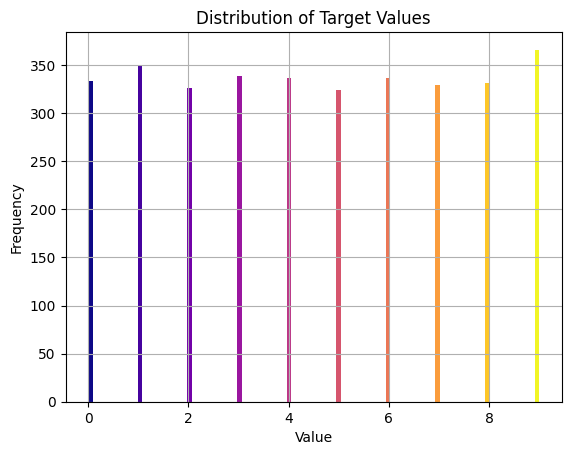

In [64]:
# Like the homework before, we plot the distribution of the target

def plot_gradient_histogram(df: pd.DataFrame, bins=100, cmap_name='plasma', which='Target'):
    """
    Plots a histogram of all values in the DataFrame with a gradient color map.
    """

    import matplotlib
    from matplotlib.colors import Normalize
    # Flatten data and remove NaNs
    data = df.values.flatten()
    data = data[~np.isnan(data)]
    
    # Compute histogram
    counts, bin_edges, patches = plt.hist(data, bins=bins)
    cmap = matplotlib.colormaps.get_cmap(cmap_name)
    norm = Normalize(vmin=bin_edges.min(), vmax=bin_edges.max())
    for edge, patch in zip(bin_edges, patches):
        patch.set_facecolor(cmap(norm(edge)))
    
    # Enhance plot aesthetics
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {which} Values')
    plt.grid(True)
    plt.show()

# Plot the distribution of the train target
plot_gradient_histogram(pd.DataFrame(nn_Module._to_labels(train_target).data.cpu()))

# Distribution of samples are balanced generally.

`2.3 Train and test models with different hyperparameters`

and

`2.3.1 Evaluate using accuracy, precision, recall, F1-score, and confusion matrix`

In [138]:
# Create an Evaluation Pipeline
def eval_pipeline(evaluator: nn_SInterf_Evaluator, X: Tensor, y_true: Tensor) -> tuple:

    pred = evaluator.predict(X)
    acc = MultiClassificationMetrics(pred, y_true, "accuracy").compute().to_list()
    prec = MultiClassificationMetrics(pred, y_true, "precision").compute().to_list()
    recall = MultiClassificationMetrics(pred, y_true, "recall").compute().to_list()
    f1s = MultiClassificationMetrics(pred, y_true, "f1").compute().to_list()
    cfm = MultiClassificationMetrics(pred, y_true, "confusion_matrix").compute()
    # Normalize the confusion matrix
    cfm = cfm.astype(torch.float32)
    cfm_sum = cfm.sum(axis = 0).reshape([-1, 1]).repeat(cfm.shape[0], axis = 1)
    cfm = cfm / cfm_sum
    return pred, acc, prec, recall, f1s, cfm


In [65]:
# Construct Model Structure - Benchmark Model 1 - 2 Layers, Small Model

class Model_1(nn_Module):

    def __init__(self, **kwargs):
        # Nathmath Huang (This is a template definition)
        super().__init__(module_name="Model_1", **kwargs)
        # In one module, layers should be sequential.
        self.dense_1 = Dense(64, 32, True, **kwargs)
        self.actv_1 = ReLU(**kwargs)
        self.dense_2 = Dense(32, 10, True, **kwargs)
        self.softmax_1 = Softmax(**kwargs)

    def forward(self, inputs):
        out = self.dense_1(inputs)
        out = self.actv_1(out)
        out = self.dense_2(out)
        out = self.softmax_1(out)
        return out
    

In [164]:
# Construct Model Structure - Benchmark Model 2 - 3 Layers, Meidum Sized Model with Dropout

class Model_2(nn_Module):

    def __init__(self, **kwargs):
        # Nathmath Huang (This is a template definition)
        super().__init__(module_name="Model_2", **kwargs)
        # In one module, layers should be sequential.
        self.dense_1 = Dense(64, 128, True, init_scale=0.1, **kwargs)
        self.actv_1 = LeakyReLU(**kwargs)
        self.dropout1 = Dropout(0.5, **kwargs)
        self.dense_2 = Dense(128, 32, True, init_scale=0.1, **kwargs)
        self.actv_2 = Tanh(**kwargs)
        self.dense_3 = Dense(32, 10, True, init_scale=0.1, **kwargs)
        self.softmax_1 = Softmax(**kwargs)

    def forward(self, inputs):
        out = self.dense_1(inputs)
        out = self.actv_1(out)
        out = self.dropout1(out)
        out = self.dense_2(out)
        out = self.actv_2(out)
        out = self.dense_3(out)
        out = self.softmax_1(out)
        return out
    

In [186]:
# Construct Model Structure - Benchmark Model 3 - 3 Layers, Large Sized Model with Higher Rate Dropout

class Model_3(nn_Module):

    def __init__(self, **kwargs):
        # Nathmath Huang (This is a template definition)
        super().__init__(module_name="Model_3", **kwargs)
        # In one module, layers should be sequential.
        self.dense_1 = Dense(64, 256, True, init_scale=0.1, **kwargs)
        self.actv_1 = LeakyReLU(**kwargs)
        self.dropout_1 = Dropout(0.5, **kwargs)
        self.dense_2 = Dense(256, 128, True, init_scale=0.1, **kwargs)
        self.actv_2 = Tanh(**kwargs)
        self.dropout_2 = Dropout(0.2, **kwargs)
        self.dense_3 = Dense(128, 10, True, init_scale=0.1, **kwargs)
        self.softmax_1 = Softmax(**kwargs)

    def forward(self, inputs):
        out = self.dense_1(inputs)
        out = self.actv_1(out)
        out = self.dropout_1(out)
        out = self.dense_2(out)
        out = self.actv_2(out)
        out = self.dropout_2(out)
        out = self.dense_3(out)
        out = self.softmax_1(out)
        return out
    

2.3.1.1 Results from the 1st Model

In [ ]:
# Train and Evaluate the model - Benchmark Model 1 - 2 Layers, Small Model
# 

model1 = Model_1(backend=backend, device=device, autograd=False)
crit1 = MultiCrossEntropy(eps = 1e-10, raw_logits=False, backend=backend, device=device, autograd=False)
optm1 = AdamW(model1.parameters(), lr = 2e-4, eps = 1e-10, backend=backend, device=device, autograd=False)
eval1 = Evaluator("Eval_1", task = "classification", module=model1, criterion=crit1, optimizer=optm1)

# Start to train the model
eval1.fit(
    X = train_feature, y = train_target,
    epoches = 5000,
    batch_size = 768,
    shuffle = True,
    random_state = None,
    one_hot = True,
    verbosity = 1,
    evalper = 1,
    evalset = {
        "Train": (train_feature, train_target),
        "Valid": (valid_feature, valid_target),
        "Test":  (test_feature, test_target)
    },
    evalmetrics = ["logloss"],
    early_stop = 5,
    early_stop_logic = "most"
)

Training on Total Epoch: 0, Round: 0
Training on Total Epoch: 1, Round: 1
Training on Total Epoch: 2, Round: 2
Evalset: [Train : Metrics { logloss:2.3015,  }]
Evalset: [Valid : Metrics { logloss:2.3018,  }]
Evalset: [Test : Metrics { logloss:2.3016,  }]
Training on Total Epoch: 3, Round: 3
Evalset: [Train : Metrics { logloss:2.3009,  }]
Evalset: [Valid : Metrics { logloss:2.3014,  }]
Evalset: [Test : Metrics { logloss:2.3011,  }]
Training on Total Epoch: 4, Round: 4
Evalset: [Train : Metrics { logloss:2.3001,  }]
Evalset: [Valid : Metrics { logloss:2.3007,  }]
Evalset: [Test : Metrics { logloss:2.3004,  }]
Training on Total Epoch: 5, Round: 5
Evalset: [Train : Metrics { logloss:2.2991,  }]
Evalset: [Valid : Metrics { logloss:2.2999,  }]
Evalset: [Test : Metrics { logloss:2.2995,  }]
Training on Total Epoch: 6, Round: 6
Evalset: [Train : Metrics { logloss:2.2979,  }]
Evalset: [Valid : Metrics { logloss:2.2987,  }]
Evalset: [Test : Metrics { logloss:2.2983,  }]
Training on Total Epoch: 7

NN Simple Interf Evaluator(name = Eval_1, task = classification, has trained n_epoch = 3172, n_step = 15860).

In [ ]:
# Train and Evaluate the model - Benchmark Model 1 - 2 Layers, Small Model
# 

# Print the results for the test-set
eval1.eval()
pred, acc, prec, recall, f1, cfm = eval_pipeline(eval1, test_feature, test_target)
print("Model Config: {Benchmark Evaluation: Model1, (64, 32, 10)}")
print("ACC    :", round(acc, 6))
print("PREC   :", round(prec, 6))
print("RECALL :", round(recall, 6))
print("F1     :", round(f1, 6))
print("CONFUSION MATRIX:\n", pd.DataFrame(cfm.to_numpy_array().round(4)))

Model Config: {Benchmark Evaluation: Model1, (64, 32, 10)}
ACC    : 0.975979
PREC   : 0.976448
RECALL : 0.975652
F1     : 0.975806
CONFUSION MATRIX:
         0       1       2       3    4       5       6       7       8       9
0  0.9837  0.0000  0.0000  0.0000  0.0  0.0000  0.0000  0.0000  0.0000  0.0000
1  0.0000  0.9268  0.0000  0.0000  0.0  0.0000  0.0000  0.0000  0.0081  0.0000
2  0.0000  0.0180  0.9910  0.0000  0.0  0.0000  0.0000  0.0000  0.0000  0.0000
3  0.0000  0.0000  0.0083  0.9833  0.0  0.0417  0.0000  0.0000  0.0000  0.0083
4  0.0086  0.0000  0.0000  0.0000  1.0  0.0000  0.0086  0.0000  0.0000  0.0000
5  0.0000  0.0000  0.0000  0.0081  0.0  0.9593  0.0000  0.0081  0.0000  0.0000
6  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.9907  0.0000  0.0000  0.0000
7  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0000  0.9903  0.0000  0.0000
8  0.0000  0.0421  0.0000  0.0105  0.0  0.0000  0.0000  0.0000  0.9684  0.0211
9  0.0097  0.0291  0.0000  0.0000  0.0  0.0000  0.0000  0.00

2.3.1.2 Results from the 2nd Model

In [169]:
# Train and Evaluate the model - Benchmark Model 2 - 3 Layers, Meidum Sized Model with Dropout
# 
model2 = Model_2(backend=backend, device=device, autograd=False)
crit2 = MultiCrossEntropy(eps = 1e-10, raw_logits=False, backend=backend, device=device, autograd=False)
optm2 = AdamW(model2.parameters(), lr = 1e-4, eps = 1e-10, backend=backend, device=device, autograd=False)
eval2 = Evaluator("Eval_2", task = "classification", module=model2, criterion=crit2, optimizer=optm2)

# Start to train the model
eval2.fit(
    X = train_feature, y = train_target,
    epoches = 5000,
    batch_size = 1024,
    shuffle = True,
    random_state = None,
    one_hot = True,
    verbosity = 1,
    evalper = 1,
    evalset = {
        "Train": (train_feature, train_target),
        "Valid": (valid_feature, valid_target),
        "Test":  (test_feature, test_target)
    },
    evalmetrics = ["logloss"],
    early_stop = 5,
    early_stop_logic = "most"
)

Training on Total Epoch: 0, Round: 0
Training on Total Epoch: 1, Round: 1
Training on Total Epoch: 2, Round: 2
Evalset: [Train : Metrics { logloss:2.3085,  }]
Evalset: [Valid : Metrics { logloss:2.3052,  }]
Evalset: [Test : Metrics { logloss:2.3069,  }]
Training on Total Epoch: 3, Round: 3
Evalset: [Train : Metrics { logloss:2.3075,  }]
Evalset: [Valid : Metrics { logloss:2.3049,  }]
Evalset: [Test : Metrics { logloss:2.3061,  }]
Training on Total Epoch: 4, Round: 4
Evalset: [Train : Metrics { logloss:2.3066,  }]
Evalset: [Valid : Metrics { logloss:2.3047,  }]
Evalset: [Test : Metrics { logloss:2.3054,  }]
Training on Total Epoch: 5, Round: 5
Evalset: [Train : Metrics { logloss:2.3059,  }]
Evalset: [Valid : Metrics { logloss:2.3046,  }]
Evalset: [Test : Metrics { logloss:2.3048,  }]
Training on Total Epoch: 6, Round: 6
Evalset: [Train : Metrics { logloss:2.3052,  }]
Evalset: [Valid : Metrics { logloss:2.3045,  }]
Evalset: [Test : Metrics { logloss:2.3043,  }]
Training on Total Epoch: 7

NN Simple Interf Evaluator(name = Eval_2, task = classification, has trained n_epoch = 1896, n_step = 7584).

In [170]:
# Train and Evaluate the model - Benchmark Model 2 - 3 Layers, Meidum Sized Model with Dropout
# 

# Print the results for the test-set
eval2.eval()
pred, acc, prec, recall, f1, cfm = eval_pipeline(eval2, test_feature, test_target)
print("Model Config: {Benchmark Evaluation: Model2, (64, 128, Dropout, 32, 10)}")
print("ACC    :", round(acc, 6))
print("PREC   :", round(prec, 6))
print("RECALL :", round(recall, 6))
print("F1     :", round(f1, 6))
print("CONFUSION MATRIX:\n", pd.DataFrame(cfm.to_numpy_array().round(4)))

Model Config: {Benchmark Evaluation: Model2, (64, 128, Dropout, 32, 10)}
ACC    : 0.980427
PREC   : 0.980974
RECALL : 0.980187
F1     : 0.980424
CONFUSION MATRIX:
         0       1    2       3       4       5       6    7       8       9
0  0.9918  0.0000  0.0  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0000
1  0.0000  0.9583  0.0  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0000
2  0.0000  0.0090  1.0  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0000
3  0.0000  0.0000  0.0  0.9677  0.0000  0.0323  0.0000  0.0  0.0000  0.0081
4  0.0000  0.0000  0.0  0.0000  0.9829  0.0000  0.0256  0.0  0.0000  0.0000
5  0.0000  0.0000  0.0  0.0000  0.0082  0.9672  0.0000  0.0  0.0082  0.0000
6  0.0000  0.0000  0.0  0.0000  0.0000  0.0000  0.9725  0.0  0.0000  0.0000
7  0.0000  0.0000  0.0  0.0000  0.0000  0.0000  0.0000  1.0  0.0000  0.0000
8  0.0000  0.0312  0.0  0.0208  0.0000  0.0000  0.0000  0.0  0.9792  0.0000
9  0.0099  0.0099  0.0  0.0198  0.0099  0.0000  0.0000  0.0  0.0099  0.9901


2.3.1.3 Results from the 3rd Model

In [ ]:
# Train and Evaluate the model - Benchmark Model 3 - 3 Layers, Large Sized Model with Higher Rate Dropout
#

model3 = Model_3(backend=backend, device=device, autograd=False)
crit3 = MultiCrossEntropy(eps = 1e-10, raw_logits=False, backend=backend, device=device, autograd=False)
optm3 = AdamW(model3.parameters(), lr = 1e-4, eps = 1e-10, backend=backend, device=device, autograd=False)
eval3 = Evaluator("Eval_3", task = "classification", module=model3, criterion=crit3, optimizer=optm3)

# Start to train the model
eval3.fit(
    X = train_feature, y = train_target,
    epoches = 5000,
    batch_size = 2048,
    shuffle = True,
    random_state = None,
    one_hot = True,
    verbosity = 1,
    evalper = 1,
    evalset = {
        "Train": (train_feature, train_target),
        "Valid": (valid_feature, valid_target),
        "Test":  (test_feature, test_target)
    },
    evalmetrics = ["logloss"],
    early_stop = 5,
    early_stop_logic = "most"
)

Training on Total Epoch: 1938, Round: 0
Training on Total Epoch: 1939, Round: 1
Training on Total Epoch: 1940, Round: 2
Evalset: [Train : Metrics { logloss:0.0163,  }]
Evalset: [Valid : Metrics { logloss:0.0919,  }]
Evalset: [Test : Metrics { logloss:0.0591,  }]
Training on Total Epoch: 1941, Round: 3
Evalset: [Train : Metrics { logloss:0.0162,  }]
Evalset: [Valid : Metrics { logloss:0.0919,  }]
Evalset: [Test : Metrics { logloss:0.059,  }]
Training on Total Epoch: 1942, Round: 4
Evalset: [Train : Metrics { logloss:0.0162,  }]
Evalset: [Valid : Metrics { logloss:0.092,  }]
Evalset: [Test : Metrics { logloss:0.0589,  }]
Training on Total Epoch: 1943, Round: 5
Evalset: [Train : Metrics { logloss:0.0161,  }]
Evalset: [Valid : Metrics { logloss:0.092,  }]
Evalset: [Test : Metrics { logloss:0.0587,  }]
Training on Total Epoch: 1944, Round: 6
Evalset: [Train : Metrics { logloss:0.0161,  }]
Evalset: [Valid : Metrics { logloss:0.092,  }]
Evalset: [Test : Metrics { logloss:0.0586,  }]
Training 

NN Simple Interf Evaluator(name = Eval_3, task = classification, has trained n_epoch = 2357, n_step = 4714).

In [210]:
# Train and Evaluate the model - Benchmark Model 3 - 3 Layers, Large Sized Model with Higher Rate Dropout
# 

# Print the results for the test-set
eval3.eval()
pred, acc, prec, recall, f1, cfm = eval_pipeline(eval3, test_feature, test_target)
print("Model Config: {Benchmark Evaluation: Model3, (64, 256, Dropout, 128, Dropout, 10)}")
print("ACC    :", round(acc, 6))
print("PREC   :", round(prec, 6))
print("RECALL :", round(recall, 6))
print("F1     :", round(f1, 6))
print("CONFUSION MATRIX:\n", pd.DataFrame(cfm.to_numpy_array().round(4)))

Model Config: {Benchmark Evaluation: Model3, (64, 256, Dropout, 128, Dropout, 10)}
ACC    : 0.983096
PREC   : 0.983669
RECALL : 0.983208
F1     : 0.983318
CONFUSION MATRIX:
         0       1    2       3       4       5       6       7       8       9
0  0.9918  0.0000  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
1  0.0000  0.9664  0.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
2  0.0000  0.0090  1.0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
3  0.0000  0.0000  0.0  0.9752  0.0000  0.0413  0.0000  0.0083  0.0000  0.0083
4  0.0085  0.0000  0.0  0.0000  0.9831  0.0000  0.0085  0.0000  0.0000  0.0000
5  0.0000  0.0000  0.0  0.0081  0.0081  0.9593  0.0000  0.0000  0.0000  0.0000
6  0.0000  0.0000  0.0  0.0000  0.0000  0.0000  0.9907  0.0000  0.0000  0.0000
7  0.0000  0.0000  0.0  0.0000  0.0000  0.0000  0.0000  0.9903  0.0000  0.0000
8  0.0000  0.0316  0.0  0.0211  0.0000  0.0000  0.0000  0.0000  0.9895  0.0000
9  0.0000  0.0000  0.0  0.0000  0.00

In [ ]:
# Example of saving the Gradient Boosting model to disk.
#

# |
# V De-comment this line to save the model.
# model2.save(model2, "./models/MLP.ID02.bin")

# |
# V De-comment this line to save the evaluator.
# eval3.save(eval3, "./models/MLP.EVAL03.bin")

`2.3.2 Visualization of the predictions and training process`

In [ ]:
# Plot training/validation loss over epochs

# Collect train-valid losses
def collect_losses(evaluator: nn_SInterf_Evaluator, 
                   metric = "logloss",
                   collect = ["Train", "Valid"]) -> Tuple[dict, pd.DataFrame]:

    evalhist = deepcopy(evaluator.evalhist_)
    evaldict = {}
    evaldict["No"] = []
    for c in collect:
        evaldict[c] = []

    # For each, extract data as float types
    for k in evalhist.keys():
        obj = evalhist[k]
        # No self-increment
        evaldict["No"].append(k)
        for c in collect:
            data = obj[c][metric].to_list()
            evaldict[c].append(data)

    return evaldict, pd.DataFrame(evaldict)

# Plot train/train-valid losses
def plot_loss(df, xlabel_: str | None = None):

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.collections import LineCollection
    from matplotlib.colors import Normalize

    if 'No' in df.columns:
        x = df['No'].values
        xlabel = 'Epoch'
    else:
        x = np.arange(len(df))
        xlabel = 'Index' if xlabel_ is None else xlabel_

    fig, ax = plt.subplots(figsize=(12, 5))

    # Plot training loss with gradient color
    y_train = df['Train'].values
    pts_train = np.array([x, y_train]).T.reshape(-1, 1, 2)
    segs_train = np.concatenate([pts_train[:-1], pts_train[1:]], axis=1)
    norm_train = Normalize(vmin=y_train.min(), vmax=y_train.max())
    lc_train = LineCollection(segs_train, cmap='viridis', norm=norm_train)
    lc_train.set_array(y_train)
    lc_train.set_linewidth(2)
    ax.add_collection(lc_train)
    cbar_train = fig.colorbar(lc_train, ax=ax, pad=0.02)
    cbar_train.set_label('Loss')

    # Plot validation loss if available
    if 'Valid' in df.columns:
        y_valid = df['Valid'].values
        pts_valid = np.array([x, y_valid]).T.reshape(-1, 1, 2)
        segs_valid = np.concatenate([pts_valid[:-1], pts_valid[1:]], axis=1)
        norm_valid = Normalize(vmin=y_valid.min(), vmax=y_valid.max())
        lc_valid = LineCollection(segs_valid, cmap='plasma', norm=norm_valid)
        lc_valid.set_array(y_valid)
        lc_valid.set_linewidth(2)
        ax.add_collection(lc_valid)

    ax.set_xlim(x.min(), x.max())
    y_min = y_train.min()
    y_max = y_train.max()
    if 'Valid' in df.columns:
        y_min = min(y_min, y_valid.min())
        y_max = max(y_max, y_valid.max())
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Loss')
    ax.set_title('Loss Over {}s'.format(xlabel))
    plt.tight_layout()
    plt.show()


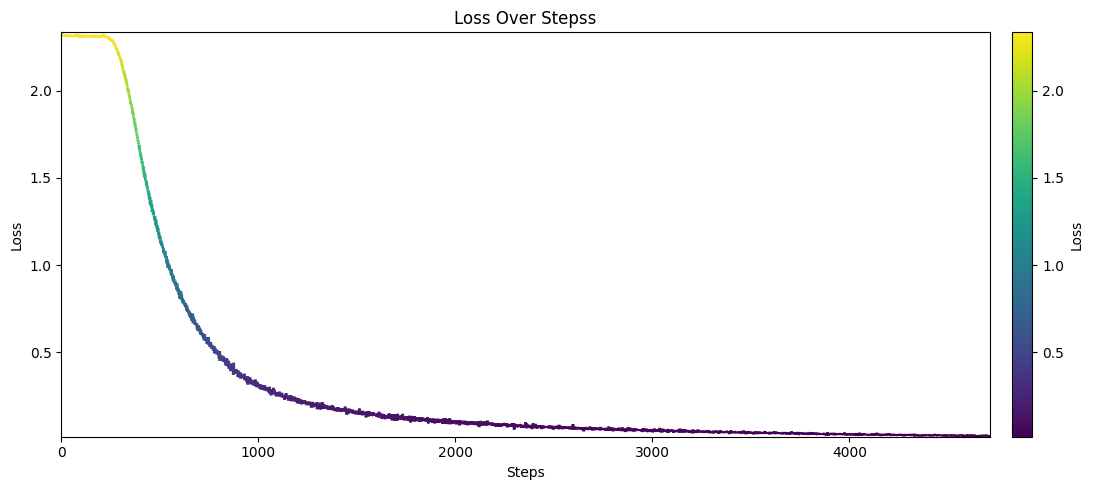

In [229]:
# Plot the losses across steps

step_losses = pd.DataFrame({"Train": eval3.losses_.values()}, index=list(eval3.losses_.keys()))
plot_loss(step_losses, xlabel_="Steps")

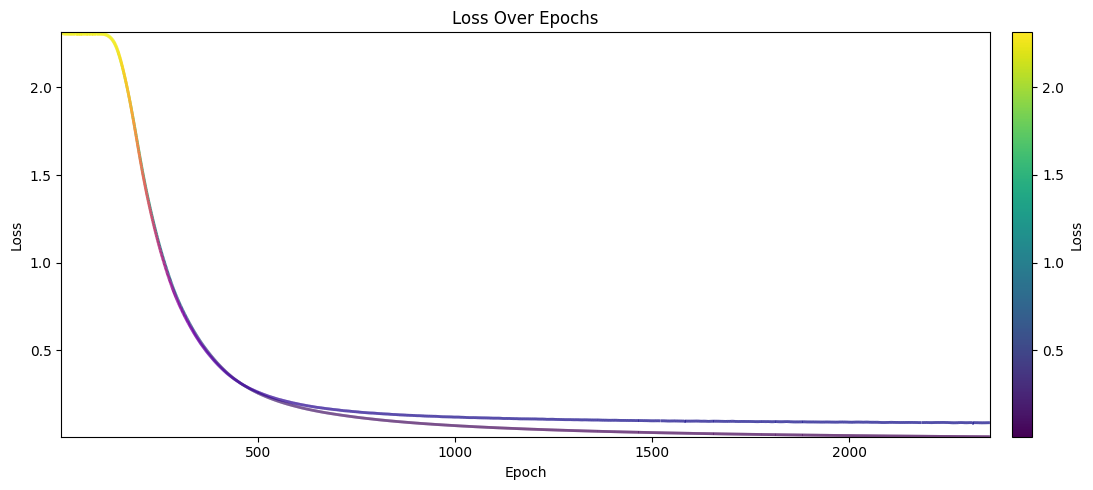

In [ ]:
# Plot the epoch-wise Train/Validation change

evaldict, losses = collect_losses(eval3)
plot_loss(losses)

In [ ]:
# Analyze overfitting vs underfitting and architectural choices

# My models demonstrate progressively improving performance (ACC: 97.6% to 98.3%)
#   with increasing architectural complexity and dropout/L2 regularization.
# Underfitting: Not evident, as all models achieve strong test metrics (>97.5% ACC) on MNIST, 
#   indicating sufficient capacity to learn the dataset's patterns.
# Overfitting: Mitigated by dropout layers (Model2/3), which regularize training and reduce co-adaptation 
#   of neurons. The consistent improvement in test performance with added complexity suggests effective generalization.
# Note, albeit you have dropout and L2 regularization, if training for a prolonged steps, overfitting may happen.
# An example is shown below.

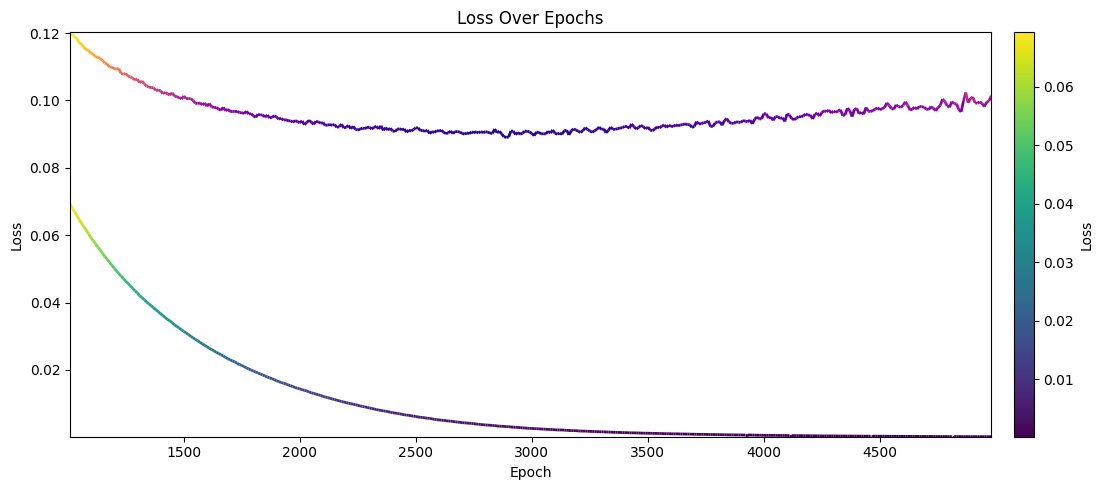

In [ ]:
# Here is an example of overfitted model

# BAD EXAMPLE: with overfitting
modelx = Model_3(backend=backend, device=device, autograd=False)
critx = MultiCrossEntropy(eps = 1e-10, raw_logits=False, backend=backend, device=device, autograd=False)
optmx = AdamW(modelx.parameters(), lr = 1e-4, eps = 1e-10, backend=backend, device=device, autograd=False)
evalx = Evaluator("Eval_x", task = "classification", module=modelx, criterion=critx, optimizer=optmx)

# Start to train the model
evalx.fit(
    X = train_feature, y = train_target,
    epoches = 5000,
    batch_size = 2048,
    shuffle = True,
    random_state = None,
    one_hot = True,
    verbosity = 1,
    evalper = 10,
    evalset = {
        "Train": (train_feature, train_target),
        "Valid": (valid_feature, valid_target),
        "Test":  (test_feature, test_target)
    },
    evalmetrics = ["logloss"],
)

evaldict, losses = collect_losses(evalx)
plot_loss(losses.iloc[100:-1,])

In [ ]:
# Significant overfitting detected.

`End of Homework 3 Q3 by Nathmath Huang (bh2821)`